In [1]:
import matplotlib.pylab as plt
from matplotlib.pylab import rcParams

import numpy as np
import pandas as pd
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn import metrics
from sklearn.model_selection import GridSearchCV

from utils import generate_dmatrix

In [2]:
%matplotlib inline
# rcParams['figure.figsize'] = 12, 4

In [29]:
def fit_model(model, data, use_cv=True, cv_folds=5, early_stopping_rounds=50, eval_feature_importance=False):
    """
    Parameters
    ----------
    model : XGBClassifier
        Model with parameters pre-set
    data : dict[np.ndarray]
        Dict with the keys 'train_x', 'train_y', 'test_x', 'test_y' for the
        appropriate arrays.
    use_cv : bool
        Whether to use CV for setting the number of estimators. Default True.
    cv_folds : int
        Number of folds for the CV. Default 5.
    early_stopping_rounds : int
        How many rounds the model must train without improvement before
        stopping early.
    eval_feature_importance : bool
        If True, a feature importance plot is generated. Default False.
    """
    train_x = data['train_x']
    train_y = data['train_y']
    test_x = data['test_x']
    test_y = data['test_y']
    train_y[train_y == -1] = 0
    test_y[test_y == -1] = 0
    if use_cv:
        dmatrix = generate_dmatrix(train_x, train_y)
        xgb_params = model.get_xgb_params()
        nbr = model.get_params()['n_estimators']
        cv_results = xgb.cv(xgb_params, dmatrix, num_boost_round=nbr, metrics='logloss',
                            early_stopping_rounds=early_stopping_rounds, verbose_eval=False)
        n_est = cv_results.shape[0]
        model.set_params(n_estimators=n_est)
        print(f'[INFO] N. of estimators for this learning rate: {n_est}')
    
    # Fit model on data
    model.fit(train_x, train_y, eval_metric='logloss')
    # Evaluate model
    train_pred = model.predict(train_x)
    train_predprob = model.predict_proba(train_x)[:, 1]
    test_pred = model.predict(test_x)
    test_predprob = model.predict_proba(test_x)[:, 1]
    # Print model report
    print('Model Report\n============')
    print(f'Accuracy (train) : {metrics.accuracy_score(train_y, train_pred):.4g}')
    print(f'AUC Score (train) : {metrics.roc_auc_score(train_y, train_predprob):f}')
    print(f'Accuracy (test) : {metrics.accuracy_score(test_y, test_pred):.4g}')
    print(f'AUC Score (test) : {metrics.roc_auc_score(test_y, test_predprob):f}')
    # Evaluate feature importance
    if eval_feature_importance:
        feat_imp = pd.Series(model.get_booster().get_fscore()).sort_values(ascending=False)
        feat_imp.plot(kind='bar', title='Feature Importances')
        plt.ylabel('Feature Importance Score')
        plt.show()
        plt.clf()
    return model

In [12]:
from sklearn.model_selection import train_test_split

from benchmark_tests.load_benchmark_datasets import load_dataset_m41, load_dataset_h41
from load_partitions import load_partitions

In [13]:
m41_x, m41_y = load_dataset_m41()
m41_train_x, m41_test_x, m41_train_y, m41_test_y = train_test_split(
    m41_x, m41_y, stratify=m41_y, test_size=0.3, random_state=42
)
m41_train_y[m41_train_y == -1] = 0
m41_test_y[m41_test_y == -1] = 0
m41_data = {'train_x': m41_train_x,
            'train_y': m41_train_y,
            'test_x': m41_test_x,
            'test_y': m41_test_y}

In [14]:
h41_x, h41_y = load_dataset_h41()
h41_train_x, h41_test_x, h41_train_y, h41_test_y = train_test_split(
    h41_x, h41_y, stratify=h41_y, test_size=0.3, random_state=42
)
h41_train_y[h41_train_y == -1] = 0
h41_test_y[h41_test_y == -1] = 0
h41_data = {'train_x': h41_train_x,
            'train_y': h41_train_y,
            'test_x': h41_test_x,
            'test_y': h41_test_y}

In [5]:
def get_iris_data(dataset_name, partition=1):
    train_x, train_y, _, _, test_x, test_y, _, _ = load_partitions(
        dataset_name, partition, mask_value=0, scale_dataset=True)
    data = {'train_x': train_x,
            'train_y': train_y,
            'test_x': test_x,
            'test_y': test_y}
    return data

In [6]:
iris_left_24020_data = get_iris_data('left_240x20')

In [32]:
def get_iris_data_discrete(dataset_name, partition=1):
    from sklearn.preprocessing import KBinsDiscretizer
    train_x, train_y, _, _, test_x, test_y, _, _ = load_partitions(
        dataset_name, partition, mask_value=0, scale_dataset=True)
    disc = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='uniform')
    train_x = disc.fit_transform(train_x)
    test_x = disc.transform(test_x)
    data = {'train_x': train_x,
            'train_y': train_y,
            'test_x': test_x,
            'test_y': test_y}
    return data

In [33]:
iris_left_24020_disc_data = get_iris_data_discrete('left_240x20')

D:\Users\x_met\Anaconda3\envs\iris_gender4\lib\site-packages\sklearn\preprocessing\_discretization.py:188: UserWarning: Feature 17 is constant and will be replaced with 0.
  "replaced with 0." % jj)
D:\Users\x_met\Anaconda3\envs\iris_gender4\lib\site-packages\sklearn\preprocessing\_discretization.py:188: UserWarning: Feature 188 is constant and will be replaced with 0.
  "replaced with 0." % jj)
D:\Users\x_met\Anaconda3\envs\iris_gender4\lib\site-packages\sklearn\preprocessing\_discretization.py:188: UserWarning: Feature 192 is constant and will be replaced with 0.
  "replaced with 0." % jj)
D:\Users\x_met\Anaconda3\envs\iris_gender4\lib\site-packages\sklearn\preprocessing\_discretization.py:188: UserWarning: Feature 193 is constant and will be replaced with 0.
  "replaced with 0." % jj)
D:\Users\x_met\Anaconda3\envs\iris_gender4\lib\site-packages\sklearn\preprocessing\_discretization.py:188: UserWarning: Feature 207 is constant and will be replaced with 0.
  "replaced with 0." % jj)
D

## Step 1

[INFO] N. of estimators for this learning rate: 45
Model Report
Accuracy (train) : 0.9389
AUC Score (train) : 0.999460
Accuracy (test) : 0.8828
AUC Score (test) : 0.897983


D:\Users\x_met\Anaconda3\envs\iris_gender4\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


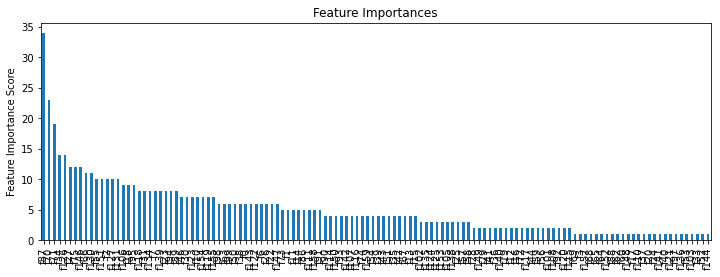

<Figure size 864x288 with 0 Axes>

In [30]:
# Using nucleotids (M41)
xgb1_nuc = XGBClassifier(
    learning_rate =0.1,
    n_estimators=1000,
    max_depth=5,
    min_child_weight=1,
    gamma=0,
    subsample=0.8,
    colsample_bytree=0.8,
    objective= 'binary:logistic',
    nthread=5,
    scale_pos_weight=1,
    seed=27
)
model = fit_model(xgb1_nuc, m41_data, eval_feature_importance=True)

[INFO] N. of estimators for this learning rate: 357


D:\Users\x_met\Anaconda3\envs\iris_gender4\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Model Report
Accuracy (train) : 1
AUC Score (train) : 1.000000
Accuracy (test) : 0.6254
AUC Score (test) : 0.680898


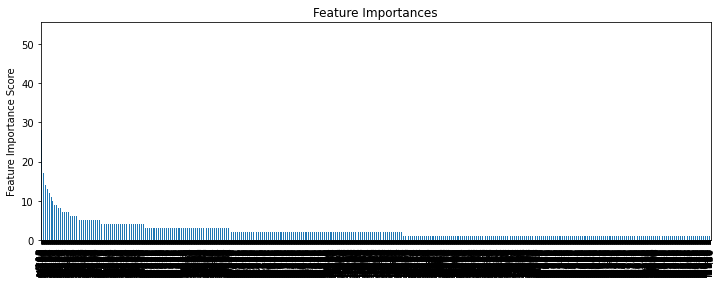

<Figure size 864x288 with 0 Axes>

In [36]:
# Using iris (left 240x20)
xgb1_iris = XGBClassifier(
    learning_rate =0.01,
    n_estimators=1000,
    max_depth=5,
    min_child_weight=1,
    gamma=0,
    subsample=0.8,
    colsample_bytree=0.8,
    objective= 'binary:logistic',
    nthread=5,
    scale_pos_weight=1,
    seed=27
)
model = fit_model(xgb1_iris, iris_left_24020_data, eval_feature_importance=True)

[INFO] N. of estimators for this learning rate: 264


D:\Users\x_met\Anaconda3\envs\iris_gender4\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Model Report
Accuracy (train) : 0.9933
AUC Score (train) : 0.999872
Accuracy (test) : 0.6037
AUC Score (test) : 0.645295


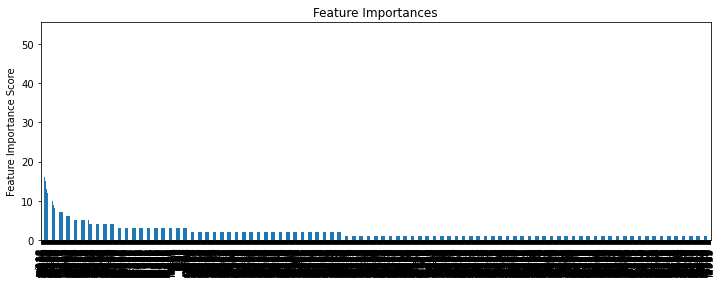

<Figure size 864x288 with 0 Axes>

In [37]:
# Using iris discrete (left 240x20)
xgb1_iris_d = XGBClassifier(
    learning_rate =0.01,
    n_estimators=1000,
    max_depth=5,
    min_child_weight=1,
    gamma=0,
    subsample=0.8,
    colsample_bytree=0.8,
    objective= 'binary:logistic',
    nthread=5,
    scale_pos_weight=1,
    seed=27
)
model = fit_model(xgb1_iris_d, iris_left_24020_disc_data, eval_feature_importance=True)

In [84]:
from pathlib import Path
import pickle

from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV, train_test_split
import xgboost as xgb
from xgboost.sklearn import XGBClassifier

from constants import datasets
from results_processing import generate_training_curves
from utils import generate_dmatrix


DEFAULT_PARAMS = {
    'objective': 'binary:logistic',
    'use_label_encoder': False,
    'eval_metric': 'logloss',
}
SEED = 42


def phase_1(data: dict, lr_list, out_folder, njobs: int, data_name: str):
    """Adjust learning rate and number of trees."""
    out_folder = Path(out_folder)
    out_folder.mkdir(exist_ok=True, parents=True)
    # Determine initial value for number of trees
    train_x = data['train_x']
    train_y = data['train_y']
    test_x = data['test_x']
    test_y = data['test_y']
    test_x, val_x, test_y, val_y = train_test_split(
        test_x, test_y, test_size=1 / 3, stratify=test_y, random_state=SEED
    )
    print({
        'n_train': train_x.shape[0],
        'n_train1': np.count_nonzero(train_y==1),
        'n_val': val_x.shape[0],
        'n_val1': np.count_nonzero(val_y==1),
        'n_test': test_x.shape[0],
        'n_test1': np.count_nonzero(test_y==1)
    })
    results = {}
    # Get base number of trees from xgb native CV
    for lr in lr_list:
        cur_results = {}
        model = XGBClassifier(
            **DEFAULT_PARAMS,
            learning_rate=lr,
            n_estimators=1000,
            max_depth=5,
            min_child_weight=1,
            gamma=0,
            subsample=0.8,
            colsample_bytree=0.8,
            nthread=njobs,
            scale_pos_weight=1,
            seed=SEED
        )
        dmatrix = generate_dmatrix(train_x, train_y)
        params = model.get_params()
        nbr = params['n_estimators']
        cv_results = xgb.cv(
            params,
            dmatrix,
            num_boost_round=nbr,
            metrics='logloss',
            early_stopping_rounds=50,
            nfold=5,
            verbose_eval=True
        )
        cur_results['cv_results'] = cv_results
        n_est = cv_results.shape[0]
        # Evaluate using these parameters
        model.set_params(
            n_estimators=n_est,
        )
        model.fit(
            train_x, train_y,
            eval_set=[(train_x, train_y), (val_x, val_y)],
            eval_metric=['error', 'logloss']
        )
        pred = model.predict(test_x)
        report = classification_report(test_y, pred, output_dict=True)
        cur_results['report'] = report
        results[lr] = cur_results
        generate_training_curves(model, out_folder / f'phase1_{lr:.02f}/curves',
                                 f'XGBoost ({data_name})')

    with open(out_folder / 'phase1_results.pickle', 'wb') as f:
        pickle.dump(results, f)
    # Explore other values for n_estimators
    # for lr in lr_list:
        # base_n_est = results[lr]['cv_results'].shape[0]


    return results

In [67]:
results_m41 = phase_1(m41_data, np.arange(0.01, 0.11, 0.01), 'results_xgb_params/m41',
                       njobs=5, data_name='M41')

{'n_train': 1015, 'n_train1': 508, 'n_val': 145, 'n_val1': 72, 'n_test': 290, 'n_test1': 145}
[19:30:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "enable_categorical", "missing", "n_estimators", "use_label_encoder" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[19:30:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "enable_categorical", "missing", "n_estimators", "use_label_encoder" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please 

[90]	train-logloss:0.38627+0.00624	test-logloss:0.42752+0.01898
[91]	train-logloss:0.38458+0.00623	test-logloss:0.42639+0.01898
[92]	train-logloss:0.38273+0.00619	test-logloss:0.42491+0.01922
[93]	train-logloss:0.38102+0.00619	test-logloss:0.42368+0.01927
[94]	train-logloss:0.37938+0.00630	test-logloss:0.42261+0.01934
[95]	train-logloss:0.37774+0.00638	test-logloss:0.42149+0.01952
[96]	train-logloss:0.37609+0.00643	test-logloss:0.42012+0.01969
[97]	train-logloss:0.37439+0.00633	test-logloss:0.41883+0.01995
[98]	train-logloss:0.37267+0.00636	test-logloss:0.41748+0.01994
[99]	train-logloss:0.37108+0.00626	test-logloss:0.41621+0.02024
[100]	train-logloss:0.36941+0.00630	test-logloss:0.41505+0.02032
[101]	train-logloss:0.36783+0.00630	test-logloss:0.41403+0.02052
[102]	train-logloss:0.36619+0.00637	test-logloss:0.41266+0.02056
[103]	train-logloss:0.36464+0.00634	test-logloss:0.41151+0.02072
[104]	train-logloss:0.36314+0.00648	test-logloss:0.41034+0.02074
[105]	train-logloss:0.36160+0.00645

[217]	train-logloss:0.24779+0.00684	test-logloss:0.34137+0.03194
[218]	train-logloss:0.24710+0.00682	test-logloss:0.34123+0.03197
[219]	train-logloss:0.24641+0.00683	test-logloss:0.34097+0.03209
[220]	train-logloss:0.24575+0.00684	test-logloss:0.34069+0.03223
[221]	train-logloss:0.24504+0.00685	test-logloss:0.34054+0.03219
[222]	train-logloss:0.24441+0.00683	test-logloss:0.34035+0.03226
[223]	train-logloss:0.24374+0.00680	test-logloss:0.34004+0.03233
[224]	train-logloss:0.24308+0.00679	test-logloss:0.33982+0.03245
[225]	train-logloss:0.24245+0.00680	test-logloss:0.33943+0.03255
[226]	train-logloss:0.24180+0.00680	test-logloss:0.33911+0.03260
[227]	train-logloss:0.24115+0.00679	test-logloss:0.33892+0.03264
[228]	train-logloss:0.24051+0.00678	test-logloss:0.33854+0.03273
[229]	train-logloss:0.23988+0.00677	test-logloss:0.33843+0.03284
[230]	train-logloss:0.23925+0.00675	test-logloss:0.33823+0.03303
[231]	train-logloss:0.23859+0.00677	test-logloss:0.33804+0.03311
[232]	train-logloss:0.237

[344]	train-logloss:0.18329+0.00612	test-logloss:0.32305+0.03950
[345]	train-logloss:0.18291+0.00610	test-logloss:0.32306+0.03961
[346]	train-logloss:0.18253+0.00607	test-logloss:0.32304+0.03965
[347]	train-logloss:0.18212+0.00606	test-logloss:0.32297+0.03984
[348]	train-logloss:0.18173+0.00605	test-logloss:0.32297+0.03996
[349]	train-logloss:0.18136+0.00602	test-logloss:0.32291+0.03995
[350]	train-logloss:0.18097+0.00602	test-logloss:0.32286+0.04004
[351]	train-logloss:0.18060+0.00602	test-logloss:0.32282+0.04005
[352]	train-logloss:0.18021+0.00600	test-logloss:0.32281+0.04005
[353]	train-logloss:0.17982+0.00594	test-logloss:0.32273+0.04009
[354]	train-logloss:0.17945+0.00593	test-logloss:0.32273+0.04016
[355]	train-logloss:0.17906+0.00594	test-logloss:0.32264+0.04029
[356]	train-logloss:0.17871+0.00592	test-logloss:0.32253+0.04032
[357]	train-logloss:0.17832+0.00593	test-logloss:0.32233+0.04032
[358]	train-logloss:0.17793+0.00593	test-logloss:0.32217+0.04030
[359]	train-logloss:0.177

[471]	train-logloss:0.14152+0.00489	test-logloss:0.31909+0.04613
[472]	train-logloss:0.14126+0.00490	test-logloss:0.31923+0.04623
[473]	train-logloss:0.14100+0.00490	test-logloss:0.31920+0.04637
[474]	train-logloss:0.14068+0.00490	test-logloss:0.31902+0.04630
[475]	train-logloss:0.14040+0.00488	test-logloss:0.31905+0.04629
[476]	train-logloss:0.14006+0.00491	test-logloss:0.31902+0.04636
[477]	train-logloss:0.13976+0.00486	test-logloss:0.31901+0.04639
[478]	train-logloss:0.13950+0.00487	test-logloss:0.31902+0.04647
[479]	train-logloss:0.13921+0.00483	test-logloss:0.31905+0.04649
[480]	train-logloss:0.13894+0.00483	test-logloss:0.31902+0.04656
[481]	train-logloss:0.13863+0.00481	test-logloss:0.31901+0.04665
[482]	train-logloss:0.13837+0.00485	test-logloss:0.31900+0.04671
[483]	train-logloss:0.13812+0.00485	test-logloss:0.31892+0.04677
[484]	train-logloss:0.13784+0.00487	test-logloss:0.31893+0.04676
[485]	train-logloss:0.13751+0.00485	test-logloss:0.31901+0.04683
[486]	train-logloss:0.137

[15]	validation_0-error:0.11330	validation_0-logloss:0.60420	validation_1-error:0.15172	validation_1-logloss:0.61786
[16]	validation_0-error:0.11330	validation_0-logloss:0.59948	validation_1-error:0.15172	validation_1-logloss:0.61393
[17]	validation_0-error:0.11330	validation_0-logloss:0.59479	validation_1-error:0.15172	validation_1-logloss:0.60989
[18]	validation_0-error:0.11330	validation_0-logloss:0.59019	validation_1-error:0.15172	validation_1-logloss:0.60611
[19]	validation_0-error:0.11330	validation_0-logloss:0.58556	validation_1-error:0.15172	validation_1-logloss:0.60250
[20]	validation_0-error:0.11330	validation_0-logloss:0.58114	validation_1-error:0.15172	validation_1-logloss:0.59906
[21]	validation_0-error:0.11330	validation_0-logloss:0.57671	validation_1-error:0.15172	validation_1-logloss:0.59513
[22]	validation_0-error:0.11330	validation_0-logloss:0.57233	validation_1-error:0.15172	validation_1-logloss:0.59157
[23]	validation_0-error:0.11330	validation_0-logloss:0.56810	val

[86]	validation_0-error:0.11133	validation_0-logloss:0.39583	validation_1-error:0.15172	validation_1-logloss:0.45102
[87]	validation_0-error:0.11133	validation_0-logloss:0.39390	validation_1-error:0.15172	validation_1-logloss:0.44951
[88]	validation_0-error:0.11133	validation_0-logloss:0.39219	validation_1-error:0.15172	validation_1-logloss:0.44843
[89]	validation_0-error:0.11133	validation_0-logloss:0.39048	validation_1-error:0.15172	validation_1-logloss:0.44712
[90]	validation_0-error:0.11133	validation_0-logloss:0.38864	validation_1-error:0.15172	validation_1-logloss:0.44580
[91]	validation_0-error:0.11133	validation_0-logloss:0.38686	validation_1-error:0.15172	validation_1-logloss:0.44448
[92]	validation_0-error:0.11133	validation_0-logloss:0.38520	validation_1-error:0.15172	validation_1-logloss:0.44327
[93]	validation_0-error:0.11133	validation_0-logloss:0.38380	validation_1-error:0.15172	validation_1-logloss:0.44222
[94]	validation_0-error:0.11133	validation_0-logloss:0.38198	val

[156]	validation_0-error:0.11034	validation_0-logloss:0.30743	validation_1-error:0.15172	validation_1-logloss:0.39546
[157]	validation_0-error:0.11034	validation_0-logloss:0.30650	validation_1-error:0.15172	validation_1-logloss:0.39528
[158]	validation_0-error:0.11034	validation_0-logloss:0.30551	validation_1-error:0.15172	validation_1-logloss:0.39484
[159]	validation_0-error:0.11034	validation_0-logloss:0.30452	validation_1-error:0.15172	validation_1-logloss:0.39433
[160]	validation_0-error:0.11034	validation_0-logloss:0.30356	validation_1-error:0.15172	validation_1-logloss:0.39374
[161]	validation_0-error:0.11034	validation_0-logloss:0.30267	validation_1-error:0.15172	validation_1-logloss:0.39317
[162]	validation_0-error:0.11034	validation_0-logloss:0.30182	validation_1-error:0.15172	validation_1-logloss:0.39312
[163]	validation_0-error:0.11034	validation_0-logloss:0.30091	validation_1-error:0.15172	validation_1-logloss:0.39265
[164]	validation_0-error:0.11034	validation_0-logloss:0.

[226]	validation_0-error:0.10542	validation_0-logloss:0.25489	validation_1-error:0.15172	validation_1-logloss:0.37576
[227]	validation_0-error:0.10443	validation_0-logloss:0.25435	validation_1-error:0.15172	validation_1-logloss:0.37577
[228]	validation_0-error:0.10542	validation_0-logloss:0.25378	validation_1-error:0.15172	validation_1-logloss:0.37536
[229]	validation_0-error:0.10443	validation_0-logloss:0.25317	validation_1-error:0.15172	validation_1-logloss:0.37499
[230]	validation_0-error:0.10443	validation_0-logloss:0.25271	validation_1-error:0.15172	validation_1-logloss:0.37499
[231]	validation_0-error:0.10345	validation_0-logloss:0.25218	validation_1-error:0.15172	validation_1-logloss:0.37470
[232]	validation_0-error:0.10345	validation_0-logloss:0.25154	validation_1-error:0.15172	validation_1-logloss:0.37454
[233]	validation_0-error:0.10345	validation_0-logloss:0.25092	validation_1-error:0.15172	validation_1-logloss:0.37442
[234]	validation_0-error:0.10345	validation_0-logloss:0.

[296]	validation_0-error:0.09754	validation_0-logloss:0.21922	validation_1-error:0.15172	validation_1-logloss:0.36716
[297]	validation_0-error:0.09754	validation_0-logloss:0.21872	validation_1-error:0.15172	validation_1-logloss:0.36718
[298]	validation_0-error:0.09655	validation_0-logloss:0.21831	validation_1-error:0.15172	validation_1-logloss:0.36688
[299]	validation_0-error:0.09557	validation_0-logloss:0.21790	validation_1-error:0.15172	validation_1-logloss:0.36700
[300]	validation_0-error:0.09557	validation_0-logloss:0.21737	validation_1-error:0.15172	validation_1-logloss:0.36667
[301]	validation_0-error:0.09557	validation_0-logloss:0.21700	validation_1-error:0.15172	validation_1-logloss:0.36657
[302]	validation_0-error:0.09557	validation_0-logloss:0.21656	validation_1-error:0.15172	validation_1-logloss:0.36650
[303]	validation_0-error:0.09655	validation_0-logloss:0.21615	validation_1-error:0.15172	validation_1-logloss:0.36647
[304]	validation_0-error:0.09655	validation_0-logloss:0.

[366]	validation_0-error:0.07882	validation_0-logloss:0.19156	validation_1-error:0.15172	validation_1-logloss:0.36469
[367]	validation_0-error:0.07783	validation_0-logloss:0.19121	validation_1-error:0.15172	validation_1-logloss:0.36451
[368]	validation_0-error:0.07685	validation_0-logloss:0.19085	validation_1-error:0.15172	validation_1-logloss:0.36448
[369]	validation_0-error:0.07685	validation_0-logloss:0.19052	validation_1-error:0.15172	validation_1-logloss:0.36449
[370]	validation_0-error:0.07685	validation_0-logloss:0.19019	validation_1-error:0.15172	validation_1-logloss:0.36446
[371]	validation_0-error:0.07685	validation_0-logloss:0.18991	validation_1-error:0.15172	validation_1-logloss:0.36447
[372]	validation_0-error:0.07586	validation_0-logloss:0.18952	validation_1-error:0.15172	validation_1-logloss:0.36433
[373]	validation_0-error:0.07586	validation_0-logloss:0.18919	validation_1-error:0.15172	validation_1-logloss:0.36444
[374]	validation_0-error:0.07586	validation_0-logloss:0.

[436]	validation_0-error:0.06305	validation_0-logloss:0.16901	validation_1-error:0.15172	validation_1-logloss:0.36396
[437]	validation_0-error:0.06207	validation_0-logloss:0.16867	validation_1-error:0.15172	validation_1-logloss:0.36371
[438]	validation_0-error:0.06207	validation_0-logloss:0.16833	validation_1-error:0.15172	validation_1-logloss:0.36382
[439]	validation_0-error:0.06207	validation_0-logloss:0.16804	validation_1-error:0.15172	validation_1-logloss:0.36370
[440]	validation_0-error:0.06207	validation_0-logloss:0.16769	validation_1-error:0.15172	validation_1-logloss:0.36356
[441]	validation_0-error:0.06108	validation_0-logloss:0.16730	validation_1-error:0.15172	validation_1-logloss:0.36362
[442]	validation_0-error:0.06108	validation_0-logloss:0.16701	validation_1-error:0.15172	validation_1-logloss:0.36378
[443]	validation_0-error:0.06108	validation_0-logloss:0.16675	validation_1-error:0.15172	validation_1-logloss:0.36382
[444]	validation_0-error:0.06108	validation_0-logloss:0.

[506]	validation_0-error:0.04433	validation_0-logloss:0.14862	validation_1-error:0.15172	validation_1-logloss:0.36436
[507]	validation_0-error:0.04433	validation_0-logloss:0.14841	validation_1-error:0.15172	validation_1-logloss:0.36448
[508]	validation_0-error:0.04433	validation_0-logloss:0.14815	validation_1-error:0.15172	validation_1-logloss:0.36447
[509]	validation_0-error:0.04433	validation_0-logloss:0.14787	validation_1-error:0.15172	validation_1-logloss:0.36462
[510]	validation_0-error:0.04433	validation_0-logloss:0.14763	validation_1-error:0.15172	validation_1-logloss:0.36446
[511]	validation_0-error:0.04433	validation_0-logloss:0.14736	validation_1-error:0.15172	validation_1-logloss:0.36425
[512]	validation_0-error:0.04433	validation_0-logloss:0.14693	validation_1-error:0.15172	validation_1-logloss:0.36411
[513]	validation_0-error:0.04433	validation_0-logloss:0.14673	validation_1-error:0.15172	validation_1-logloss:0.36416
[514]	validation_0-error:0.04433	validation_0-logloss:0.

[62]	train-logloss:0.33299+0.00734	test-logloss:0.38838+0.02506
[63]	train-logloss:0.33045+0.00754	test-logloss:0.38663+0.02513
[64]	train-logloss:0.32784+0.00756	test-logloss:0.38504+0.02513
[65]	train-logloss:0.32543+0.00766	test-logloss:0.38327+0.02528
[66]	train-logloss:0.32297+0.00776	test-logloss:0.38169+0.02534
[67]	train-logloss:0.32069+0.00781	test-logloss:0.38013+0.02573
[68]	train-logloss:0.31826+0.00784	test-logloss:0.37827+0.02619
[69]	train-logloss:0.31609+0.00765	test-logloss:0.37684+0.02641
[70]	train-logloss:0.31379+0.00754	test-logloss:0.37509+0.02677
[71]	train-logloss:0.31161+0.00752	test-logloss:0.37390+0.02670
[72]	train-logloss:0.30945+0.00757	test-logloss:0.37256+0.02655
[73]	train-logloss:0.30733+0.00756	test-logloss:0.37149+0.02684
[74]	train-logloss:0.30513+0.00758	test-logloss:0.37022+0.02695
[75]	train-logloss:0.30296+0.00757	test-logloss:0.36870+0.02707
[76]	train-logloss:0.30094+0.00757	test-logloss:0.36755+0.02720
[77]	train-logloss:0.29878+0.00761	test-

[189]	train-logloss:0.17017+0.00622	test-logloss:0.31994+0.04040
[190]	train-logloss:0.16949+0.00620	test-logloss:0.31964+0.04053
[191]	train-logloss:0.16880+0.00619	test-logloss:0.31944+0.04080
[192]	train-logloss:0.16813+0.00618	test-logloss:0.31928+0.04101
[193]	train-logloss:0.16741+0.00611	test-logloss:0.31931+0.04118
[194]	train-logloss:0.16669+0.00608	test-logloss:0.31901+0.04124
[195]	train-logloss:0.16604+0.00610	test-logloss:0.31899+0.04123
[196]	train-logloss:0.16541+0.00611	test-logloss:0.31899+0.04133
[197]	train-logloss:0.16476+0.00614	test-logloss:0.31899+0.04137
[198]	train-logloss:0.16408+0.00613	test-logloss:0.31873+0.04138
[199]	train-logloss:0.16348+0.00614	test-logloss:0.31855+0.04153
[200]	train-logloss:0.16285+0.00611	test-logloss:0.31848+0.04167
[201]	train-logloss:0.16220+0.00609	test-logloss:0.31844+0.04171
[202]	train-logloss:0.16156+0.00613	test-logloss:0.31822+0.04192
[203]	train-logloss:0.16092+0.00609	test-logloss:0.31807+0.04230
[204]	train-logloss:0.160

[27]	validation_0-error:0.11231	validation_0-logloss:0.46248	validation_1-error:0.15172	validation_1-logloss:0.50382
[28]	validation_0-error:0.11231	validation_0-logloss:0.45724	validation_1-error:0.15172	validation_1-logloss:0.49938
[29]	validation_0-error:0.11231	validation_0-logloss:0.45193	validation_1-error:0.15172	validation_1-logloss:0.49454
[30]	validation_0-error:0.11231	validation_0-logloss:0.44731	validation_1-error:0.15172	validation_1-logloss:0.49110
[31]	validation_0-error:0.11231	validation_0-logloss:0.44222	validation_1-error:0.15172	validation_1-logloss:0.48701
[32]	validation_0-error:0.11231	validation_0-logloss:0.43734	validation_1-error:0.15172	validation_1-logloss:0.48374
[33]	validation_0-error:0.11231	validation_0-logloss:0.43257	validation_1-error:0.15172	validation_1-logloss:0.48005
[34]	validation_0-error:0.11231	validation_0-logloss:0.42800	validation_1-error:0.15172	validation_1-logloss:0.47626
[35]	validation_0-error:0.11231	validation_0-logloss:0.42363	val

[98]	validation_0-error:0.10640	validation_0-logloss:0.27271	validation_1-error:0.15172	validation_1-logloss:0.37624
[99]	validation_0-error:0.10640	validation_0-logloss:0.27157	validation_1-error:0.15172	validation_1-logloss:0.37570
[100]	validation_0-error:0.10542	validation_0-logloss:0.27027	validation_1-error:0.15172	validation_1-logloss:0.37531
[101]	validation_0-error:0.10542	validation_0-logloss:0.26885	validation_1-error:0.15172	validation_1-logloss:0.37495
[102]	validation_0-error:0.10542	validation_0-logloss:0.26755	validation_1-error:0.15172	validation_1-logloss:0.37451
[103]	validation_0-error:0.10542	validation_0-logloss:0.26638	validation_1-error:0.15172	validation_1-logloss:0.37410
[104]	validation_0-error:0.10640	validation_0-logloss:0.26514	validation_1-error:0.15172	validation_1-logloss:0.37342
[105]	validation_0-error:0.10640	validation_0-logloss:0.26371	validation_1-error:0.15172	validation_1-logloss:0.37300
[106]	validation_0-error:0.10640	validation_0-logloss:0.26

[168]	validation_0-error:0.08867	validation_0-logloss:0.20143	validation_1-error:0.15172	validation_1-logloss:0.36177
[169]	validation_0-error:0.08867	validation_0-logloss:0.20071	validation_1-error:0.15172	validation_1-logloss:0.36190
[170]	validation_0-error:0.08965	validation_0-logloss:0.20001	validation_1-error:0.15172	validation_1-logloss:0.36203
[171]	validation_0-error:0.08867	validation_0-logloss:0.19928	validation_1-error:0.15172	validation_1-logloss:0.36274
[172]	validation_0-error:0.08867	validation_0-logloss:0.19855	validation_1-error:0.15172	validation_1-logloss:0.36258
[173]	validation_0-error:0.08867	validation_0-logloss:0.19793	validation_1-error:0.15172	validation_1-logloss:0.36211
[174]	validation_0-error:0.08867	validation_0-logloss:0.19718	validation_1-error:0.15172	validation_1-logloss:0.36207
[175]	validation_0-error:0.08965	validation_0-logloss:0.19638	validation_1-error:0.15172	validation_1-logloss:0.36196
[176]	validation_0-error:0.08867	validation_0-logloss:0.

[1]	train-logloss:0.65743+0.00146	test-logloss:0.66048+0.00149
[2]	train-logloss:0.64035+0.00168	test-logloss:0.64477+0.00200
[3]	train-logloss:0.62413+0.00197	test-logloss:0.62989+0.00241
[4]	train-logloss:0.60882+0.00233	test-logloss:0.61585+0.00324
[5]	train-logloss:0.59428+0.00263	test-logloss:0.60276+0.00400
[6]	train-logloss:0.58021+0.00288	test-logloss:0.59031+0.00463
[7]	train-logloss:0.56742+0.00339	test-logloss:0.57878+0.00583
[8]	train-logloss:0.55492+0.00354	test-logloss:0.56811+0.00684
[9]	train-logloss:0.54313+0.00371	test-logloss:0.55754+0.00811
[10]	train-logloss:0.53188+0.00389	test-logloss:0.54758+0.00915
[11]	train-logloss:0.52217+0.00385	test-logloss:0.53910+0.01079
[12]	train-logloss:0.51190+0.00430	test-logloss:0.53003+0.01149
[13]	train-logloss:0.50219+0.00416	test-logloss:0.52152+0.01177
[14]	train-logloss:0.49228+0.00426	test-logloss:0.51287+0.01216
[15]	train-logloss:0.48370+0.00497	test-logloss:0.50569+0.01238
[16]	train-logloss:0.47478+0.00517	test-logloss:0

[129]	train-logloss:0.16720+0.00600	test-logloss:0.31960+0.03984
[130]	train-logloss:0.16618+0.00602	test-logloss:0.31931+0.03995
[131]	train-logloss:0.16512+0.00603	test-logloss:0.31944+0.04013
[132]	train-logloss:0.16406+0.00603	test-logloss:0.31940+0.04038
[133]	train-logloss:0.16309+0.00599	test-logloss:0.31921+0.04052
[134]	train-logloss:0.16206+0.00598	test-logloss:0.31903+0.04075
[135]	train-logloss:0.16104+0.00595	test-logloss:0.31880+0.04111
[136]	train-logloss:0.16012+0.00594	test-logloss:0.31866+0.04107
[137]	train-logloss:0.15915+0.00597	test-logloss:0.31871+0.04105
[138]	train-logloss:0.15809+0.00597	test-logloss:0.31867+0.04106
[139]	train-logloss:0.15719+0.00599	test-logloss:0.31857+0.04134
[140]	train-logloss:0.15625+0.00589	test-logloss:0.31839+0.04116
[141]	train-logloss:0.15532+0.00576	test-logloss:0.31828+0.04175
[142]	train-logloss:0.15443+0.00577	test-logloss:0.31829+0.04176
[143]	train-logloss:0.15354+0.00576	test-logloss:0.31834+0.04175
[144]	train-logloss:0.152

[24]	validation_0-error:0.11133	validation_0-logloss:0.41848	validation_1-error:0.15172	validation_1-logloss:0.47111
[25]	validation_0-error:0.11133	validation_0-logloss:0.41326	validation_1-error:0.15172	validation_1-logloss:0.46697
[26]	validation_0-error:0.11133	validation_0-logloss:0.40771	validation_1-error:0.15172	validation_1-logloss:0.46344
[27]	validation_0-error:0.11133	validation_0-logloss:0.40194	validation_1-error:0.15172	validation_1-logloss:0.45899
[28]	validation_0-error:0.11133	validation_0-logloss:0.39615	validation_1-error:0.15172	validation_1-logloss:0.45480
[29]	validation_0-error:0.11133	validation_0-logloss:0.39040	validation_1-error:0.15172	validation_1-logloss:0.44954
[30]	validation_0-error:0.11133	validation_0-logloss:0.38561	validation_1-error:0.15172	validation_1-logloss:0.44584
[31]	validation_0-error:0.11133	validation_0-logloss:0.38021	validation_1-error:0.15172	validation_1-logloss:0.44171
[32]	validation_0-error:0.11133	validation_0-logloss:0.37510	val

[95]	validation_0-error:0.09754	validation_0-logloss:0.22192	validation_1-error:0.15172	validation_1-logloss:0.36037
[96]	validation_0-error:0.09655	validation_0-logloss:0.22048	validation_1-error:0.15172	validation_1-logloss:0.35967
[97]	validation_0-error:0.09557	validation_0-logloss:0.21918	validation_1-error:0.15172	validation_1-logloss:0.35974
[98]	validation_0-error:0.09557	validation_0-logloss:0.21799	validation_1-error:0.15172	validation_1-logloss:0.35938
[99]	validation_0-error:0.09557	validation_0-logloss:0.21691	validation_1-error:0.15172	validation_1-logloss:0.35918
[100]	validation_0-error:0.09458	validation_0-logloss:0.21565	validation_1-error:0.15172	validation_1-logloss:0.35875
[101]	validation_0-error:0.09360	validation_0-logloss:0.21439	validation_1-error:0.15172	validation_1-logloss:0.35829
[102]	validation_0-error:0.09360	validation_0-logloss:0.21320	validation_1-error:0.15172	validation_1-logloss:0.35831
[103]	validation_0-error:0.09360	validation_0-logloss:0.21197

[1]	train-logloss:0.64616+0.00190	test-logloss:0.65021+0.00197
[2]	train-logloss:0.62426+0.00216	test-logloss:0.63011+0.00267
[3]	train-logloss:0.60381+0.00249	test-logloss:0.61139+0.00319
[4]	train-logloss:0.58481+0.00294	test-logloss:0.59393+0.00436
[5]	train-logloss:0.56697+0.00330	test-logloss:0.57806+0.00537
[6]	train-logloss:0.55021+0.00368	test-logloss:0.56337+0.00547
[7]	train-logloss:0.53500+0.00430	test-logloss:0.54988+0.00683
[8]	train-logloss:0.52023+0.00442	test-logloss:0.53752+0.00816
[9]	train-logloss:0.50679+0.00477	test-logloss:0.52553+0.00952
[10]	train-logloss:0.49377+0.00498	test-logloss:0.51404+0.01069
[11]	train-logloss:0.48267+0.00499	test-logloss:0.50454+0.01270
[12]	train-logloss:0.47113+0.00555	test-logloss:0.49452+0.01376
[13]	train-logloss:0.46040+0.00527	test-logloss:0.48584+0.01485
[14]	train-logloss:0.44960+0.00523	test-logloss:0.47700+0.01544
[15]	train-logloss:0.44046+0.00632	test-logloss:0.47007+0.01482
[16]	train-logloss:0.43086+0.00661	test-logloss:0

[129]	train-logloss:0.12842+0.00541	test-logloss:0.32061+0.04651
[130]	train-logloss:0.12740+0.00543	test-logloss:0.32019+0.04661
[131]	train-logloss:0.12647+0.00543	test-logloss:0.32049+0.04677
[132]	train-logloss:0.12524+0.00528	test-logloss:0.32078+0.04715
[133]	train-logloss:0.12420+0.00510	test-logloss:0.32130+0.04727
[134]	train-logloss:0.12320+0.00518	test-logloss:0.32108+0.04717
[135]	train-logloss:0.12222+0.00513	test-logloss:0.32074+0.04753
[136]	train-logloss:0.12119+0.00507	test-logloss:0.32072+0.04729
[137]	train-logloss:0.12027+0.00516	test-logloss:0.32077+0.04734
[138]	train-logloss:0.11928+0.00518	test-logloss:0.32079+0.04744
[139]	train-logloss:0.11822+0.00502	test-logloss:0.32075+0.04741
[140]	train-logloss:0.11728+0.00506	test-logloss:0.32102+0.04749
[141]	train-logloss:0.11636+0.00501	test-logloss:0.32110+0.04789
[142]	train-logloss:0.11536+0.00494	test-logloss:0.32138+0.04793
[143]	train-logloss:0.11450+0.00493	test-logloss:0.32131+0.04796
[144]	train-logloss:0.113

[47]	validation_0-error:0.10837	validation_0-logloss:0.27767	validation_1-error:0.15172	validation_1-logloss:0.37811
[48]	validation_0-error:0.10739	validation_0-logloss:0.27485	validation_1-error:0.15172	validation_1-logloss:0.37781
[49]	validation_0-error:0.10739	validation_0-logloss:0.27170	validation_1-error:0.15172	validation_1-logloss:0.37643
[50]	validation_0-error:0.10640	validation_0-logloss:0.26885	validation_1-error:0.15172	validation_1-logloss:0.37555
[51]	validation_0-error:0.10640	validation_0-logloss:0.26621	validation_1-error:0.15172	validation_1-logloss:0.37480
[52]	validation_0-error:0.10640	validation_0-logloss:0.26353	validation_1-error:0.15172	validation_1-logloss:0.37237
[53]	validation_0-error:0.10542	validation_0-logloss:0.26086	validation_1-error:0.15172	validation_1-logloss:0.36970
[54]	validation_0-error:0.10443	validation_0-logloss:0.25923	validation_1-error:0.15172	validation_1-logloss:0.36949
[55]	validation_0-error:0.10443	validation_0-logloss:0.25679	val

[117]	validation_0-error:0.05419	validation_0-logloss:0.15886	validation_1-error:0.13793	validation_1-logloss:0.35195
[118]	validation_0-error:0.05123	validation_0-logloss:0.15775	validation_1-error:0.13793	validation_1-logloss:0.35125
[119]	validation_0-error:0.05025	validation_0-logloss:0.15683	validation_1-error:0.13793	validation_1-logloss:0.35173
[120]	validation_0-error:0.05025	validation_0-logloss:0.15523	validation_1-error:0.13793	validation_1-logloss:0.35332
[121]	validation_0-error:0.04926	validation_0-logloss:0.15432	validation_1-error:0.13793	validation_1-logloss:0.35339
[19:30:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "enable_categorical", "missing", "n_estimators", "use_label_encoder" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged 

[82]	train-logloss:0.15840+0.00557	test-logloss:0.32372+0.04182
[83]	train-logloss:0.15677+0.00558	test-logloss:0.32349+0.04234
[84]	train-logloss:0.15510+0.00568	test-logloss:0.32285+0.04200
[85]	train-logloss:0.15350+0.00581	test-logloss:0.32230+0.04184
[86]	train-logloss:0.15183+0.00583	test-logloss:0.32188+0.04201
[87]	train-logloss:0.15044+0.00578	test-logloss:0.32172+0.04266
[88]	train-logloss:0.14898+0.00587	test-logloss:0.32180+0.04314
[89]	train-logloss:0.14755+0.00594	test-logloss:0.32206+0.04328
[90]	train-logloss:0.14600+0.00586	test-logloss:0.32184+0.04345
[91]	train-logloss:0.14456+0.00586	test-logloss:0.32122+0.04368
[92]	train-logloss:0.14311+0.00567	test-logloss:0.32058+0.04407
[93]	train-logloss:0.14163+0.00574	test-logloss:0.32011+0.04428
[94]	train-logloss:0.14025+0.00573	test-logloss:0.32016+0.04478
[95]	train-logloss:0.13895+0.00569	test-logloss:0.32014+0.04503
[96]	train-logloss:0.13755+0.00565	test-logloss:0.32007+0.04543
[97]	train-logloss:0.13581+0.00551	test-

[29]	validation_0-error:0.10837	validation_0-logloss:0.31230	validation_1-error:0.15172	validation_1-logloss:0.40280
[30]	validation_0-error:0.10837	validation_0-logloss:0.30789	validation_1-error:0.15172	validation_1-logloss:0.40213
[31]	validation_0-error:0.10837	validation_0-logloss:0.30282	validation_1-error:0.15172	validation_1-logloss:0.39874
[32]	validation_0-error:0.10837	validation_0-logloss:0.29795	validation_1-error:0.15172	validation_1-logloss:0.39614
[33]	validation_0-error:0.10837	validation_0-logloss:0.29381	validation_1-error:0.15172	validation_1-logloss:0.39403
[34]	validation_0-error:0.10739	validation_0-logloss:0.28949	validation_1-error:0.15172	validation_1-logloss:0.39232
[35]	validation_0-error:0.10837	validation_0-logloss:0.28542	validation_1-error:0.15172	validation_1-logloss:0.38944
[36]	validation_0-error:0.10739	validation_0-logloss:0.28275	validation_1-error:0.15172	validation_1-logloss:0.38806
[37]	validation_0-error:0.10739	validation_0-logloss:0.27885	val

[100]	validation_0-error:0.04236	validation_0-logloss:0.14702	validation_1-error:0.15172	validation_1-logloss:0.35684
[101]	validation_0-error:0.04039	validation_0-logloss:0.14570	validation_1-error:0.14483	validation_1-logloss:0.35672
[102]	validation_0-error:0.03842	validation_0-logloss:0.14474	validation_1-error:0.14483	validation_1-logloss:0.35722
[103]	validation_0-error:0.03941	validation_0-logloss:0.14353	validation_1-error:0.13793	validation_1-logloss:0.35845
[104]	validation_0-error:0.03744	validation_0-logloss:0.14231	validation_1-error:0.13793	validation_1-logloss:0.35901
[105]	validation_0-error:0.03645	validation_0-logloss:0.14106	validation_1-error:0.13793	validation_1-logloss:0.35939
[106]	validation_0-error:0.03744	validation_0-logloss:0.13988	validation_1-error:0.15172	validation_1-logloss:0.35902
[107]	validation_0-error:0.03448	validation_0-logloss:0.13868	validation_1-error:0.15172	validation_1-logloss:0.36098
[19:30:31] WARNING: C:/Users/Administrator/workspace/xgb

[77]	train-logloss:0.14168+0.00545	test-logloss:0.32419+0.04631
[78]	train-logloss:0.14009+0.00543	test-logloss:0.32427+0.04650
[79]	train-logloss:0.13839+0.00518	test-logloss:0.32349+0.04653
[80]	train-logloss:0.13644+0.00531	test-logloss:0.32390+0.04641
[81]	train-logloss:0.13445+0.00539	test-logloss:0.32424+0.04616
[82]	train-logloss:0.13300+0.00541	test-logloss:0.32420+0.04590
[83]	train-logloss:0.13123+0.00539	test-logloss:0.32457+0.04744
[84]	train-logloss:0.12941+0.00530	test-logloss:0.32397+0.04718
[85]	train-logloss:0.12765+0.00525	test-logloss:0.32364+0.04718
[86]	train-logloss:0.12614+0.00525	test-logloss:0.32362+0.04748
[87]	train-logloss:0.12456+0.00532	test-logloss:0.32351+0.04754
[88]	train-logloss:0.12297+0.00550	test-logloss:0.32328+0.04810
[89]	train-logloss:0.12131+0.00535	test-logloss:0.32381+0.04826
[90]	train-logloss:0.11979+0.00523	test-logloss:0.32370+0.04856
[91]	train-logloss:0.11848+0.00529	test-logloss:0.32356+0.04880
[92]	train-logloss:0.11705+0.00523	test-

[32]	validation_0-error:0.10739	validation_0-logloss:0.27129	validation_1-error:0.14483	validation_1-logloss:0.37587
[33]	validation_0-error:0.10640	validation_0-logloss:0.26712	validation_1-error:0.15172	validation_1-logloss:0.37421
[34]	validation_0-error:0.10542	validation_0-logloss:0.26301	validation_1-error:0.15172	validation_1-logloss:0.37304
[35]	validation_0-error:0.10443	validation_0-logloss:0.25902	validation_1-error:0.15172	validation_1-logloss:0.37105
[36]	validation_0-error:0.10345	validation_0-logloss:0.25528	validation_1-error:0.15172	validation_1-logloss:0.36993
[37]	validation_0-error:0.10246	validation_0-logloss:0.25152	validation_1-error:0.15172	validation_1-logloss:0.36851
[38]	validation_0-error:0.10148	validation_0-logloss:0.24810	validation_1-error:0.15172	validation_1-logloss:0.36612
[39]	validation_0-error:0.10049	validation_0-logloss:0.24477	validation_1-error:0.15172	validation_1-logloss:0.36588
[40]	validation_0-error:0.10049	validation_0-logloss:0.24154	val

[1]	train-logloss:0.61411+0.00310	test-logloss:0.62110+0.00339
[2]	train-logloss:0.58006+0.00342	test-logloss:0.59003+0.00445
[3]	train-logloss:0.54957+0.00390	test-logloss:0.56245+0.00537
[4]	train-logloss:0.52254+0.00451	test-logloss:0.53810+0.00715
[5]	train-logloss:0.49856+0.00488	test-logloss:0.51750+0.00909
[6]	train-logloss:0.47629+0.00516	test-logloss:0.49838+0.00940
[7]	train-logloss:0.45691+0.00590	test-logloss:0.48300+0.01021
[8]	train-logloss:0.43858+0.00609	test-logloss:0.46837+0.01234
[9]	train-logloss:0.42238+0.00630	test-logloss:0.45453+0.01452
[10]	train-logloss:0.40772+0.00631	test-logloss:0.44321+0.01646
[11]	train-logloss:0.39502+0.00638	test-logloss:0.43387+0.01891
[12]	train-logloss:0.38206+0.00707	test-logloss:0.42478+0.01965
[13]	train-logloss:0.37008+0.00658	test-logloss:0.41587+0.02097
[14]	train-logloss:0.35913+0.00675	test-logloss:0.40853+0.02219
[15]	train-logloss:0.35001+0.00788	test-logloss:0.40287+0.02290
[16]	train-logloss:0.34024+0.00765	test-logloss:0

[10]	validation_0-error:0.11133	validation_0-logloss:0.41267	validation_1-error:0.15172	validation_1-logloss:0.46453
[11]	validation_0-error:0.11034	validation_0-logloss:0.39844	validation_1-error:0.15172	validation_1-logloss:0.45407
[12]	validation_0-error:0.11034	validation_0-logloss:0.38617	validation_1-error:0.15172	validation_1-logloss:0.44744
[13]	validation_0-error:0.11034	validation_0-logloss:0.37535	validation_1-error:0.15172	validation_1-logloss:0.44160
[14]	validation_0-error:0.11034	validation_0-logloss:0.36462	validation_1-error:0.15172	validation_1-logloss:0.43381
[15]	validation_0-error:0.10837	validation_0-logloss:0.35507	validation_1-error:0.15172	validation_1-logloss:0.42689
[16]	validation_0-error:0.10837	validation_0-logloss:0.34602	validation_1-error:0.15172	validation_1-logloss:0.42209
[17]	validation_0-error:0.10936	validation_0-logloss:0.33800	validation_1-error:0.15172	validation_1-logloss:0.41980
[18]	validation_0-error:0.10936	validation_0-logloss:0.32913	val

[1]	train-logloss:0.60399+0.00347	test-logloss:0.61194+0.00385
[2]	train-logloss:0.56654+0.00378	test-logloss:0.57785+0.00508
[3]	train-logloss:0.53348+0.00427	test-logloss:0.54808+0.00613
[4]	train-logloss:0.50457+0.00492	test-logloss:0.52219+0.00812
[5]	train-logloss:0.47919+0.00528	test-logloss:0.50059+0.01026
[6]	train-logloss:0.45594+0.00545	test-logloss:0.48113+0.01103
[7]	train-logloss:0.43574+0.00616	test-logloss:0.46541+0.01201
[8]	train-logloss:0.41695+0.00636	test-logloss:0.45064+0.01425
[9]	train-logloss:0.40032+0.00648	test-logloss:0.43705+0.01668
[10]	train-logloss:0.38533+0.00649	test-logloss:0.42577+0.01909
[11]	train-logloss:0.37242+0.00666	test-logloss:0.41677+0.02169
[12]	train-logloss:0.35938+0.00736	test-logloss:0.40806+0.02243
[13]	train-logloss:0.34739+0.00691	test-logloss:0.39965+0.02363
[14]	train-logloss:0.33649+0.00707	test-logloss:0.39260+0.02474
[15]	train-logloss:0.32766+0.00754	test-logloss:0.38774+0.02571
[16]	train-logloss:0.31816+0.00735	test-logloss:0

[11]	validation_0-error:0.11034	validation_0-logloss:0.37687	validation_1-error:0.15172	validation_1-logloss:0.43952
[12]	validation_0-error:0.11034	validation_0-logloss:0.36430	validation_1-error:0.15172	validation_1-logloss:0.43393
[13]	validation_0-error:0.11034	validation_0-logloss:0.35352	validation_1-error:0.15172	validation_1-logloss:0.42839
[14]	validation_0-error:0.11034	validation_0-logloss:0.34315	validation_1-error:0.15172	validation_1-logloss:0.42121
[15]	validation_0-error:0.10739	validation_0-logloss:0.33372	validation_1-error:0.15172	validation_1-logloss:0.41449
[16]	validation_0-error:0.10739	validation_0-logloss:0.32490	validation_1-error:0.15172	validation_1-logloss:0.41037
[17]	validation_0-error:0.10837	validation_0-logloss:0.31644	validation_1-error:0.15172	validation_1-logloss:0.40453
[18]	validation_0-error:0.10640	validation_0-logloss:0.30831	validation_1-error:0.15172	validation_1-logloss:0.40055
[19]	validation_0-error:0.10739	validation_0-logloss:0.30130	val

[6]	train-logloss:0.43800+0.00637	test-logloss:0.46662+0.01164
[7]	train-logloss:0.41733+0.00696	test-logloss:0.45157+0.01284
[8]	train-logloss:0.39884+0.00600	test-logloss:0.43701+0.01610
[9]	train-logloss:0.38209+0.00646	test-logloss:0.42458+0.01676
[10]	train-logloss:0.36684+0.00628	test-logloss:0.41273+0.02009
[11]	train-logloss:0.35436+0.00692	test-logloss:0.40452+0.02183
[12]	train-logloss:0.34145+0.00774	test-logloss:0.39651+0.02251
[13]	train-logloss:0.32961+0.00736	test-logloss:0.38884+0.02466
[14]	train-logloss:0.31875+0.00752	test-logloss:0.38241+0.02614
[15]	train-logloss:0.30984+0.00772	test-logloss:0.37799+0.02710
[16]	train-logloss:0.30053+0.00746	test-logloss:0.37233+0.02857
[17]	train-logloss:0.29127+0.00730	test-logloss:0.36621+0.03005
[18]	train-logloss:0.28317+0.00661	test-logloss:0.36252+0.03042
[19]	train-logloss:0.27551+0.00637	test-logloss:0.35748+0.03210
[20]	train-logloss:0.26833+0.00632	test-logloss:0.35440+0.03308
[21]	train-logloss:0.26119+0.00630	test-logl

[22]	validation_0-error:0.10542	validation_0-logloss:0.26514	validation_1-error:0.15172	validation_1-logloss:0.38385
[23]	validation_0-error:0.10542	validation_0-logloss:0.25918	validation_1-error:0.15172	validation_1-logloss:0.38066
[24]	validation_0-error:0.10345	validation_0-logloss:0.25308	validation_1-error:0.15172	validation_1-logloss:0.37579
[25]	validation_0-error:0.10049	validation_0-logloss:0.24805	validation_1-error:0.15172	validation_1-logloss:0.37356
[26]	validation_0-error:0.10049	validation_0-logloss:0.24295	validation_1-error:0.15172	validation_1-logloss:0.37302
[27]	validation_0-error:0.09655	validation_0-logloss:0.23810	validation_1-error:0.15172	validation_1-logloss:0.37146
[28]	validation_0-error:0.09655	validation_0-logloss:0.23334	validation_1-error:0.14483	validation_1-logloss:0.37096
[29]	validation_0-error:0.09557	validation_0-logloss:0.22859	validation_1-error:0.14483	validation_1-logloss:0.37074
[30]	validation_0-error:0.09557	validation_0-logloss:0.22474	val

[48]	train-logloss:0.13713+0.00491	test-logloss:0.32965+0.05129
[49]	train-logloss:0.13425+0.00499	test-logloss:0.32879+0.05025
[50]	train-logloss:0.13142+0.00488	test-logloss:0.32998+0.05171
[51]	train-logloss:0.12854+0.00463	test-logloss:0.32946+0.05307
[52]	train-logloss:0.12588+0.00472	test-logloss:0.32911+0.05319
[53]	train-logloss:0.12294+0.00438	test-logloss:0.32944+0.05328
[54]	train-logloss:0.12077+0.00438	test-logloss:0.32920+0.05348
[55]	train-logloss:0.11796+0.00480	test-logloss:0.32897+0.05289
[56]	train-logloss:0.11541+0.00469	test-logloss:0.32932+0.05287
[57]	train-logloss:0.11326+0.00456	test-logloss:0.32947+0.05483
[58]	train-logloss:0.11113+0.00455	test-logloss:0.32943+0.05463
[59]	train-logloss:0.10853+0.00450	test-logloss:0.32940+0.05536
[60]	train-logloss:0.10643+0.00429	test-logloss:0.32950+0.05537
[61]	train-logloss:0.10401+0.00419	test-logloss:0.33087+0.05639
[62]	train-logloss:0.10176+0.00434	test-logloss:0.33023+0.05600
[63]	train-logloss:0.09997+0.00417	test-

[42]	validation_0-error:0.05911	validation_0-logloss:0.16933	validation_1-error:0.15172	validation_1-logloss:0.36365
[43]	validation_0-error:0.05714	validation_0-logloss:0.16524	validation_1-error:0.14483	validation_1-logloss:0.36617
[44]	validation_0-error:0.05419	validation_0-logloss:0.16267	validation_1-error:0.14483	validation_1-logloss:0.36316
[45]	validation_0-error:0.05222	validation_0-logloss:0.16026	validation_1-error:0.14483	validation_1-logloss:0.36320
[46]	validation_0-error:0.05222	validation_0-logloss:0.15731	validation_1-error:0.14483	validation_1-logloss:0.36229
[47]	validation_0-error:0.05025	validation_0-logloss:0.15508	validation_1-error:0.15172	validation_1-logloss:0.36240
[48]	validation_0-error:0.04630	validation_0-logloss:0.15248	validation_1-error:0.14483	validation_1-logloss:0.36107
[49]	validation_0-error:0.04433	validation_0-logloss:0.14974	validation_1-error:0.14483	validation_1-logloss:0.35989


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [17]:
results_h41 = phase_1(h41_data, np.arange(0.01, 0.11, 0.01), 'results_xgb_params/H41',
                       njobs=5, data_name='H41')

{'n_train': 1582, 'n_train1': 791, 'n_val': 226, 'n_val1': 113, 'n_test': 452, 'n_test1': 226}
[14:56:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "enable_categorical", "missing", "n_estimators", "use_label_encoder" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[14:56:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "enable_categorical", "missing", "n_estimators", "use_label_encoder" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please

[90]	train-logloss:0.42361+0.00513	test-logloss:0.42707+0.01382
[91]	train-logloss:0.42216+0.00523	test-logloss:0.42565+0.01384
[92]	train-logloss:0.42060+0.00513	test-logloss:0.42415+0.01401
[93]	train-logloss:0.41916+0.00526	test-logloss:0.42273+0.01404
[94]	train-logloss:0.41781+0.00535	test-logloss:0.42145+0.01417
[95]	train-logloss:0.41613+0.00530	test-logloss:0.41985+0.01429
[96]	train-logloss:0.41463+0.00522	test-logloss:0.41841+0.01446
[97]	train-logloss:0.41346+0.00534	test-logloss:0.41732+0.01465
[98]	train-logloss:0.41199+0.00558	test-logloss:0.41592+0.01458
[99]	train-logloss:0.41062+0.00563	test-logloss:0.41458+0.01444
[100]	train-logloss:0.40929+0.00571	test-logloss:0.41329+0.01434
[101]	train-logloss:0.40768+0.00570	test-logloss:0.41173+0.01442
[102]	train-logloss:0.40618+0.00564	test-logloss:0.41030+0.01455
[103]	train-logloss:0.40514+0.00556	test-logloss:0.40940+0.01471
[104]	train-logloss:0.40386+0.00538	test-logloss:0.40820+0.01494
[105]	train-logloss:0.40258+0.00552

[217]	train-logloss:0.31607+0.00627	test-logloss:0.33302+0.02251
[218]	train-logloss:0.31562+0.00630	test-logloss:0.33275+0.02247
[219]	train-logloss:0.31512+0.00633	test-logloss:0.33245+0.02259
[220]	train-logloss:0.31472+0.00630	test-logloss:0.33222+0.02269
[221]	train-logloss:0.31420+0.00638	test-logloss:0.33202+0.02263
[222]	train-logloss:0.31373+0.00639	test-logloss:0.33161+0.02265
[223]	train-logloss:0.31327+0.00643	test-logloss:0.33142+0.02269
[224]	train-logloss:0.31275+0.00642	test-logloss:0.33110+0.02275
[225]	train-logloss:0.31228+0.00643	test-logloss:0.33080+0.02273
[226]	train-logloss:0.31178+0.00647	test-logloss:0.33047+0.02272
[227]	train-logloss:0.31133+0.00651	test-logloss:0.33020+0.02264
[228]	train-logloss:0.31091+0.00645	test-logloss:0.32993+0.02276
[229]	train-logloss:0.31049+0.00649	test-logloss:0.32977+0.02279
[230]	train-logloss:0.31000+0.00644	test-logloss:0.32943+0.02285
[231]	train-logloss:0.30952+0.00649	test-logloss:0.32912+0.02287
[232]	train-logloss:0.309

[344]	train-logloss:0.26520+0.00695	test-logloss:0.31164+0.02569
[345]	train-logloss:0.26487+0.00701	test-logloss:0.31148+0.02570
[346]	train-logloss:0.26457+0.00700	test-logloss:0.31142+0.02576
[347]	train-logloss:0.26419+0.00696	test-logloss:0.31132+0.02573
[348]	train-logloss:0.26391+0.00697	test-logloss:0.31120+0.02574
[349]	train-logloss:0.26354+0.00695	test-logloss:0.31113+0.02571
[350]	train-logloss:0.26317+0.00691	test-logloss:0.31098+0.02576
[351]	train-logloss:0.26287+0.00695	test-logloss:0.31090+0.02574
[352]	train-logloss:0.26258+0.00700	test-logloss:0.31087+0.02574
[353]	train-logloss:0.26221+0.00694	test-logloss:0.31082+0.02578
[354]	train-logloss:0.26188+0.00697	test-logloss:0.31075+0.02576
[355]	train-logloss:0.26151+0.00698	test-logloss:0.31068+0.02582
[356]	train-logloss:0.26128+0.00702	test-logloss:0.31064+0.02582
[357]	train-logloss:0.26089+0.00710	test-logloss:0.31057+0.02584
[358]	train-logloss:0.26051+0.00707	test-logloss:0.31049+0.02586
[359]	train-logloss:0.260

[471]	train-logloss:0.22254+0.00658	test-logloss:0.30563+0.02628
[472]	train-logloss:0.22222+0.00655	test-logloss:0.30560+0.02636
[473]	train-logloss:0.22196+0.00651	test-logloss:0.30559+0.02636
[474]	train-logloss:0.22152+0.00648	test-logloss:0.30563+0.02644
[475]	train-logloss:0.22109+0.00644	test-logloss:0.30564+0.02644
[476]	train-logloss:0.22075+0.00638	test-logloss:0.30564+0.02641
[477]	train-logloss:0.22038+0.00634	test-logloss:0.30560+0.02639
[478]	train-logloss:0.22010+0.00631	test-logloss:0.30562+0.02645
[479]	train-logloss:0.21970+0.00633	test-logloss:0.30565+0.02653
[480]	train-logloss:0.21938+0.00638	test-logloss:0.30564+0.02652
[481]	train-logloss:0.21908+0.00639	test-logloss:0.30557+0.02656
[482]	train-logloss:0.21862+0.00639	test-logloss:0.30555+0.02661
[483]	train-logloss:0.21828+0.00637	test-logloss:0.30556+0.02662
[484]	train-logloss:0.21799+0.00647	test-logloss:0.30556+0.02666
[485]	train-logloss:0.21760+0.00652	test-logloss:0.30559+0.02665
[486]	train-logloss:0.217

[44]	validation_0-error:0.10683	validation_0-logloss:0.52226	validation_1-error:0.08850	validation_1-logloss:0.50918
[45]	validation_0-error:0.10683	validation_0-logloss:0.51897	validation_1-error:0.08850	validation_1-logloss:0.50565
[46]	validation_0-error:0.10683	validation_0-logloss:0.51652	validation_1-error:0.08850	validation_1-logloss:0.50308
[47]	validation_0-error:0.10683	validation_0-logloss:0.51410	validation_1-error:0.08850	validation_1-logloss:0.50038
[48]	validation_0-error:0.10683	validation_0-logloss:0.51172	validation_1-error:0.08850	validation_1-logloss:0.49774
[49]	validation_0-error:0.10683	validation_0-logloss:0.50939	validation_1-error:0.08850	validation_1-logloss:0.49527
[50]	validation_0-error:0.10683	validation_0-logloss:0.50732	validation_1-error:0.08850	validation_1-logloss:0.49306
[51]	validation_0-error:0.10683	validation_0-logloss:0.50502	validation_1-error:0.08850	validation_1-logloss:0.49049
[52]	validation_0-error:0.10683	validation_0-logloss:0.50280	val

[114]	validation_0-error:0.10367	validation_0-logloss:0.38932	validation_1-error:0.07965	validation_1-logloss:0.36490
[115]	validation_0-error:0.10367	validation_0-logloss:0.38798	validation_1-error:0.07965	validation_1-logloss:0.36341
[116]	validation_0-error:0.10367	validation_0-logloss:0.38707	validation_1-error:0.07965	validation_1-logloss:0.36241
[117]	validation_0-error:0.10367	validation_0-logloss:0.38616	validation_1-error:0.07965	validation_1-logloss:0.36135
[118]	validation_0-error:0.10367	validation_0-logloss:0.38521	validation_1-error:0.07965	validation_1-logloss:0.36040
[119]	validation_0-error:0.10367	validation_0-logloss:0.38389	validation_1-error:0.07965	validation_1-logloss:0.35896
[120]	validation_0-error:0.10367	validation_0-logloss:0.38297	validation_1-error:0.07965	validation_1-logloss:0.35804
[121]	validation_0-error:0.10367	validation_0-logloss:0.38206	validation_1-error:0.07965	validation_1-logloss:0.35711
[122]	validation_0-error:0.10367	validation_0-logloss:0.

[184]	validation_0-error:0.10367	validation_0-logloss:0.33388	validation_1-error:0.07965	validation_1-logloss:0.30725
[185]	validation_0-error:0.10367	validation_0-logloss:0.33315	validation_1-error:0.07965	validation_1-logloss:0.30645
[186]	validation_0-error:0.10367	validation_0-logloss:0.33269	validation_1-error:0.07965	validation_1-logloss:0.30602
[187]	validation_0-error:0.10367	validation_0-logloss:0.33202	validation_1-error:0.07965	validation_1-logloss:0.30533
[188]	validation_0-error:0.10367	validation_0-logloss:0.33150	validation_1-error:0.07965	validation_1-logloss:0.30497
[189]	validation_0-error:0.10367	validation_0-logloss:0.33096	validation_1-error:0.07965	validation_1-logloss:0.30457
[190]	validation_0-error:0.10367	validation_0-logloss:0.33028	validation_1-error:0.07965	validation_1-logloss:0.30387
[191]	validation_0-error:0.10367	validation_0-logloss:0.32974	validation_1-error:0.07965	validation_1-logloss:0.30327
[192]	validation_0-error:0.10367	validation_0-logloss:0.

[254]	validation_0-error:0.10367	validation_0-logloss:0.30158	validation_1-error:0.07965	validation_1-logloss:0.28040
[255]	validation_0-error:0.10430	validation_0-logloss:0.30125	validation_1-error:0.07965	validation_1-logloss:0.28015
[256]	validation_0-error:0.10430	validation_0-logloss:0.30093	validation_1-error:0.07965	validation_1-logloss:0.28000
[257]	validation_0-error:0.10430	validation_0-logloss:0.30060	validation_1-error:0.07965	validation_1-logloss:0.27978
[258]	validation_0-error:0.10430	validation_0-logloss:0.30028	validation_1-error:0.07965	validation_1-logloss:0.27949
[259]	validation_0-error:0.10430	validation_0-logloss:0.29995	validation_1-error:0.07965	validation_1-logloss:0.27922
[260]	validation_0-error:0.10367	validation_0-logloss:0.29960	validation_1-error:0.07965	validation_1-logloss:0.27903
[261]	validation_0-error:0.10430	validation_0-logloss:0.29912	validation_1-error:0.07965	validation_1-logloss:0.27895
[262]	validation_0-error:0.10430	validation_0-logloss:0.

[324]	validation_0-error:0.10367	validation_0-logloss:0.27898	validation_1-error:0.07965	validation_1-logloss:0.26845
[325]	validation_0-error:0.10430	validation_0-logloss:0.27857	validation_1-error:0.07965	validation_1-logloss:0.26841
[326]	validation_0-error:0.10367	validation_0-logloss:0.27832	validation_1-error:0.07965	validation_1-logloss:0.26835
[327]	validation_0-error:0.10430	validation_0-logloss:0.27807	validation_1-error:0.07965	validation_1-logloss:0.26832
[328]	validation_0-error:0.10367	validation_0-logloss:0.27772	validation_1-error:0.07965	validation_1-logloss:0.26829
[329]	validation_0-error:0.10367	validation_0-logloss:0.27750	validation_1-error:0.07965	validation_1-logloss:0.26817
[330]	validation_0-error:0.10367	validation_0-logloss:0.27728	validation_1-error:0.08407	validation_1-logloss:0.26803
[331]	validation_0-error:0.10367	validation_0-logloss:0.27698	validation_1-error:0.07965	validation_1-logloss:0.26773
[332]	validation_0-error:0.10367	validation_0-logloss:0.

[394]	validation_0-error:0.10367	validation_0-logloss:0.25792	validation_1-error:0.08407	validation_1-logloss:0.26166
[395]	validation_0-error:0.10367	validation_0-logloss:0.25777	validation_1-error:0.08407	validation_1-logloss:0.26161
[396]	validation_0-error:0.10367	validation_0-logloss:0.25742	validation_1-error:0.08407	validation_1-logloss:0.26150
[397]	validation_0-error:0.10367	validation_0-logloss:0.25725	validation_1-error:0.08407	validation_1-logloss:0.26150
[398]	validation_0-error:0.10367	validation_0-logloss:0.25691	validation_1-error:0.08407	validation_1-logloss:0.26113
[399]	validation_0-error:0.10367	validation_0-logloss:0.25666	validation_1-error:0.08407	validation_1-logloss:0.26104
[400]	validation_0-error:0.10367	validation_0-logloss:0.25626	validation_1-error:0.08407	validation_1-logloss:0.26098
[401]	validation_0-error:0.10367	validation_0-logloss:0.25597	validation_1-error:0.08407	validation_1-logloss:0.26105
[402]	validation_0-error:0.10367	validation_0-logloss:0.

[464]	validation_0-error:0.10367	validation_0-logloss:0.23675	validation_1-error:0.08407	validation_1-logloss:0.25815
[465]	validation_0-error:0.10367	validation_0-logloss:0.23645	validation_1-error:0.08407	validation_1-logloss:0.25808
[466]	validation_0-error:0.10367	validation_0-logloss:0.23601	validation_1-error:0.08407	validation_1-logloss:0.25805
[467]	validation_0-error:0.10367	validation_0-logloss:0.23550	validation_1-error:0.08407	validation_1-logloss:0.25815
[468]	validation_0-error:0.10367	validation_0-logloss:0.23521	validation_1-error:0.08407	validation_1-logloss:0.25807
[469]	validation_0-error:0.10367	validation_0-logloss:0.23469	validation_1-error:0.08407	validation_1-logloss:0.25783
[14:56:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "enable_categorical", "missing", "n_estimators", "use_label_encoder" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings

[80]	train-logloss:0.34808+0.00642	test-logloss:0.35727+0.01905
[81]	train-logloss:0.34664+0.00630	test-logloss:0.35603+0.01929
[82]	train-logloss:0.34523+0.00642	test-logloss:0.35480+0.01917
[83]	train-logloss:0.34374+0.00636	test-logloss:0.35346+0.01941
[84]	train-logloss:0.34228+0.00631	test-logloss:0.35215+0.01967
[85]	train-logloss:0.34102+0.00615	test-logloss:0.35118+0.02001
[86]	train-logloss:0.33961+0.00638	test-logloss:0.35003+0.01979
[87]	train-logloss:0.33807+0.00635	test-logloss:0.34878+0.02003
[88]	train-logloss:0.33662+0.00635	test-logloss:0.34753+0.02008
[89]	train-logloss:0.33543+0.00636	test-logloss:0.34675+0.02030
[90]	train-logloss:0.33406+0.00625	test-logloss:0.34557+0.02058
[91]	train-logloss:0.33294+0.00638	test-logloss:0.34469+0.02057
[92]	train-logloss:0.33184+0.00620	test-logloss:0.34383+0.02087
[93]	train-logloss:0.33077+0.00630	test-logloss:0.34320+0.02105
[94]	train-logloss:0.32970+0.00642	test-logloss:0.34240+0.02112
[95]	train-logloss:0.32865+0.00653	test-

[207]	train-logloss:0.24172+0.00680	test-logloss:0.30799+0.02691
[208]	train-logloss:0.24087+0.00695	test-logloss:0.30790+0.02707
[209]	train-logloss:0.24017+0.00696	test-logloss:0.30808+0.02715
[210]	train-logloss:0.23963+0.00691	test-logloss:0.30796+0.02737
[211]	train-logloss:0.23888+0.00692	test-logloss:0.30785+0.02741
[212]	train-logloss:0.23820+0.00691	test-logloss:0.30776+0.02757
[213]	train-logloss:0.23741+0.00690	test-logloss:0.30761+0.02760
[214]	train-logloss:0.23680+0.00683	test-logloss:0.30748+0.02753
[215]	train-logloss:0.23619+0.00692	test-logloss:0.30723+0.02758
[216]	train-logloss:0.23540+0.00694	test-logloss:0.30718+0.02748
[217]	train-logloss:0.23476+0.00685	test-logloss:0.30700+0.02764
[218]	train-logloss:0.23418+0.00677	test-logloss:0.30700+0.02761
[219]	train-logloss:0.23326+0.00690	test-logloss:0.30697+0.02775
[220]	train-logloss:0.23276+0.00680	test-logloss:0.30686+0.02785
[221]	train-logloss:0.23195+0.00656	test-logloss:0.30678+0.02788
[222]	train-logloss:0.231

[334]	train-logloss:0.16134+0.00506	test-logloss:0.30580+0.02988
[335]	train-logloss:0.16079+0.00500	test-logloss:0.30596+0.03000
[336]	train-logloss:0.16029+0.00493	test-logloss:0.30602+0.03000
[337]	train-logloss:0.15970+0.00485	test-logloss:0.30608+0.03016
[338]	train-logloss:0.15934+0.00480	test-logloss:0.30608+0.03016
[339]	train-logloss:0.15872+0.00476	test-logloss:0.30620+0.03025
[340]	train-logloss:0.15819+0.00475	test-logloss:0.30619+0.03039
[341]	train-logloss:0.15769+0.00468	test-logloss:0.30614+0.03040
[342]	train-logloss:0.15727+0.00471	test-logloss:0.30610+0.03045
[343]	train-logloss:0.15663+0.00472	test-logloss:0.30612+0.03048
[344]	train-logloss:0.15615+0.00458	test-logloss:0.30619+0.03048
[345]	train-logloss:0.15567+0.00474	test-logloss:0.30619+0.03049
[346]	train-logloss:0.15528+0.00468	test-logloss:0.30625+0.03063
[347]	train-logloss:0.15471+0.00453	test-logloss:0.30620+0.03072
[348]	train-logloss:0.15442+0.00454	test-logloss:0.30620+0.03074
[349]	train-logloss:0.153

[58]	validation_0-error:0.10367	validation_0-logloss:0.38658	validation_1-error:0.07965	validation_1-logloss:0.36255
[59]	validation_0-error:0.10367	validation_0-logloss:0.38471	validation_1-error:0.07965	validation_1-logloss:0.36044
[60]	validation_0-error:0.10367	validation_0-logloss:0.38208	validation_1-error:0.07965	validation_1-logloss:0.35751
[61]	validation_0-error:0.10367	validation_0-logloss:0.37959	validation_1-error:0.07965	validation_1-logloss:0.35471
[62]	validation_0-error:0.10367	validation_0-logloss:0.37714	validation_1-error:0.07965	validation_1-logloss:0.35207
[63]	validation_0-error:0.10367	validation_0-logloss:0.37478	validation_1-error:0.07965	validation_1-logloss:0.34951
[64]	validation_0-error:0.10367	validation_0-logloss:0.37314	validation_1-error:0.07965	validation_1-logloss:0.34782
[65]	validation_0-error:0.10367	validation_0-logloss:0.37139	validation_1-error:0.07965	validation_1-logloss:0.34607
[66]	validation_0-error:0.10367	validation_0-logloss:0.36916	val

[128]	validation_0-error:0.10367	validation_0-logloss:0.30038	validation_1-error:0.07965	validation_1-logloss:0.28135
[129]	validation_0-error:0.10367	validation_0-logloss:0.29961	validation_1-error:0.07965	validation_1-logloss:0.28090
[130]	validation_0-error:0.10367	validation_0-logloss:0.29896	validation_1-error:0.07965	validation_1-logloss:0.28043
[131]	validation_0-error:0.10367	validation_0-logloss:0.29835	validation_1-error:0.07965	validation_1-logloss:0.27995
[132]	validation_0-error:0.10367	validation_0-logloss:0.29779	validation_1-error:0.07965	validation_1-logloss:0.27951
[133]	validation_0-error:0.10367	validation_0-logloss:0.29693	validation_1-error:0.07965	validation_1-logloss:0.27868
[134]	validation_0-error:0.10367	validation_0-logloss:0.29596	validation_1-error:0.07965	validation_1-logloss:0.27808
[135]	validation_0-error:0.10367	validation_0-logloss:0.29533	validation_1-error:0.07965	validation_1-logloss:0.27782
[136]	validation_0-error:0.10367	validation_0-logloss:0.

[198]	validation_0-error:0.10367	validation_0-logloss:0.25677	validation_1-error:0.07965	validation_1-logloss:0.26272
[199]	validation_0-error:0.10367	validation_0-logloss:0.25637	validation_1-error:0.07965	validation_1-logloss:0.26241
[200]	validation_0-error:0.10367	validation_0-logloss:0.25587	validation_1-error:0.07965	validation_1-logloss:0.26208
[201]	validation_0-error:0.10367	validation_0-logloss:0.25520	validation_1-error:0.07965	validation_1-logloss:0.26191
[202]	validation_0-error:0.10367	validation_0-logloss:0.25478	validation_1-error:0.07965	validation_1-logloss:0.26146
[203]	validation_0-error:0.10367	validation_0-logloss:0.25411	validation_1-error:0.07965	validation_1-logloss:0.26138
[204]	validation_0-error:0.10367	validation_0-logloss:0.25353	validation_1-error:0.07965	validation_1-logloss:0.26155
[205]	validation_0-error:0.10367	validation_0-logloss:0.25283	validation_1-error:0.07965	validation_1-logloss:0.26138
[206]	validation_0-error:0.10367	validation_0-logloss:0.

[268]	validation_0-error:0.10240	validation_0-logloss:0.21612	validation_1-error:0.07965	validation_1-logloss:0.25941
[269]	validation_0-error:0.10240	validation_0-logloss:0.21560	validation_1-error:0.07965	validation_1-logloss:0.25941
[270]	validation_0-error:0.10240	validation_0-logloss:0.21508	validation_1-error:0.07965	validation_1-logloss:0.25925
[271]	validation_0-error:0.10240	validation_0-logloss:0.21455	validation_1-error:0.07965	validation_1-logloss:0.25954
[272]	validation_0-error:0.10240	validation_0-logloss:0.21401	validation_1-error:0.07965	validation_1-logloss:0.25954
[273]	validation_0-error:0.10240	validation_0-logloss:0.21291	validation_1-error:0.07965	validation_1-logloss:0.25952
[274]	validation_0-error:0.10240	validation_0-logloss:0.21266	validation_1-error:0.07965	validation_1-logloss:0.25931
[275]	validation_0-error:0.10240	validation_0-logloss:0.21173	validation_1-error:0.07965	validation_1-logloss:0.25934
[276]	validation_0-error:0.10240	validation_0-logloss:0.

[18]	train-logloss:0.48865+0.00596	test-logloss:0.49046+0.01067
[19]	train-logloss:0.48169+0.00564	test-logloss:0.48373+0.01196
[20]	train-logloss:0.47414+0.00491	test-logloss:0.47624+0.01208
[21]	train-logloss:0.46704+0.00537	test-logloss:0.46928+0.01150
[22]	train-logloss:0.46111+0.00491	test-logloss:0.46343+0.01278
[23]	train-logloss:0.45467+0.00493	test-logloss:0.45703+0.01340
[24]	train-logloss:0.44874+0.00456	test-logloss:0.45126+0.01406
[25]	train-logloss:0.44315+0.00486	test-logloss:0.44586+0.01522
[26]	train-logloss:0.43764+0.00467	test-logloss:0.44047+0.01577
[27]	train-logloss:0.43199+0.00420	test-logloss:0.43511+0.01599
[28]	train-logloss:0.42716+0.00314	test-logloss:0.43040+0.01597
[29]	train-logloss:0.42265+0.00316	test-logloss:0.42600+0.01673
[30]	train-logloss:0.41767+0.00318	test-logloss:0.42112+0.01721
[31]	train-logloss:0.41369+0.00294	test-logloss:0.41744+0.01720
[32]	train-logloss:0.41008+0.00275	test-logloss:0.41394+0.01736
[33]	train-logloss:0.40595+0.00281	test-

[146]	train-logloss:0.23229+0.00779	test-logloss:0.30665+0.02834
[147]	train-logloss:0.23133+0.00781	test-logloss:0.30646+0.02823
[148]	train-logloss:0.23043+0.00792	test-logloss:0.30637+0.02827
[149]	train-logloss:0.22920+0.00761	test-logloss:0.30618+0.02813
[150]	train-logloss:0.22835+0.00751	test-logloss:0.30591+0.02806
[151]	train-logloss:0.22739+0.00770	test-logloss:0.30576+0.02814
[152]	train-logloss:0.22607+0.00771	test-logloss:0.30548+0.02819
[153]	train-logloss:0.22506+0.00740	test-logloss:0.30546+0.02841
[154]	train-logloss:0.22398+0.00714	test-logloss:0.30550+0.02835
[155]	train-logloss:0.22297+0.00689	test-logloss:0.30551+0.02839
[156]	train-logloss:0.22184+0.00718	test-logloss:0.30539+0.02846
[157]	train-logloss:0.22078+0.00738	test-logloss:0.30549+0.02844
[158]	train-logloss:0.21956+0.00706	test-logloss:0.30551+0.02821
[159]	train-logloss:0.21857+0.00670	test-logloss:0.30553+0.02836
[160]	train-logloss:0.21737+0.00642	test-logloss:0.30553+0.02838
[161]	train-logloss:0.216

[27]	validation_0-error:0.10367	validation_0-logloss:0.43084	validation_1-error:0.07965	validation_1-logloss:0.41076
[28]	validation_0-error:0.10367	validation_0-logloss:0.42495	validation_1-error:0.07965	validation_1-logloss:0.40423
[29]	validation_0-error:0.10367	validation_0-logloss:0.42079	validation_1-error:0.07965	validation_1-logloss:0.39950
[30]	validation_0-error:0.10367	validation_0-logloss:0.41691	validation_1-error:0.07965	validation_1-logloss:0.39546
[31]	validation_0-error:0.10367	validation_0-logloss:0.41180	validation_1-error:0.07965	validation_1-logloss:0.39001
[32]	validation_0-error:0.10367	validation_0-logloss:0.40822	validation_1-error:0.07965	validation_1-logloss:0.38620
[33]	validation_0-error:0.10367	validation_0-logloss:0.40487	validation_1-error:0.07965	validation_1-logloss:0.38256
[34]	validation_0-error:0.10367	validation_0-logloss:0.40147	validation_1-error:0.07965	validation_1-logloss:0.37863
[35]	validation_0-error:0.10367	validation_0-logloss:0.39829	val

[98]	validation_0-error:0.10367	validation_0-logloss:0.28788	validation_1-error:0.07965	validation_1-logloss:0.27299
[99]	validation_0-error:0.10367	validation_0-logloss:0.28643	validation_1-error:0.07965	validation_1-logloss:0.27268
[100]	validation_0-error:0.10367	validation_0-logloss:0.28526	validation_1-error:0.07965	validation_1-logloss:0.27277
[101]	validation_0-error:0.10367	validation_0-logloss:0.28470	validation_1-error:0.07965	validation_1-logloss:0.27248
[102]	validation_0-error:0.10367	validation_0-logloss:0.28353	validation_1-error:0.07965	validation_1-logloss:0.27267
[103]	validation_0-error:0.10367	validation_0-logloss:0.28242	validation_1-error:0.07965	validation_1-logloss:0.27171
[104]	validation_0-error:0.10367	validation_0-logloss:0.28156	validation_1-error:0.07965	validation_1-logloss:0.27112
[105]	validation_0-error:0.10367	validation_0-logloss:0.28039	validation_1-error:0.07965	validation_1-logloss:0.27093
[106]	validation_0-error:0.10367	validation_0-logloss:0.27

[168]	validation_0-error:0.10303	validation_0-logloss:0.22618	validation_1-error:0.08407	validation_1-logloss:0.25891
[169]	validation_0-error:0.10303	validation_0-logloss:0.22523	validation_1-error:0.08407	validation_1-logloss:0.25861
[170]	validation_0-error:0.10303	validation_0-logloss:0.22402	validation_1-error:0.08407	validation_1-logloss:0.25801
[171]	validation_0-error:0.10240	validation_0-logloss:0.22320	validation_1-error:0.08407	validation_1-logloss:0.25818
[172]	validation_0-error:0.10240	validation_0-logloss:0.22243	validation_1-error:0.08407	validation_1-logloss:0.25829
[173]	validation_0-error:0.10240	validation_0-logloss:0.22163	validation_1-error:0.08407	validation_1-logloss:0.25824
[14:56:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "enable_categorical", "missing", "n_estimators", "use_label_encoder" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings

[80]	train-logloss:0.27321+0.00718	test-logloss:0.31446+0.02534
[81]	train-logloss:0.27203+0.00726	test-logloss:0.31426+0.02527
[82]	train-logloss:0.27059+0.00754	test-logloss:0.31379+0.02506
[83]	train-logloss:0.26953+0.00754	test-logloss:0.31314+0.02504
[84]	train-logloss:0.26813+0.00764	test-logloss:0.31248+0.02536
[85]	train-logloss:0.26645+0.00750	test-logloss:0.31192+0.02584
[86]	train-logloss:0.26526+0.00729	test-logloss:0.31146+0.02587
[87]	train-logloss:0.26354+0.00729	test-logloss:0.31120+0.02582
[88]	train-logloss:0.26212+0.00714	test-logloss:0.31068+0.02577
[89]	train-logloss:0.26080+0.00700	test-logloss:0.31075+0.02585
[90]	train-logloss:0.25926+0.00701	test-logloss:0.31016+0.02606
[91]	train-logloss:0.25784+0.00719	test-logloss:0.31010+0.02617
[92]	train-logloss:0.25658+0.00693	test-logloss:0.30962+0.02635
[93]	train-logloss:0.25541+0.00726	test-logloss:0.30964+0.02648
[94]	train-logloss:0.25444+0.00726	test-logloss:0.30943+0.02652
[95]	train-logloss:0.25309+0.00751	test-

[11]	validation_0-error:0.10683	validation_0-logloss:0.51204	validation_1-error:0.08850	validation_1-logloss:0.49891
[12]	validation_0-error:0.10683	validation_0-logloss:0.49987	validation_1-error:0.08850	validation_1-logloss:0.48593
[13]	validation_0-error:0.10683	validation_0-logloss:0.48816	validation_1-error:0.08850	validation_1-logloss:0.47339
[14]	validation_0-error:0.10683	validation_0-logloss:0.47723	validation_1-error:0.08850	validation_1-logloss:0.46149
[15]	validation_0-error:0.10683	validation_0-logloss:0.46942	validation_1-error:0.08850	validation_1-logloss:0.45322
[16]	validation_0-error:0.10683	validation_0-logloss:0.46223	validation_1-error:0.08850	validation_1-logloss:0.44557
[17]	validation_0-error:0.10683	validation_0-logloss:0.45301	validation_1-error:0.08850	validation_1-logloss:0.43580
[18]	validation_0-error:0.10683	validation_0-logloss:0.44680	validation_1-error:0.08850	validation_1-logloss:0.42908
[19]	validation_0-error:0.10367	validation_0-logloss:0.44094	val

[82]	validation_0-error:0.10367	validation_0-logloss:0.27615	validation_1-error:0.07965	validation_1-logloss:0.26693
[83]	validation_0-error:0.10367	validation_0-logloss:0.27461	validation_1-error:0.07965	validation_1-logloss:0.26732
[84]	validation_0-error:0.10367	validation_0-logloss:0.27306	validation_1-error:0.07965	validation_1-logloss:0.26656
[85]	validation_0-error:0.10367	validation_0-logloss:0.27165	validation_1-error:0.07965	validation_1-logloss:0.26580
[86]	validation_0-error:0.10367	validation_0-logloss:0.27085	validation_1-error:0.07965	validation_1-logloss:0.26567
[87]	validation_0-error:0.10367	validation_0-logloss:0.27005	validation_1-error:0.07965	validation_1-logloss:0.26527
[88]	validation_0-error:0.10367	validation_0-logloss:0.26929	validation_1-error:0.07965	validation_1-logloss:0.26443
[89]	validation_0-error:0.10367	validation_0-logloss:0.26823	validation_1-error:0.07965	validation_1-logloss:0.26371
[90]	validation_0-error:0.10367	validation_0-logloss:0.26689	val

[1]	train-logloss:0.64350+0.00260	test-logloss:0.64377+0.00239
[2]	train-logloss:0.62170+0.00277	test-logloss:0.62243+0.00378
[3]	train-logloss:0.60164+0.00194	test-logloss:0.60238+0.00593
[4]	train-logloss:0.58408+0.00202	test-logloss:0.58509+0.00684
[5]	train-logloss:0.56710+0.00255	test-logloss:0.56827+0.00681
[6]	train-logloss:0.55141+0.00398	test-logloss:0.55291+0.00781
[7]	train-logloss:0.53541+0.00484	test-logloss:0.53716+0.01042
[8]	train-logloss:0.51924+0.00577	test-logloss:0.52152+0.01196
[9]	train-logloss:0.50570+0.00498	test-logloss:0.50794+0.01129
[10]	train-logloss:0.49256+0.00590	test-logloss:0.49521+0.01128
[11]	train-logloss:0.48085+0.00543	test-logloss:0.48333+0.01004
[12]	train-logloss:0.46952+0.00646	test-logloss:0.47177+0.00913
[13]	train-logloss:0.45892+0.00762	test-logloss:0.46121+0.00950
[14]	train-logloss:0.44882+0.00727	test-logloss:0.45139+0.01149
[15]	train-logloss:0.43907+0.00647	test-logloss:0.44193+0.01250
[16]	train-logloss:0.42956+0.00577	test-logloss:0

[129]	train-logloss:0.16858+0.00521	test-logloss:0.30722+0.02558
[130]	train-logloss:0.16733+0.00558	test-logloss:0.30704+0.02527
[131]	train-logloss:0.16587+0.00562	test-logloss:0.30697+0.02520
[132]	train-logloss:0.16401+0.00559	test-logloss:0.30721+0.02489
[133]	train-logloss:0.16256+0.00590	test-logloss:0.30732+0.02496
[134]	train-logloss:0.16121+0.00537	test-logloss:0.30717+0.02522
[135]	train-logloss:0.16005+0.00551	test-logloss:0.30650+0.02519
[136]	train-logloss:0.15896+0.00536	test-logloss:0.30706+0.02524
[137]	train-logloss:0.15759+0.00493	test-logloss:0.30765+0.02518
[138]	train-logloss:0.15641+0.00486	test-logloss:0.30785+0.02524
[139]	train-logloss:0.15517+0.00525	test-logloss:0.30815+0.02524
[140]	train-logloss:0.15390+0.00493	test-logloss:0.30834+0.02557
[141]	train-logloss:0.15229+0.00491	test-logloss:0.30850+0.02561
[142]	train-logloss:0.15113+0.00458	test-logloss:0.30830+0.02552
[143]	train-logloss:0.14981+0.00448	test-logloss:0.30878+0.02571
[144]	train-logloss:0.148

[58]	validation_0-error:0.10367	validation_0-logloss:0.28669	validation_1-error:0.07965	validation_1-logloss:0.27221
[59]	validation_0-error:0.10367	validation_0-logloss:0.28550	validation_1-error:0.07965	validation_1-logloss:0.27154
[60]	validation_0-error:0.10367	validation_0-logloss:0.28408	validation_1-error:0.07965	validation_1-logloss:0.27059
[61]	validation_0-error:0.10367	validation_0-logloss:0.28181	validation_1-error:0.07965	validation_1-logloss:0.26929
[62]	validation_0-error:0.10367	validation_0-logloss:0.27980	validation_1-error:0.07965	validation_1-logloss:0.26878
[63]	validation_0-error:0.10367	validation_0-logloss:0.27837	validation_1-error:0.07965	validation_1-logloss:0.26817
[64]	validation_0-error:0.10367	validation_0-logloss:0.27625	validation_1-error:0.07965	validation_1-logloss:0.26878
[65]	validation_0-error:0.10367	validation_0-logloss:0.27421	validation_1-error:0.07965	validation_1-logloss:0.26784
[66]	validation_0-error:0.10367	validation_0-logloss:0.27267	val

[9]	train-logloss:0.48124+0.00650	test-logloss:0.48388+0.01323
[10]	train-logloss:0.46761+0.00746	test-logloss:0.47068+0.01317
[11]	train-logloss:0.45459+0.00523	test-logloss:0.45755+0.01302
[12]	train-logloss:0.44217+0.00435	test-logloss:0.44495+0.01324
[13]	train-logloss:0.43155+0.00564	test-logloss:0.43437+0.01353
[14]	train-logloss:0.42169+0.00587	test-logloss:0.42479+0.01543
[15]	train-logloss:0.41284+0.00625	test-logloss:0.41633+0.01523
[16]	train-logloss:0.40402+0.00508	test-logloss:0.40793+0.01562
[17]	train-logloss:0.39654+0.00548	test-logloss:0.40068+0.01518
[18]	train-logloss:0.38918+0.00669	test-logloss:0.39388+0.01514
[19]	train-logloss:0.38277+0.00624	test-logloss:0.38815+0.01562
[20]	train-logloss:0.37576+0.00592	test-logloss:0.38149+0.01646
[21]	train-logloss:0.37056+0.00630	test-logloss:0.37656+0.01660
[22]	train-logloss:0.36481+0.00569	test-logloss:0.37123+0.01798
[23]	train-logloss:0.36001+0.00507	test-logloss:0.36709+0.01916
[24]	train-logloss:0.35577+0.00440	test-l

[137]	train-logloss:0.12639+0.00451	test-logloss:0.30848+0.03017
[138]	train-logloss:0.12497+0.00424	test-logloss:0.30906+0.03042
[139]	train-logloss:0.12409+0.00462	test-logloss:0.30925+0.03081
[140]	train-logloss:0.12303+0.00423	test-logloss:0.30987+0.03076
[141]	train-logloss:0.12158+0.00414	test-logloss:0.31030+0.03087
[142]	train-logloss:0.12068+0.00379	test-logloss:0.31046+0.03067
[143]	train-logloss:0.11943+0.00374	test-logloss:0.31105+0.03065
[144]	train-logloss:0.11842+0.00364	test-logloss:0.31144+0.03080
[145]	train-logloss:0.11751+0.00363	test-logloss:0.31152+0.03081
[146]	train-logloss:0.11642+0.00402	test-logloss:0.31177+0.03104
[147]	train-logloss:0.11564+0.00388	test-logloss:0.31195+0.03117
[148]	train-logloss:0.11448+0.00420	test-logloss:0.31211+0.03122
[0]	validation_0-error:0.15613	validation_0-logloss:0.66282	validation_1-error:0.13274	validation_1-logloss:0.66010
[1]	validation_0-error:0.15613	validation_0-logloss:0.63568	validation_1-error:0.13274	validation_1-logl

[64]	validation_0-error:0.10367	validation_0-logloss:0.25973	validation_1-error:0.07965	validation_1-logloss:0.26369
[65]	validation_0-error:0.10367	validation_0-logloss:0.25746	validation_1-error:0.07965	validation_1-logloss:0.26249
[66]	validation_0-error:0.10367	validation_0-logloss:0.25605	validation_1-error:0.07965	validation_1-logloss:0.26205
[67]	validation_0-error:0.10367	validation_0-logloss:0.25369	validation_1-error:0.07965	validation_1-logloss:0.26143
[68]	validation_0-error:0.10367	validation_0-logloss:0.25185	validation_1-error:0.07965	validation_1-logloss:0.26067
[69]	validation_0-error:0.10367	validation_0-logloss:0.25017	validation_1-error:0.07965	validation_1-logloss:0.26003
[70]	validation_0-error:0.10367	validation_0-logloss:0.24814	validation_1-error:0.07965	validation_1-logloss:0.26099
[71]	validation_0-error:0.10367	validation_0-logloss:0.24613	validation_1-error:0.07965	validation_1-logloss:0.25952
[72]	validation_0-error:0.10367	validation_0-logloss:0.24433	val

[26]	train-logloss:0.32986+0.00559	test-logloss:0.34261+0.02245
[27]	train-logloss:0.32578+0.00601	test-logloss:0.33990+0.02263
[28]	train-logloss:0.32236+0.00602	test-logloss:0.33792+0.02297
[29]	train-logloss:0.31885+0.00615	test-logloss:0.33574+0.02293
[30]	train-logloss:0.31532+0.00631	test-logloss:0.33306+0.02320
[31]	train-logloss:0.31165+0.00643	test-logloss:0.33111+0.02400
[32]	train-logloss:0.30874+0.00653	test-logloss:0.32971+0.02460
[33]	train-logloss:0.30579+0.00683	test-logloss:0.32780+0.02431
[34]	train-logloss:0.30276+0.00708	test-logloss:0.32593+0.02437
[35]	train-logloss:0.29965+0.00683	test-logloss:0.32408+0.02424
[36]	train-logloss:0.29676+0.00708	test-logloss:0.32278+0.02425
[37]	train-logloss:0.29405+0.00746	test-logloss:0.32182+0.02445
[38]	train-logloss:0.29137+0.00760	test-logloss:0.32028+0.02446
[39]	train-logloss:0.28900+0.00750	test-logloss:0.31910+0.02498
[40]	train-logloss:0.28563+0.00830	test-logloss:0.31782+0.02464
[41]	train-logloss:0.28295+0.00860	test-

[2]	validation_0-error:0.10683	validation_0-logloss:0.59304	validation_1-error:0.08850	validation_1-logloss:0.58579
[3]	validation_0-error:0.10683	validation_0-logloss:0.56289	validation_1-error:0.08850	validation_1-logloss:0.55351
[4]	validation_0-error:0.10683	validation_0-logloss:0.53620	validation_1-error:0.08850	validation_1-logloss:0.52509
[5]	validation_0-error:0.10683	validation_0-logloss:0.51727	validation_1-error:0.08850	validation_1-logloss:0.50408
[6]	validation_0-error:0.10683	validation_0-logloss:0.50068	validation_1-error:0.08850	validation_1-logloss:0.48659
[7]	validation_0-error:0.10683	validation_0-logloss:0.48028	validation_1-error:0.08850	validation_1-logloss:0.46425
[8]	validation_0-error:0.10683	validation_0-logloss:0.46684	validation_1-error:0.08850	validation_1-logloss:0.45017
[9]	validation_0-error:0.10683	validation_0-logloss:0.45513	validation_1-error:0.08850	validation_1-logloss:0.43782
[10]	validation_0-error:0.10683	validation_0-logloss:0.44354	validation_

[73]	validation_0-error:0.10240	validation_0-logloss:0.22041	validation_1-error:0.07965	validation_1-logloss:0.26072
[74]	validation_0-error:0.10177	validation_0-logloss:0.21860	validation_1-error:0.07965	validation_1-logloss:0.25983
[75]	validation_0-error:0.10051	validation_0-logloss:0.21543	validation_1-error:0.07965	validation_1-logloss:0.26004
[76]	validation_0-error:0.10051	validation_0-logloss:0.21369	validation_1-error:0.07965	validation_1-logloss:0.25894
[77]	validation_0-error:0.10051	validation_0-logloss:0.21278	validation_1-error:0.07965	validation_1-logloss:0.25802
[78]	validation_0-error:0.09987	validation_0-logloss:0.21062	validation_1-error:0.07965	validation_1-logloss:0.25735
[79]	validation_0-error:0.09924	validation_0-logloss:0.20781	validation_1-error:0.07965	validation_1-logloss:0.25776
[80]	validation_0-error:0.09861	validation_0-logloss:0.20493	validation_1-error:0.07965	validation_1-logloss:0.25658
[81]	validation_0-error:0.09798	validation_0-logloss:0.20213	val

[40]	train-logloss:0.27020+0.00725	test-logloss:0.31566+0.02494
[41]	train-logloss:0.26682+0.00730	test-logloss:0.31543+0.02446
[42]	train-logloss:0.26413+0.00672	test-logloss:0.31444+0.02508
[43]	train-logloss:0.26142+0.00718	test-logloss:0.31415+0.02549
[44]	train-logloss:0.25871+0.00720	test-logloss:0.31361+0.02509
[45]	train-logloss:0.25588+0.00677	test-logloss:0.31298+0.02490
[46]	train-logloss:0.25336+0.00584	test-logloss:0.31311+0.02527
[47]	train-logloss:0.25115+0.00592	test-logloss:0.31299+0.02507
[48]	train-logloss:0.24833+0.00570	test-logloss:0.31280+0.02540
[49]	train-logloss:0.24540+0.00576	test-logloss:0.31238+0.02547
[50]	train-logloss:0.24261+0.00533	test-logloss:0.31235+0.02540
[51]	train-logloss:0.24006+0.00530	test-logloss:0.31174+0.02561
[52]	train-logloss:0.23698+0.00514	test-logloss:0.31186+0.02497
[53]	train-logloss:0.23346+0.00587	test-logloss:0.31138+0.02521
[54]	train-logloss:0.23025+0.00643	test-logloss:0.31130+0.02564
[55]	train-logloss:0.22771+0.00703	test-

[27]	validation_0-error:0.10430	validation_0-logloss:0.30924	validation_1-error:0.08407	validation_1-logloss:0.29207
[28]	validation_0-error:0.10430	validation_0-logloss:0.30606	validation_1-error:0.07965	validation_1-logloss:0.28932
[29]	validation_0-error:0.10430	validation_0-logloss:0.30281	validation_1-error:0.08407	validation_1-logloss:0.28802
[30]	validation_0-error:0.10430	validation_0-logloss:0.29988	validation_1-error:0.08407	validation_1-logloss:0.28618
[31]	validation_0-error:0.10430	validation_0-logloss:0.29710	validation_1-error:0.07965	validation_1-logloss:0.28388
[32]	validation_0-error:0.10430	validation_0-logloss:0.29482	validation_1-error:0.08407	validation_1-logloss:0.28144
[33]	validation_0-error:0.10430	validation_0-logloss:0.29264	validation_1-error:0.08407	validation_1-logloss:0.27972
[34]	validation_0-error:0.10430	validation_0-logloss:0.29003	validation_1-error:0.08407	validation_1-logloss:0.27774
[35]	validation_0-error:0.10430	validation_0-logloss:0.28733	val

[13]	train-logloss:0.37728+0.00683	test-logloss:0.38176+0.01921
[14]	train-logloss:0.36817+0.00714	test-logloss:0.37300+0.01850
[15]	train-logloss:0.36019+0.00587	test-logloss:0.36617+0.01899
[16]	train-logloss:0.35333+0.00622	test-logloss:0.36063+0.01855
[17]	train-logloss:0.34701+0.00658	test-logloss:0.35581+0.01890
[18]	train-logloss:0.34122+0.00756	test-logloss:0.35102+0.01963
[19]	train-logloss:0.33586+0.00738	test-logloss:0.34761+0.02030
[20]	train-logloss:0.33027+0.00748	test-logloss:0.34358+0.02080
[21]	train-logloss:0.32462+0.00711	test-logloss:0.33945+0.02220
[22]	train-logloss:0.31988+0.00623	test-logloss:0.33639+0.02350
[23]	train-logloss:0.31465+0.00624	test-logloss:0.33269+0.02340
[24]	train-logloss:0.31103+0.00572	test-logloss:0.33018+0.02417
[25]	train-logloss:0.30693+0.00564	test-logloss:0.32784+0.02538
[26]	train-logloss:0.30277+0.00589	test-logloss:0.32566+0.02443
[27]	train-logloss:0.29856+0.00659	test-logloss:0.32390+0.02435
[28]	train-logloss:0.29437+0.00647	test-

[22]	validation_0-error:0.10430	validation_0-logloss:0.31899	validation_1-error:0.08407	validation_1-logloss:0.29596
[23]	validation_0-error:0.10493	validation_0-logloss:0.31473	validation_1-error:0.08407	validation_1-logloss:0.29375
[24]	validation_0-error:0.10430	validation_0-logloss:0.31008	validation_1-error:0.07965	validation_1-logloss:0.28859
[25]	validation_0-error:0.10430	validation_0-logloss:0.30460	validation_1-error:0.07965	validation_1-logloss:0.28723
[26]	validation_0-error:0.10430	validation_0-logloss:0.30105	validation_1-error:0.08407	validation_1-logloss:0.28433
[27]	validation_0-error:0.10430	validation_0-logloss:0.29789	validation_1-error:0.08407	validation_1-logloss:0.28266
[28]	validation_0-error:0.10430	validation_0-logloss:0.29514	validation_1-error:0.08407	validation_1-logloss:0.28126
[29]	validation_0-error:0.10367	validation_0-logloss:0.29203	validation_1-error:0.08407	validation_1-logloss:0.28034
[30]	validation_0-error:0.10367	validation_0-logloss:0.28915	val

[37]	train-logloss:0.25269+0.00669	test-logloss:0.31218+0.02713
[38]	train-logloss:0.24885+0.00614	test-logloss:0.31098+0.02746
[39]	train-logloss:0.24648+0.00552	test-logloss:0.31090+0.02778
[40]	train-logloss:0.24232+0.00582	test-logloss:0.31058+0.02786
[41]	train-logloss:0.23890+0.00568	test-logloss:0.31127+0.02721
[42]	train-logloss:0.23513+0.00575	test-logloss:0.31051+0.02779
[43]	train-logloss:0.23100+0.00640	test-logloss:0.31103+0.02867
[44]	train-logloss:0.22838+0.00683	test-logloss:0.31056+0.02941
[45]	train-logloss:0.22543+0.00540	test-logloss:0.30997+0.02982
[46]	train-logloss:0.22287+0.00488	test-logloss:0.31021+0.03029
[47]	train-logloss:0.21960+0.00498	test-logloss:0.31007+0.03071
[48]	train-logloss:0.21656+0.00463	test-logloss:0.31023+0.03141
[49]	train-logloss:0.21232+0.00469	test-logloss:0.30981+0.03067
[50]	train-logloss:0.20911+0.00339	test-logloss:0.31005+0.03084
[51]	train-logloss:0.20594+0.00397	test-logloss:0.30989+0.03092
[52]	train-logloss:0.20182+0.00424	test-

[36]	validation_0-error:0.10430	validation_0-logloss:0.26016	validation_1-error:0.08407	validation_1-logloss:0.26250
[37]	validation_0-error:0.10430	validation_0-logloss:0.25813	validation_1-error:0.08407	validation_1-logloss:0.26273
[38]	validation_0-error:0.10430	validation_0-logloss:0.25515	validation_1-error:0.08407	validation_1-logloss:0.26270
[39]	validation_0-error:0.10430	validation_0-logloss:0.25258	validation_1-error:0.08407	validation_1-logloss:0.25979
[40]	validation_0-error:0.10430	validation_0-logloss:0.24934	validation_1-error:0.08407	validation_1-logloss:0.26006
[41]	validation_0-error:0.10430	validation_0-logloss:0.24644	validation_1-error:0.08407	validation_1-logloss:0.26062
[42]	validation_0-error:0.10430	validation_0-logloss:0.24478	validation_1-error:0.08407	validation_1-logloss:0.26017
[43]	validation_0-error:0.10430	validation_0-logloss:0.24206	validation_1-error:0.08407	validation_1-logloss:0.26273
[44]	validation_0-error:0.10367	validation_0-logloss:0.23935	val

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [9]:
results_iris = phase_1(iris_left_24020_data, np.arange(0.01, 0.11, 0.01), 'results_xgb_params/left_240x20',
                       njobs=5, data_name='iris')

[14:41:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "enable_categorical", "missing", "n_estimators", "use_label_encoder" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[14:41:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "enable_categorical", "missing", "n_estimators", "use_label_encoder" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[14:41:14] WARNING: C:/Users/Administrator/workspa

[92]	train-logloss:0.45922+0.00725	test-logloss:0.66707+0.01063
[93]	train-logloss:0.45741+0.00744	test-logloss:0.66697+0.01079
[94]	train-logloss:0.45567+0.00698	test-logloss:0.66696+0.01060
[95]	train-logloss:0.45376+0.00703	test-logloss:0.66690+0.01078
[96]	train-logloss:0.45184+0.00732	test-logloss:0.66668+0.01085
[97]	train-logloss:0.45027+0.00736	test-logloss:0.66682+0.01079
[98]	train-logloss:0.44850+0.00723	test-logloss:0.66662+0.01094
[99]	train-logloss:0.44654+0.00716	test-logloss:0.66655+0.01082
[100]	train-logloss:0.44474+0.00734	test-logloss:0.66662+0.01085
[101]	train-logloss:0.44302+0.00720	test-logloss:0.66647+0.01088
[102]	train-logloss:0.44121+0.00732	test-logloss:0.66634+0.01106
[103]	train-logloss:0.43944+0.00739	test-logloss:0.66642+0.01129
[104]	train-logloss:0.43798+0.00738	test-logloss:0.66625+0.01088
[105]	train-logloss:0.43648+0.00742	test-logloss:0.66604+0.01086
[106]	train-logloss:0.43489+0.00754	test-logloss:0.66588+0.01082
[107]	train-logloss:0.43326+0.007

[219]	train-logloss:0.29043+0.00749	test-logloss:0.65863+0.01973
[220]	train-logloss:0.28944+0.00756	test-logloss:0.65860+0.01973
[221]	train-logloss:0.28835+0.00760	test-logloss:0.65855+0.02007
[222]	train-logloss:0.28734+0.00753	test-logloss:0.65843+0.02023
[223]	train-logloss:0.28644+0.00759	test-logloss:0.65846+0.02039
[224]	train-logloss:0.28546+0.00745	test-logloss:0.65836+0.02036
[225]	train-logloss:0.28452+0.00754	test-logloss:0.65845+0.02043
[226]	train-logloss:0.28340+0.00768	test-logloss:0.65820+0.02053
[227]	train-logloss:0.28249+0.00756	test-logloss:0.65828+0.02041
[228]	train-logloss:0.28152+0.00751	test-logloss:0.65816+0.02049
[229]	train-logloss:0.28066+0.00747	test-logloss:0.65817+0.02054
[230]	train-logloss:0.27984+0.00750	test-logloss:0.65814+0.02060
[231]	train-logloss:0.27885+0.00743	test-logloss:0.65810+0.02075
[232]	train-logloss:0.27791+0.00735	test-logloss:0.65807+0.02087
[233]	train-logloss:0.27709+0.00732	test-logloss:0.65789+0.02089
[234]	train-logloss:0.276

[6]	validation_0-error:0.10000	validation_0-logloss:0.67195	validation_1-error:0.34000	validation_1-logloss:0.68705
[7]	validation_0-error:0.11000	validation_0-logloss:0.66902	validation_1-error:0.37500	validation_1-logloss:0.68667
[8]	validation_0-error:0.09111	validation_0-logloss:0.66555	validation_1-error:0.38500	validation_1-logloss:0.68578
[9]	validation_0-error:0.09000	validation_0-logloss:0.66294	validation_1-error:0.37500	validation_1-logloss:0.68572
[10]	validation_0-error:0.08889	validation_0-logloss:0.66074	validation_1-error:0.37500	validation_1-logloss:0.68526
[11]	validation_0-error:0.08333	validation_0-logloss:0.65812	validation_1-error:0.37500	validation_1-logloss:0.68420
[12]	validation_0-error:0.07444	validation_0-logloss:0.65565	validation_1-error:0.36500	validation_1-logloss:0.68365
[13]	validation_0-error:0.07222	validation_0-logloss:0.65358	validation_1-error:0.35000	validation_1-logloss:0.68272
[14]	validation_0-error:0.07111	validation_0-logloss:0.65147	validat

[77]	validation_0-error:0.02444	validation_0-logloss:0.51182	validation_1-error:0.38500	validation_1-logloss:0.66033
[78]	validation_0-error:0.02333	validation_0-logloss:0.50970	validation_1-error:0.38500	validation_1-logloss:0.65998
[79]	validation_0-error:0.02333	validation_0-logloss:0.50805	validation_1-error:0.38500	validation_1-logloss:0.65974
[80]	validation_0-error:0.02444	validation_0-logloss:0.50596	validation_1-error:0.39000	validation_1-logloss:0.65975
[81]	validation_0-error:0.02444	validation_0-logloss:0.50431	validation_1-error:0.38500	validation_1-logloss:0.65947
[82]	validation_0-error:0.02333	validation_0-logloss:0.50268	validation_1-error:0.38500	validation_1-logloss:0.65907
[83]	validation_0-error:0.02444	validation_0-logloss:0.50078	validation_1-error:0.39500	validation_1-logloss:0.65875
[84]	validation_0-error:0.02333	validation_0-logloss:0.49837	validation_1-error:0.38500	validation_1-logloss:0.65896
[85]	validation_0-error:0.02444	validation_0-logloss:0.49717	val

[147]	validation_0-error:0.00444	validation_0-logloss:0.40367	validation_1-error:0.39000	validation_1-logloss:0.64903
[148]	validation_0-error:0.00444	validation_0-logloss:0.40267	validation_1-error:0.39000	validation_1-logloss:0.64919
[149]	validation_0-error:0.00444	validation_0-logloss:0.40137	validation_1-error:0.39000	validation_1-logloss:0.64939
[150]	validation_0-error:0.00444	validation_0-logloss:0.40026	validation_1-error:0.38500	validation_1-logloss:0.64958
[151]	validation_0-error:0.00444	validation_0-logloss:0.39899	validation_1-error:0.38500	validation_1-logloss:0.64936
[152]	validation_0-error:0.00556	validation_0-logloss:0.39771	validation_1-error:0.38000	validation_1-logloss:0.64956
[153]	validation_0-error:0.00333	validation_0-logloss:0.39630	validation_1-error:0.38500	validation_1-logloss:0.64936
[154]	validation_0-error:0.00556	validation_0-logloss:0.39484	validation_1-error:0.39000	validation_1-logloss:0.64906
[155]	validation_0-error:0.00444	validation_0-logloss:0.

[217]	validation_0-error:0.00111	validation_0-logloss:0.32589	validation_1-error:0.38000	validation_1-logloss:0.64450
[218]	validation_0-error:0.00111	validation_0-logloss:0.32486	validation_1-error:0.38000	validation_1-logloss:0.64457
[219]	validation_0-error:0.00111	validation_0-logloss:0.32379	validation_1-error:0.38000	validation_1-logloss:0.64438
[220]	validation_0-error:0.00111	validation_0-logloss:0.32307	validation_1-error:0.38000	validation_1-logloss:0.64416
[221]	validation_0-error:0.00111	validation_0-logloss:0.32223	validation_1-error:0.37500	validation_1-logloss:0.64372
[222]	validation_0-error:0.00111	validation_0-logloss:0.32115	validation_1-error:0.37500	validation_1-logloss:0.64336
[223]	validation_0-error:0.00111	validation_0-logloss:0.32042	validation_1-error:0.38000	validation_1-logloss:0.64332
[224]	validation_0-error:0.00111	validation_0-logloss:0.31979	validation_1-error:0.37500	validation_1-logloss:0.64331
[225]	validation_0-error:0.00111	validation_0-logloss:0.

[14:43:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "enable_categorical", "missing", "n_estimators", "use_label_encoder" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[14:43:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "enable_categorical", "missing", "n_estimators", "use_label_encoder" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	train-logloss:0.68557+0.00065	test-logloss:0.6

[114]	train-logloss:0.28324+0.00615	test-logloss:0.65682+0.01417
[115]	train-logloss:0.28152+0.00620	test-logloss:0.65666+0.01457
[116]	train-logloss:0.27963+0.00656	test-logloss:0.65681+0.01434
[117]	train-logloss:0.27789+0.00625	test-logloss:0.65668+0.01453
[118]	train-logloss:0.27597+0.00613	test-logloss:0.65648+0.01444
[119]	train-logloss:0.27433+0.00622	test-logloss:0.65628+0.01461
[120]	train-logloss:0.27284+0.00622	test-logloss:0.65605+0.01451
[121]	train-logloss:0.27092+0.00646	test-logloss:0.65591+0.01476
[122]	train-logloss:0.26901+0.00623	test-logloss:0.65574+0.01522
[123]	train-logloss:0.26722+0.00595	test-logloss:0.65587+0.01543
[124]	train-logloss:0.26559+0.00634	test-logloss:0.65547+0.01543
[125]	train-logloss:0.26399+0.00609	test-logloss:0.65577+0.01537
[126]	train-logloss:0.26222+0.00621	test-logloss:0.65559+0.01512
[127]	train-logloss:0.26080+0.00612	test-logloss:0.65563+0.01507
[128]	train-logloss:0.25887+0.00592	test-logloss:0.65560+0.01511
[129]	train-logloss:0.257

[3]	validation_0-error:0.15333	validation_0-logloss:0.67002	validation_1-error:0.38000	validation_1-logloss:0.68640
[4]	validation_0-error:0.13222	validation_0-logloss:0.66304	validation_1-error:0.38500	validation_1-logloss:0.68369
[5]	validation_0-error:0.11333	validation_0-logloss:0.65684	validation_1-error:0.34500	validation_1-logloss:0.68162
[6]	validation_0-error:0.10889	validation_0-logloss:0.65184	validation_1-error:0.33000	validation_1-logloss:0.67953
[7]	validation_0-error:0.09222	validation_0-logloss:0.64559	validation_1-error:0.34000	validation_1-logloss:0.67901
[8]	validation_0-error:0.08556	validation_0-logloss:0.63935	validation_1-error:0.36000	validation_1-logloss:0.67903
[9]	validation_0-error:0.07333	validation_0-logloss:0.63506	validation_1-error:0.36500	validation_1-logloss:0.67765
[10]	validation_0-error:0.07111	validation_0-logloss:0.63102	validation_1-error:0.37000	validation_1-logloss:0.67683
[11]	validation_0-error:0.07333	validation_0-logloss:0.62675	validation

[74]	validation_0-error:0.00778	validation_0-logloss:0.39934	validation_1-error:0.37000	validation_1-logloss:0.64122
[75]	validation_0-error:0.00778	validation_0-logloss:0.39581	validation_1-error:0.37500	validation_1-logloss:0.64174
[76]	validation_0-error:0.00778	validation_0-logloss:0.39333	validation_1-error:0.37500	validation_1-logloss:0.64182
[77]	validation_0-error:0.00778	validation_0-logloss:0.39154	validation_1-error:0.37500	validation_1-logloss:0.64209
[78]	validation_0-error:0.00667	validation_0-logloss:0.38806	validation_1-error:0.37000	validation_1-logloss:0.64150
[79]	validation_0-error:0.00778	validation_0-logloss:0.38478	validation_1-error:0.37500	validation_1-logloss:0.64114
[80]	validation_0-error:0.00667	validation_0-logloss:0.38298	validation_1-error:0.39000	validation_1-logloss:0.64074
[81]	validation_0-error:0.00556	validation_0-logloss:0.38111	validation_1-error:0.39500	validation_1-logloss:0.64105
[82]	validation_0-error:0.00667	validation_0-logloss:0.37910	val

[144]	validation_0-error:0.00111	validation_0-logloss:0.26340	validation_1-error:0.38500	validation_1-logloss:0.63561
[145]	validation_0-error:0.00111	validation_0-logloss:0.26140	validation_1-error:0.39000	validation_1-logloss:0.63583
[146]	validation_0-error:0.00111	validation_0-logloss:0.25995	validation_1-error:0.39500	validation_1-logloss:0.63643
[147]	validation_0-error:0.00111	validation_0-logloss:0.25879	validation_1-error:0.39500	validation_1-logloss:0.63692
[148]	validation_0-error:0.00111	validation_0-logloss:0.25723	validation_1-error:0.38500	validation_1-logloss:0.63681
[149]	validation_0-error:0.00111	validation_0-logloss:0.25623	validation_1-error:0.38500	validation_1-logloss:0.63616
[150]	validation_0-error:0.00111	validation_0-logloss:0.25511	validation_1-error:0.38500	validation_1-logloss:0.63596
[151]	validation_0-error:0.00111	validation_0-logloss:0.25362	validation_1-error:0.39000	validation_1-logloss:0.63636
[152]	validation_0-error:0.00111	validation_0-logloss:0.

[16]	train-logloss:0.54907+0.00496	test-logloss:0.67760+0.00496
[17]	train-logloss:0.54293+0.00501	test-logloss:0.67676+0.00540
[18]	train-logloss:0.53568+0.00471	test-logloss:0.67581+0.00546
[19]	train-logloss:0.52822+0.00516	test-logloss:0.67441+0.00562
[20]	train-logloss:0.52140+0.00510	test-logloss:0.67448+0.00651
[21]	train-logloss:0.51507+0.00476	test-logloss:0.67385+0.00649
[22]	train-logloss:0.50973+0.00535	test-logloss:0.67276+0.00779
[23]	train-logloss:0.50292+0.00535	test-logloss:0.67288+0.00785
[24]	train-logloss:0.49644+0.00579	test-logloss:0.67291+0.00776
[25]	train-logloss:0.49014+0.00619	test-logloss:0.67170+0.00699
[26]	train-logloss:0.48397+0.00638	test-logloss:0.67121+0.00681
[27]	train-logloss:0.47763+0.00641	test-logloss:0.67034+0.00668
[28]	train-logloss:0.47093+0.00626	test-logloss:0.67003+0.00573
[29]	train-logloss:0.46557+0.00626	test-logloss:0.66934+0.00571
[30]	train-logloss:0.46040+0.00651	test-logloss:0.66889+0.00676
[31]	train-logloss:0.45532+0.00688	test-

[144]	train-logloss:0.15079+0.00430	test-logloss:0.66049+0.01899
[145]	train-logloss:0.14943+0.00426	test-logloss:0.66097+0.01937
[146]	train-logloss:0.14817+0.00409	test-logloss:0.66077+0.01938
[147]	train-logloss:0.14685+0.00420	test-logloss:0.66067+0.01979
[148]	train-logloss:0.14565+0.00414	test-logloss:0.65971+0.01994
[149]	train-logloss:0.14448+0.00423	test-logloss:0.65989+0.02003
[150]	train-logloss:0.14327+0.00424	test-logloss:0.65971+0.02039
[151]	train-logloss:0.14223+0.00419	test-logloss:0.65938+0.02051
[152]	train-logloss:0.14098+0.00433	test-logloss:0.65878+0.02087
[153]	train-logloss:0.13999+0.00437	test-logloss:0.65863+0.02088
[154]	train-logloss:0.13884+0.00432	test-logloss:0.65888+0.02076
[155]	train-logloss:0.13772+0.00441	test-logloss:0.65940+0.02066
[156]	train-logloss:0.13674+0.00418	test-logloss:0.65974+0.02104
[0]	validation_0-error:0.25222	validation_0-logloss:0.68425	validation_1-error:0.39000	validation_1-logloss:0.68980
[1]	validation_0-error:0.23222	validati

[63]	validation_0-error:0.00333	validation_0-logloss:0.35037	validation_1-error:0.36500	validation_1-logloss:0.64288
[64]	validation_0-error:0.00333	validation_0-logloss:0.34687	validation_1-error:0.37000	validation_1-logloss:0.64190
[65]	validation_0-error:0.00222	validation_0-logloss:0.34302	validation_1-error:0.37000	validation_1-logloss:0.64123
[66]	validation_0-error:0.00222	validation_0-logloss:0.34013	validation_1-error:0.37500	validation_1-logloss:0.64227
[67]	validation_0-error:0.00111	validation_0-logloss:0.33746	validation_1-error:0.37000	validation_1-logloss:0.64345
[68]	validation_0-error:0.00222	validation_0-logloss:0.33536	validation_1-error:0.37000	validation_1-logloss:0.64392
[69]	validation_0-error:0.00222	validation_0-logloss:0.33186	validation_1-error:0.39000	validation_1-logloss:0.64414
[70]	validation_0-error:0.00111	validation_0-logloss:0.32885	validation_1-error:0.38500	validation_1-logloss:0.64331
[71]	validation_0-error:0.00111	validation_0-logloss:0.32531	val

[9]	train-logloss:0.57403+0.00463	test-logloss:0.68140+0.00537
[10]	train-logloss:0.56368+0.00507	test-logloss:0.68009+0.00607
[11]	train-logloss:0.55446+0.00604	test-logloss:0.67853+0.00632
[12]	train-logloss:0.54673+0.00598	test-logloss:0.67776+0.00687
[13]	train-logloss:0.53831+0.00660	test-logloss:0.67705+0.00609
[14]	train-logloss:0.53005+0.00563	test-logloss:0.67573+0.00510
[15]	train-logloss:0.52196+0.00646	test-logloss:0.67491+0.00588
[16]	train-logloss:0.51262+0.00596	test-logloss:0.67429+0.00635
[17]	train-logloss:0.50506+0.00594	test-logloss:0.67330+0.00682
[18]	train-logloss:0.49665+0.00539	test-logloss:0.67219+0.00684
[19]	train-logloss:0.48691+0.00574	test-logloss:0.67080+0.00670
[20]	train-logloss:0.47912+0.00540	test-logloss:0.67059+0.00685
[21]	train-logloss:0.47175+0.00544	test-logloss:0.67039+0.00692
[22]	train-logloss:0.46563+0.00620	test-logloss:0.67016+0.00839
[23]	train-logloss:0.45796+0.00731	test-logloss:0.66988+0.00897
[24]	train-logloss:0.45132+0.00732	test-l

[10]	validation_0-error:0.06000	validation_0-logloss:0.57763	validation_1-error:0.37000	validation_1-logloss:0.66528
[11]	validation_0-error:0.05222	validation_0-logloss:0.57025	validation_1-error:0.37000	validation_1-logloss:0.66512
[12]	validation_0-error:0.04889	validation_0-logloss:0.56053	validation_1-error:0.35500	validation_1-logloss:0.66229
[13]	validation_0-error:0.04778	validation_0-logloss:0.55220	validation_1-error:0.36500	validation_1-logloss:0.66086
[14]	validation_0-error:0.05222	validation_0-logloss:0.54607	validation_1-error:0.34500	validation_1-logloss:0.65833
[15]	validation_0-error:0.04444	validation_0-logloss:0.53903	validation_1-error:0.35500	validation_1-logloss:0.66033
[16]	validation_0-error:0.04444	validation_0-logloss:0.53016	validation_1-error:0.38000	validation_1-logloss:0.65939
[17]	validation_0-error:0.03889	validation_0-logloss:0.52245	validation_1-error:0.36000	validation_1-logloss:0.65785
[18]	validation_0-error:0.04000	validation_0-logloss:0.51344	val

[14:46:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "enable_categorical", "missing", "n_estimators", "use_label_encoder" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	train-logloss:0.67452+0.00159	test-logloss:0.69064+0.00137
[1]	train-logloss:0.65967+0.00223	test-logloss:0.68952+0.00254
[2]	train-logloss:0.64326+0.00184	test-logloss:0.68783+0.00296
[3]	train-logloss:0.62756+0.00283	test-logloss:0.68568+0.00152
[4]	train-logloss:0.61352+0.00355	test-logloss:0.68427+0.00222
[5]	train-logloss:0.59913+0.00261	test-logloss:0.68326+0.00237
[6]	train-logloss:0.58566+0.00303	test-logloss:0.68178+0.00326
[7]	train-logloss:0.57236+0.00463	test-logloss:0.68049+0.00366
[8]	train-logloss:0.5

[12]	validation_0-error:0.04222	validation_0-logloss:0.53426	validation_1-error:0.39000	validation_1-logloss:0.66632
[13]	validation_0-error:0.04444	validation_0-logloss:0.52363	validation_1-error:0.37500	validation_1-logloss:0.66353
[14]	validation_0-error:0.04000	validation_0-logloss:0.51668	validation_1-error:0.38000	validation_1-logloss:0.66155
[15]	validation_0-error:0.03889	validation_0-logloss:0.50855	validation_1-error:0.39500	validation_1-logloss:0.66292
[16]	validation_0-error:0.04333	validation_0-logloss:0.49846	validation_1-error:0.38000	validation_1-logloss:0.66310
[17]	validation_0-error:0.03889	validation_0-logloss:0.48892	validation_1-error:0.37500	validation_1-logloss:0.66218
[18]	validation_0-error:0.03333	validation_0-logloss:0.47874	validation_1-error:0.39000	validation_1-logloss:0.66058
[19]	validation_0-error:0.02778	validation_0-logloss:0.46745	validation_1-error:0.39000	validation_1-logloss:0.65886
[20]	validation_0-error:0.02667	validation_0-logloss:0.45853	val

[22]	train-logloss:0.38914+0.00580	test-logloss:0.66785+0.01164
[23]	train-logloss:0.37988+0.00516	test-logloss:0.66693+0.01222
[24]	train-logloss:0.37140+0.00550	test-logloss:0.66778+0.01225
[25]	train-logloss:0.36415+0.00609	test-logloss:0.66654+0.01123
[26]	train-logloss:0.35574+0.00627	test-logloss:0.66591+0.01061
[27]	train-logloss:0.34820+0.00482	test-logloss:0.66707+0.01091
[28]	train-logloss:0.33927+0.00413	test-logloss:0.66732+0.01129
[29]	train-logloss:0.33230+0.00446	test-logloss:0.66669+0.01179
[30]	train-logloss:0.32599+0.00476	test-logloss:0.66485+0.01173
[31]	train-logloss:0.31984+0.00538	test-logloss:0.66497+0.01060
[32]	train-logloss:0.31374+0.00565	test-logloss:0.66473+0.01138
[33]	train-logloss:0.30748+0.00530	test-logloss:0.66427+0.01134
[34]	train-logloss:0.30168+0.00488	test-logloss:0.66380+0.01243
[35]	train-logloss:0.29544+0.00581	test-logloss:0.66336+0.01293
[36]	train-logloss:0.28974+0.00561	test-logloss:0.66346+0.01216
[37]	train-logloss:0.28454+0.00581	test-

[25]	validation_0-error:0.01111	validation_0-logloss:0.38313	validation_1-error:0.39000	validation_1-logloss:0.64909
[26]	validation_0-error:0.01778	validation_0-logloss:0.37793	validation_1-error:0.39000	validation_1-logloss:0.64965
[27]	validation_0-error:0.01444	validation_0-logloss:0.37257	validation_1-error:0.39000	validation_1-logloss:0.64866
[28]	validation_0-error:0.00889	validation_0-logloss:0.36344	validation_1-error:0.37000	validation_1-logloss:0.64931
[29]	validation_0-error:0.00667	validation_0-logloss:0.35746	validation_1-error:0.35000	validation_1-logloss:0.64862
[30]	validation_0-error:0.00667	validation_0-logloss:0.35114	validation_1-error:0.38000	validation_1-logloss:0.64975
[31]	validation_0-error:0.00889	validation_0-logloss:0.34652	validation_1-error:0.38000	validation_1-logloss:0.64936
[32]	validation_0-error:0.00778	validation_0-logloss:0.34160	validation_1-error:0.38000	validation_1-logloss:0.65040
[33]	validation_0-error:0.00556	validation_0-logloss:0.33482	val

[37]	train-logloss:0.25333+0.00978	test-logloss:0.66446+0.01793
[38]	train-logloss:0.24750+0.00970	test-logloss:0.66387+0.01693
[39]	train-logloss:0.24199+0.00917	test-logloss:0.66301+0.01787
[40]	train-logloss:0.23663+0.00909	test-logloss:0.66269+0.01812
[41]	train-logloss:0.23096+0.00847	test-logloss:0.66237+0.01923
[42]	train-logloss:0.22575+0.00864	test-logloss:0.66283+0.01868
[43]	train-logloss:0.22067+0.00850	test-logloss:0.66344+0.01957
[44]	train-logloss:0.21596+0.00795	test-logloss:0.66367+0.01866
[45]	train-logloss:0.21161+0.00810	test-logloss:0.66468+0.01720
[46]	train-logloss:0.20697+0.00817	test-logloss:0.66509+0.01862
[47]	train-logloss:0.20299+0.00866	test-logloss:0.66294+0.01861
[48]	train-logloss:0.19917+0.00872	test-logloss:0.66384+0.01928
[49]	train-logloss:0.19492+0.00898	test-logloss:0.66318+0.01907
[50]	train-logloss:0.19142+0.00970	test-logloss:0.66284+0.01914
[51]	train-logloss:0.18761+0.00936	test-logloss:0.66402+0.01942
[52]	train-logloss:0.18403+0.00936	test-

[14:48:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "enable_categorical", "missing", "n_estimators", "use_label_encoder" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[14:48:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "enable_categorical", "missing", "n_estimators", "use_label_encoder" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	train-logloss:0.66384+0.00250	test-logloss:0.6

[20]	validation_0-error:0.01778	validation_0-logloss:0.37441	validation_1-error:0.40000	validation_1-logloss:0.65902
[21]	validation_0-error:0.01444	validation_0-logloss:0.36382	validation_1-error:0.38500	validation_1-logloss:0.66245
[22]	validation_0-error:0.01333	validation_0-logloss:0.35717	validation_1-error:0.40000	validation_1-logloss:0.66178
[23]	validation_0-error:0.01222	validation_0-logloss:0.34823	validation_1-error:0.38500	validation_1-logloss:0.65965
[24]	validation_0-error:0.00889	validation_0-logloss:0.33979	validation_1-error:0.39000	validation_1-logloss:0.65908
[25]	validation_0-error:0.00778	validation_0-logloss:0.33453	validation_1-error:0.39500	validation_1-logloss:0.65809
[26]	validation_0-error:0.00778	validation_0-logloss:0.32663	validation_1-error:0.38500	validation_1-logloss:0.65884
[27]	validation_0-error:0.00667	validation_0-logloss:0.32173	validation_1-error:0.38000	validation_1-logloss:0.65734
[28]	validation_0-error:0.00333	validation_0-logloss:0.31018	val

[75]	train-logloss:0.08001+0.00382	test-logloss:0.68463+0.03378
[76]	train-logloss:0.07855+0.00386	test-logloss:0.68524+0.03514
[77]	train-logloss:0.07694+0.00373	test-logloss:0.68532+0.03500
[78]	train-logloss:0.07537+0.00359	test-logloss:0.68444+0.03649
[79]	train-logloss:0.07383+0.00344	test-logloss:0.68513+0.03433
[80]	train-logloss:0.07246+0.00333	test-logloss:0.68554+0.03458
[81]	train-logloss:0.07112+0.00316	test-logloss:0.68613+0.03506
[82]	train-logloss:0.06981+0.00301	test-logloss:0.68562+0.03523
[83]	train-logloss:0.06833+0.00294	test-logloss:0.68568+0.03447
[84]	train-logloss:0.06695+0.00292	test-logloss:0.68645+0.03465
[85]	train-logloss:0.06566+0.00291	test-logloss:0.68723+0.03596
[86]	train-logloss:0.06448+0.00303	test-logloss:0.68752+0.03590
[87]	train-logloss:0.06328+0.00304	test-logloss:0.68699+0.03578
[88]	train-logloss:0.06197+0.00295	test-logloss:0.68810+0.03662
[89]	train-logloss:0.06102+0.00295	test-logloss:0.68750+0.03787
[90]	train-logloss:0.05997+0.00293	test-

[14:49:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "enable_categorical", "missing", "n_estimators", "use_label_encoder" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[14:49:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "enable_categorical", "missing", "n_estimators", "use_label_encoder" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	train-logloss:0.65692+0.00310	test-logloss:0.6

[19]	validation_0-error:0.01000	validation_0-logloss:0.33299	validation_1-error:0.35500	validation_1-logloss:0.63712
[20]	validation_0-error:0.00889	validation_0-logloss:0.32069	validation_1-error:0.37500	validation_1-logloss:0.63501
[21]	validation_0-error:0.00778	validation_0-logloss:0.31108	validation_1-error:0.36500	validation_1-logloss:0.63443
[22]	validation_0-error:0.00778	validation_0-logloss:0.30467	validation_1-error:0.34000	validation_1-logloss:0.63288
[23]	validation_0-error:0.00444	validation_0-logloss:0.29414	validation_1-error:0.34500	validation_1-logloss:0.63103
[24]	validation_0-error:0.00444	validation_0-logloss:0.28532	validation_1-error:0.37000	validation_1-logloss:0.63151
[25]	validation_0-error:0.00222	validation_0-logloss:0.27750	validation_1-error:0.38000	validation_1-logloss:0.63270
[26]	validation_0-error:0.00222	validation_0-logloss:0.27317	validation_1-error:0.38000	validation_1-logloss:0.63472
[27]	validation_0-error:0.00111	validation_0-logloss:0.26766	val

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [45]:
results_iris.keys()

dict_keys([0.01, 0.02, 0.03, 0.04, 0.05, 0.060000000000000005, 0.06999999999999999, 0.08, 0.09, 0.09999999999999999])

In [52]:
results_iris[0.01]['cv_results']

,train-logloss-mean,train-logloss-std,test-logloss-mean,test-logloss-std
0,0.689339,0.000324,0.692564,0.000279
1,0.686244,0.000576,0.692289,0.000547
2,0.682430,0.000661,0.692058,0.000793
3,0.679059,0.000904,0.691538,0.000601
4,0.675804,0.001085,0.691146,0.000870
...,...,...,...,...
281,0.237514,0.006687,0.657703,0.022480
282,0.236841,0.006703,0.657756,0.022632
283,0.236098,0.006646,0.657605,0.022504
284,0.235320,0.006613,0.657579,0.022602


In [57]:
results_iris[0.01]['report']

{'0': {'precision': 0.6335078534031413,
  'recall': 0.6080402010050251,
  'f1-score': 0.6205128205128205,
  'support': 199},
 '1': {'precision': 0.6231884057971014,
  'recall': 0.6482412060301508,
  'f1-score': 0.6354679802955665,
  'support': 199},
 'accuracy': 0.628140703517588,
 'macro avg': {'precision': 0.6283481296001214,
  'recall': 0.6281407035175879,
  'f1-score': 0.6279904004041935,
  'support': 398},
 'weighted avg': {'precision': 0.6283481296001213,
  'recall': 0.628140703517588,
  'f1-score': 0.6279904004041935,
  'support': 398}}

In [85]:
for dataset in datasets:
    if dataset == 'left_240x20':
        continue
    cur_data = get_iris_data(dataset)
    cur_res = phase_1(cur_data, np.arange(0.01, 0.11, 0.01), f'results_xgb_params/{dataset}',
                      njobs=5, data_name=dataset)
    param_grid = []
    for lr in np.arange(0.01, 0.11, 0.01):
        base_n_est = cur_res[lr]['cv_results'].shape[0]
        # base_n_est = results_iris[lr]['cv_results'].shape[0]
        # base_n_est = results_h41[lr]['cv_results'].shape[0]
        # base_n_est = results_m41[lr]['cv_results'].shape[0]
        base_n_est -= base_n_est % 10  # Round down
        base_n_est = max(base_n_est, 10)
        low = base_n_est - 20
        top = base_n_est + 21
        n_vals = (top - low - 1) / 10 + 1
        while n_vals < 9:
            low -= 10
            top += 10
            n_vals = (top - low - 1) / 10 + 1
        if low <= 0:
            top -= low + 10
            low = 10
        n_est_list = np.arange(low, top, 10)
        param_grid.append({'learning_rate': [lr],
                           'n_estimators': n_est_list})
    model = XGBClassifier(
        **DEFAULT_PARAMS,
        max_depth=5,
        min_child_weight=1,
        gamma=0,
        subsample=0.8,
        colsample_bytree=0.8,
        scale_pos_weight=1,
        seed=SEED
    )
    model = GridSearchCV(model, param_grid, n_jobs=5, cv=5,
                         return_train_score=True)
    full_x = np.vstack([cur_data['train_x'], cur_data['test_x']])
    full_y = np.hstack([cur_data['train_y'], cur_data['test_y']])
    # full_x = np.vstack([iris_left_24020_data['train_x'], iris_left_24020_data['test_x']])
    # full_y = np.hstack([iris_left_24020_data['train_y'], iris_left_24020_data['test_y']])
    # full_x = np.vstack([h41_data['train_x'], h41_data['test_x']])
    # full_y = np.hstack([h41_data['train_y'], h41_data['test_y']])
    # full_x = np.vstack([m41_data['train_x'], m41_data['test_x']])
    # full_y = np.hstack([m41_data['train_y'], m41_data['test_y']])
    model.fit(full_x, full_y)
    # with open('results_xgb_params/left_240x20/phase1_cvmodel.pickle', 'wb') as f:
    # with open('results_xgb_params/H41/phase1_cvmodel.pickle', 'wb') as f:
    with open(f'results_xgb_params/{dataset}/phase1_cvmodel.pickle', 'wb') as f:
        pickle.dump(model, f)

{'n_train': 900, 'n_train1': 450, 'n_val': 200, 'n_val1': 100, 'n_test': 398, 'n_test1': 199}
[00:26:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "enable_categorical", "missing", "n_estimators", "use_label_encoder" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:26:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "enable_categorical", "missing", "n_estimators", "use_label_encoder" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please 

[90]	train-logloss:0.45218+0.00833	test-logloss:0.65364+0.01047
[91]	train-logloss:0.45029+0.00816	test-logloss:0.65320+0.01043
[92]	train-logloss:0.44838+0.00795	test-logloss:0.65321+0.01026
[93]	train-logloss:0.44638+0.00816	test-logloss:0.65324+0.01039
[94]	train-logloss:0.44451+0.00830	test-logloss:0.65290+0.01061
[95]	train-logloss:0.44252+0.00833	test-logloss:0.65288+0.01052
[96]	train-logloss:0.44054+0.00850	test-logloss:0.65263+0.01073
[97]	train-logloss:0.43857+0.00853	test-logloss:0.65270+0.01082
[98]	train-logloss:0.43659+0.00863	test-logloss:0.65256+0.01084
[99]	train-logloss:0.43470+0.00870	test-logloss:0.65240+0.01087
[100]	train-logloss:0.43279+0.00869	test-logloss:0.65238+0.01085
[101]	train-logloss:0.43085+0.00861	test-logloss:0.65221+0.01081
[102]	train-logloss:0.42902+0.00865	test-logloss:0.65181+0.01073
[103]	train-logloss:0.42724+0.00855	test-logloss:0.65148+0.01035
[104]	train-logloss:0.42540+0.00852	test-logloss:0.65129+0.01028
[105]	train-logloss:0.42377+0.00850

[217]	train-logloss:0.27419+0.00793	test-logloss:0.64038+0.01162
[218]	train-logloss:0.27322+0.00798	test-logloss:0.64024+0.01167
[219]	train-logloss:0.27229+0.00796	test-logloss:0.63987+0.01159
[220]	train-logloss:0.27152+0.00796	test-logloss:0.63989+0.01160
[221]	train-logloss:0.27056+0.00789	test-logloss:0.63997+0.01168
[222]	train-logloss:0.26958+0.00792	test-logloss:0.63989+0.01176
[223]	train-logloss:0.26855+0.00797	test-logloss:0.63995+0.01190
[224]	train-logloss:0.26763+0.00787	test-logloss:0.64001+0.01209
[225]	train-logloss:0.26674+0.00774	test-logloss:0.64016+0.01206
[226]	train-logloss:0.26573+0.00772	test-logloss:0.63999+0.01182
[227]	train-logloss:0.26479+0.00769	test-logloss:0.64017+0.01211
[228]	train-logloss:0.26392+0.00761	test-logloss:0.64017+0.01218
[229]	train-logloss:0.26285+0.00756	test-logloss:0.64013+0.01225
[230]	train-logloss:0.26202+0.00760	test-logloss:0.64012+0.01247
[231]	train-logloss:0.26116+0.00753	test-logloss:0.64008+0.01236
[232]	train-logloss:0.260

[344]	train-logloss:0.17974+0.00581	test-logloss:0.63827+0.01397
[345]	train-logloss:0.17911+0.00584	test-logloss:0.63852+0.01386
[346]	train-logloss:0.17859+0.00582	test-logloss:0.63856+0.01384
[347]	train-logloss:0.17803+0.00579	test-logloss:0.63856+0.01395
[348]	train-logloss:0.17746+0.00575	test-logloss:0.63853+0.01374
[349]	train-logloss:0.17696+0.00576	test-logloss:0.63853+0.01364
[350]	train-logloss:0.17645+0.00576	test-logloss:0.63852+0.01365
[351]	train-logloss:0.17590+0.00569	test-logloss:0.63834+0.01363
[352]	train-logloss:0.17537+0.00568	test-logloss:0.63836+0.01350
[353]	train-logloss:0.17486+0.00564	test-logloss:0.63840+0.01352
[354]	train-logloss:0.17430+0.00564	test-logloss:0.63828+0.01359
[355]	train-logloss:0.17372+0.00558	test-logloss:0.63824+0.01357
[356]	train-logloss:0.17319+0.00562	test-logloss:0.63824+0.01363
[357]	train-logloss:0.17267+0.00563	test-logloss:0.63826+0.01378
[358]	train-logloss:0.17217+0.00565	test-logloss:0.63823+0.01392
[359]	train-logloss:0.171

[19]	validation_0-error:0.05222	validation_0-logloss:0.63144	validation_1-error:0.37500	validation_1-logloss:0.68006
[20]	validation_0-error:0.05000	validation_0-logloss:0.62849	validation_1-error:0.36500	validation_1-logloss:0.67970
[21]	validation_0-error:0.04667	validation_0-logloss:0.62568	validation_1-error:0.36000	validation_1-logloss:0.67880
[22]	validation_0-error:0.04778	validation_0-logloss:0.62303	validation_1-error:0.34500	validation_1-logloss:0.67809
[23]	validation_0-error:0.04556	validation_0-logloss:0.61982	validation_1-error:0.38000	validation_1-logloss:0.67802
[24]	validation_0-error:0.04333	validation_0-logloss:0.61696	validation_1-error:0.37000	validation_1-logloss:0.67692
[25]	validation_0-error:0.04222	validation_0-logloss:0.61411	validation_1-error:0.38000	validation_1-logloss:0.67655
[26]	validation_0-error:0.04000	validation_0-logloss:0.61089	validation_1-error:0.37000	validation_1-logloss:0.67574
[27]	validation_0-error:0.03667	validation_0-logloss:0.60795	val

[90]	validation_0-error:0.01222	validation_0-logloss:0.46779	validation_1-error:0.37500	validation_1-logloss:0.65110
[91]	validation_0-error:0.01333	validation_0-logloss:0.46573	validation_1-error:0.37000	validation_1-logloss:0.65050
[92]	validation_0-error:0.01333	validation_0-logloss:0.46443	validation_1-error:0.36500	validation_1-logloss:0.64988
[93]	validation_0-error:0.01333	validation_0-logloss:0.46292	validation_1-error:0.37000	validation_1-logloss:0.64992
[94]	validation_0-error:0.01222	validation_0-logloss:0.46080	validation_1-error:0.36000	validation_1-logloss:0.64965
[95]	validation_0-error:0.01222	validation_0-logloss:0.45923	validation_1-error:0.36000	validation_1-logloss:0.64953
[96]	validation_0-error:0.01222	validation_0-logloss:0.45701	validation_1-error:0.36000	validation_1-logloss:0.64896
[97]	validation_0-error:0.01222	validation_0-logloss:0.45511	validation_1-error:0.36000	validation_1-logloss:0.64856
[98]	validation_0-error:0.01222	validation_0-logloss:0.45303	val

[160]	validation_0-error:0.00111	validation_0-logloss:0.36043	validation_1-error:0.37000	validation_1-logloss:0.64572
[161]	validation_0-error:0.00111	validation_0-logloss:0.35935	validation_1-error:0.36500	validation_1-logloss:0.64586
[162]	validation_0-error:0.00111	validation_0-logloss:0.35843	validation_1-error:0.37500	validation_1-logloss:0.64635
[163]	validation_0-error:0.00111	validation_0-logloss:0.35731	validation_1-error:0.37500	validation_1-logloss:0.64613
[164]	validation_0-error:0.00111	validation_0-logloss:0.35597	validation_1-error:0.37500	validation_1-logloss:0.64628
[165]	validation_0-error:0.00111	validation_0-logloss:0.35496	validation_1-error:0.37500	validation_1-logloss:0.64587
[166]	validation_0-error:0.00111	validation_0-logloss:0.35392	validation_1-error:0.37500	validation_1-logloss:0.64615
[167]	validation_0-error:0.00111	validation_0-logloss:0.35243	validation_1-error:0.37000	validation_1-logloss:0.64550
[168]	validation_0-error:0.00111	validation_0-logloss:0.

[230]	validation_0-error:0.00000	validation_0-logloss:0.28723	validation_1-error:0.37000	validation_1-logloss:0.64141
[231]	validation_0-error:0.00000	validation_0-logloss:0.28659	validation_1-error:0.37000	validation_1-logloss:0.64144
[232]	validation_0-error:0.00000	validation_0-logloss:0.28574	validation_1-error:0.37000	validation_1-logloss:0.64137
[233]	validation_0-error:0.00000	validation_0-logloss:0.28508	validation_1-error:0.37000	validation_1-logloss:0.64138
[234]	validation_0-error:0.00000	validation_0-logloss:0.28432	validation_1-error:0.37000	validation_1-logloss:0.64131
[235]	validation_0-error:0.00000	validation_0-logloss:0.28342	validation_1-error:0.37000	validation_1-logloss:0.64135
[236]	validation_0-error:0.00000	validation_0-logloss:0.28234	validation_1-error:0.37000	validation_1-logloss:0.64149
[237]	validation_0-error:0.00000	validation_0-logloss:0.28137	validation_1-error:0.37500	validation_1-logloss:0.64143
[238]	validation_0-error:0.00000	validation_0-logloss:0.

[300]	validation_0-error:0.00000	validation_0-logloss:0.23215	validation_1-error:0.37500	validation_1-logloss:0.63919
[301]	validation_0-error:0.00000	validation_0-logloss:0.23181	validation_1-error:0.37500	validation_1-logloss:0.63931
[302]	validation_0-error:0.00000	validation_0-logloss:0.23120	validation_1-error:0.37500	validation_1-logloss:0.63933
[303]	validation_0-error:0.00000	validation_0-logloss:0.23050	validation_1-error:0.37500	validation_1-logloss:0.63921
[304]	validation_0-error:0.00000	validation_0-logloss:0.22964	validation_1-error:0.37500	validation_1-logloss:0.63948
[305]	validation_0-error:0.00000	validation_0-logloss:0.22870	validation_1-error:0.37000	validation_1-logloss:0.63958
[306]	validation_0-error:0.00000	validation_0-logloss:0.22783	validation_1-error:0.37000	validation_1-logloss:0.63954
[307]	validation_0-error:0.00000	validation_0-logloss:0.22724	validation_1-error:0.37000	validation_1-logloss:0.63965
[308]	validation_0-error:0.00000	validation_0-logloss:0.

[370]	validation_0-error:0.00000	validation_0-logloss:0.18858	validation_1-error:0.36000	validation_1-logloss:0.64121
[371]	validation_0-error:0.00000	validation_0-logloss:0.18803	validation_1-error:0.36000	validation_1-logloss:0.64116
[372]	validation_0-error:0.00000	validation_0-logloss:0.18762	validation_1-error:0.36500	validation_1-logloss:0.64145
[373]	validation_0-error:0.00000	validation_0-logloss:0.18719	validation_1-error:0.36000	validation_1-logloss:0.64153
[374]	validation_0-error:0.00000	validation_0-logloss:0.18685	validation_1-error:0.35500	validation_1-logloss:0.64143
[375]	validation_0-error:0.00000	validation_0-logloss:0.18627	validation_1-error:0.36500	validation_1-logloss:0.64165
[376]	validation_0-error:0.00000	validation_0-logloss:0.18570	validation_1-error:0.36000	validation_1-logloss:0.64217
[377]	validation_0-error:0.00000	validation_0-logloss:0.18521	validation_1-error:0.36500	validation_1-logloss:0.64214
[378]	validation_0-error:0.00000	validation_0-logloss:0.

[60]	train-logloss:0.39712+0.00959	test-logloss:0.65064+0.01038
[61]	train-logloss:0.39383+0.00955	test-logloss:0.65046+0.01081
[62]	train-logloss:0.39073+0.00954	test-logloss:0.65020+0.01097
[63]	train-logloss:0.38743+0.00949	test-logloss:0.65053+0.01130
[64]	train-logloss:0.38439+0.00987	test-logloss:0.65004+0.01142
[65]	train-logloss:0.38115+0.00959	test-logloss:0.64931+0.01110
[66]	train-logloss:0.37805+0.00946	test-logloss:0.64909+0.01107
[67]	train-logloss:0.37479+0.00978	test-logloss:0.64881+0.01120
[68]	train-logloss:0.37163+0.00954	test-logloss:0.64880+0.01129
[69]	train-logloss:0.36876+0.00919	test-logloss:0.64850+0.01134
[70]	train-logloss:0.36594+0.00891	test-logloss:0.64852+0.01154
[71]	train-logloss:0.36291+0.00897	test-logloss:0.64828+0.01198
[72]	train-logloss:0.36013+0.00904	test-logloss:0.64818+0.01220
[73]	train-logloss:0.35725+0.00918	test-logloss:0.64767+0.01290
[74]	train-logloss:0.35494+0.00935	test-logloss:0.64750+0.01274
[75]	train-logloss:0.35245+0.00974	test-

[187]	train-logloss:0.16260+0.00632	test-logloss:0.64041+0.01539
[188]	train-logloss:0.16172+0.00624	test-logloss:0.64027+0.01545
[189]	train-logloss:0.16070+0.00604	test-logloss:0.64010+0.01508
[190]	train-logloss:0.15970+0.00606	test-logloss:0.64040+0.01506
[191]	train-logloss:0.15880+0.00611	test-logloss:0.64046+0.01493
[192]	train-logloss:0.15780+0.00601	test-logloss:0.64057+0.01490
[193]	train-logloss:0.15688+0.00602	test-logloss:0.64055+0.01499
[194]	train-logloss:0.15589+0.00598	test-logloss:0.64095+0.01494
[195]	train-logloss:0.15501+0.00601	test-logloss:0.64097+0.01511
[196]	train-logloss:0.15400+0.00593	test-logloss:0.64102+0.01539
[197]	train-logloss:0.15306+0.00591	test-logloss:0.64121+0.01515
[198]	train-logloss:0.15212+0.00588	test-logloss:0.64117+0.01526
[199]	train-logloss:0.15135+0.00590	test-logloss:0.64130+0.01560
[200]	train-logloss:0.15052+0.00585	test-logloss:0.64146+0.01534
[201]	train-logloss:0.14959+0.00588	test-logloss:0.64152+0.01591
[202]	train-logloss:0.148

[50]	validation_0-error:0.01333	validation_0-logloss:0.45152	validation_1-error:0.35000	validation_1-logloss:0.64829
[51]	validation_0-error:0.01222	validation_0-logloss:0.44894	validation_1-error:0.35000	validation_1-logloss:0.64863
[52]	validation_0-error:0.01333	validation_0-logloss:0.44546	validation_1-error:0.35500	validation_1-logloss:0.64805
[53]	validation_0-error:0.01444	validation_0-logloss:0.44283	validation_1-error:0.35000	validation_1-logloss:0.64746
[54]	validation_0-error:0.01222	validation_0-logloss:0.43937	validation_1-error:0.35500	validation_1-logloss:0.64726
[55]	validation_0-error:0.01111	validation_0-logloss:0.43572	validation_1-error:0.35500	validation_1-logloss:0.64744
[56]	validation_0-error:0.01111	validation_0-logloss:0.43223	validation_1-error:0.35500	validation_1-logloss:0.64601
[57]	validation_0-error:0.01222	validation_0-logloss:0.42978	validation_1-error:0.36000	validation_1-logloss:0.64607
[58]	validation_0-error:0.01222	validation_0-logloss:0.42677	val

[120]	validation_0-error:0.00000	validation_0-logloss:0.27788	validation_1-error:0.37000	validation_1-logloss:0.64413
[121]	validation_0-error:0.00000	validation_0-logloss:0.27634	validation_1-error:0.36500	validation_1-logloss:0.64440
[122]	validation_0-error:0.00000	validation_0-logloss:0.27523	validation_1-error:0.36500	validation_1-logloss:0.64344
[123]	validation_0-error:0.00000	validation_0-logloss:0.27363	validation_1-error:0.36500	validation_1-logloss:0.64417
[124]	validation_0-error:0.00000	validation_0-logloss:0.27222	validation_1-error:0.36000	validation_1-logloss:0.64467
[125]	validation_0-error:0.00000	validation_0-logloss:0.27012	validation_1-error:0.36500	validation_1-logloss:0.64456
[126]	validation_0-error:0.00000	validation_0-logloss:0.26845	validation_1-error:0.37000	validation_1-logloss:0.64451
[127]	validation_0-error:0.00000	validation_0-logloss:0.26651	validation_1-error:0.36500	validation_1-logloss:0.64386
[128]	validation_0-error:0.00000	validation_0-logloss:0.

[1]	train-logloss:0.67217+0.00321	test-logloss:0.68845+0.00167
[2]	train-logloss:0.66232+0.00307	test-logloss:0.68588+0.00211
[3]	train-logloss:0.65287+0.00405	test-logloss:0.68386+0.00279
[4]	train-logloss:0.64263+0.00538	test-logloss:0.68239+0.00382
[5]	train-logloss:0.63342+0.00560	test-logloss:0.68076+0.00457
[6]	train-logloss:0.62433+0.00619	test-logloss:0.67971+0.00455
[7]	train-logloss:0.61533+0.00657	test-logloss:0.67898+0.00459
[8]	train-logloss:0.60640+0.00728	test-logloss:0.67819+0.00358
[9]	train-logloss:0.59797+0.00725	test-logloss:0.67650+0.00459
[10]	train-logloss:0.58931+0.00765	test-logloss:0.67439+0.00489
[11]	train-logloss:0.58060+0.00789	test-logloss:0.67279+0.00545
[12]	train-logloss:0.57217+0.00820	test-logloss:0.67173+0.00648
[13]	train-logloss:0.56402+0.00890	test-logloss:0.67080+0.00667
[14]	train-logloss:0.55680+0.00870	test-logloss:0.66850+0.00619
[15]	train-logloss:0.54919+0.00902	test-logloss:0.66713+0.00644
[16]	train-logloss:0.54150+0.00903	test-logloss:0

[129]	train-logloss:0.15814+0.00569	test-logloss:0.64155+0.01569
[130]	train-logloss:0.15670+0.00562	test-logloss:0.64189+0.01583
[131]	train-logloss:0.15531+0.00578	test-logloss:0.64200+0.01550
[132]	train-logloss:0.15399+0.00573	test-logloss:0.64181+0.01568
[133]	train-logloss:0.15261+0.00555	test-logloss:0.64192+0.01576
[134]	train-logloss:0.15120+0.00552	test-logloss:0.64193+0.01585
[135]	train-logloss:0.14988+0.00532	test-logloss:0.64214+0.01647
[136]	train-logloss:0.14844+0.00527	test-logloss:0.64249+0.01661
[137]	train-logloss:0.14717+0.00540	test-logloss:0.64256+0.01669
[138]	train-logloss:0.14606+0.00534	test-logloss:0.64256+0.01617
[139]	train-logloss:0.14476+0.00527	test-logloss:0.64339+0.01604
[140]	train-logloss:0.14330+0.00525	test-logloss:0.64362+0.01608
[141]	train-logloss:0.14189+0.00520	test-logloss:0.64354+0.01640
[142]	train-logloss:0.14055+0.00510	test-logloss:0.64395+0.01669
[143]	train-logloss:0.13928+0.00511	test-logloss:0.64427+0.01703
[144]	train-logloss:0.138

[53]	validation_0-error:0.00778	validation_0-logloss:0.36603	validation_1-error:0.37000	validation_1-logloss:0.65113
[54]	validation_0-error:0.00889	validation_0-logloss:0.36192	validation_1-error:0.34500	validation_1-logloss:0.65059
[55]	validation_0-error:0.00778	validation_0-logloss:0.35734	validation_1-error:0.35000	validation_1-logloss:0.65141
[56]	validation_0-error:0.00778	validation_0-logloss:0.35379	validation_1-error:0.36000	validation_1-logloss:0.65105
[57]	validation_0-error:0.00667	validation_0-logloss:0.34958	validation_1-error:0.34000	validation_1-logloss:0.64874
[58]	validation_0-error:0.00667	validation_0-logloss:0.34633	validation_1-error:0.35500	validation_1-logloss:0.64930
[59]	validation_0-error:0.00667	validation_0-logloss:0.34230	validation_1-error:0.35500	validation_1-logloss:0.64855
[60]	validation_0-error:0.00556	validation_0-logloss:0.33898	validation_1-error:0.36000	validation_1-logloss:0.64844
[61]	validation_0-error:0.00556	validation_0-logloss:0.33565	val

[0]	train-logloss:0.67940+0.00203	test-logloss:0.69066+0.00135
[1]	train-logloss:0.66541+0.00408	test-logloss:0.68756+0.00204
[2]	train-logloss:0.65244+0.00383	test-logloss:0.68495+0.00256
[3]	train-logloss:0.64025+0.00503	test-logloss:0.68322+0.00200
[4]	train-logloss:0.62731+0.00678	test-logloss:0.68166+0.00287
[5]	train-logloss:0.61616+0.00695	test-logloss:0.67952+0.00448
[6]	train-logloss:0.60460+0.00756	test-logloss:0.67840+0.00495
[7]	train-logloss:0.59291+0.00801	test-logloss:0.67636+0.00659
[8]	train-logloss:0.58170+0.00885	test-logloss:0.67506+0.00491
[9]	train-logloss:0.57051+0.00904	test-logloss:0.67306+0.00557
[10]	train-logloss:0.55924+0.00982	test-logloss:0.67154+0.00622
[11]	train-logloss:0.54788+0.00966	test-logloss:0.66930+0.00709
[12]	train-logloss:0.53760+0.01029	test-logloss:0.66858+0.00880
[13]	train-logloss:0.52774+0.01109	test-logloss:0.66767+0.00846
[14]	train-logloss:0.51927+0.01035	test-logloss:0.66558+0.00830
[15]	train-logloss:0.51044+0.01025	test-logloss:0.

[3]	validation_0-error:0.14778	validation_0-logloss:0.64507	validation_1-error:0.44500	validation_1-logloss:0.68474
[4]	validation_0-error:0.13556	validation_0-logloss:0.63328	validation_1-error:0.42500	validation_1-logloss:0.68394
[5]	validation_0-error:0.11222	validation_0-logloss:0.62195	validation_1-error:0.44000	validation_1-logloss:0.68115
[6]	validation_0-error:0.09778	validation_0-logloss:0.61110	validation_1-error:0.38000	validation_1-logloss:0.67718
[7]	validation_0-error:0.09222	validation_0-logloss:0.60118	validation_1-error:0.39000	validation_1-logloss:0.67556
[8]	validation_0-error:0.07556	validation_0-logloss:0.59116	validation_1-error:0.40000	validation_1-logloss:0.67204
[9]	validation_0-error:0.07556	validation_0-logloss:0.58091	validation_1-error:0.39000	validation_1-logloss:0.67146
[10]	validation_0-error:0.06444	validation_0-logloss:0.56990	validation_1-error:0.40000	validation_1-logloss:0.66926
[11]	validation_0-error:0.05222	validation_0-logloss:0.55847	validation

[74]	validation_0-error:0.00000	validation_0-logloss:0.23496	validation_1-error:0.36000	validation_1-logloss:0.65174
[00:31:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "enable_categorical", "missing", "n_estimators", "use_label_encoder" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:31:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "enable_categorical", "missing", "n_estimators", "use_label_encoder" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagge

[90]	train-logloss:0.12851+0.00590	test-logloss:0.64905+0.02029
[91]	train-logloss:0.12662+0.00601	test-logloss:0.64915+0.01976
[92]	train-logloss:0.12489+0.00571	test-logloss:0.64924+0.01920
[93]	train-logloss:0.12342+0.00564	test-logloss:0.64929+0.01975
[0]	validation_0-error:0.24889	validation_0-logloss:0.67683	validation_1-error:0.48000	validation_1-logloss:0.69123
[1]	validation_0-error:0.19000	validation_0-logloss:0.66133	validation_1-error:0.41500	validation_1-logloss:0.68681
[2]	validation_0-error:0.15222	validation_0-logloss:0.64607	validation_1-error:0.45000	validation_1-logloss:0.68533
[3]	validation_0-error:0.14111	validation_0-logloss:0.63385	validation_1-error:0.42500	validation_1-logloss:0.68277
[4]	validation_0-error:0.12222	validation_0-logloss:0.61965	validation_1-error:0.44000	validation_1-logloss:0.68235
[5]	validation_0-error:0.10778	validation_0-logloss:0.60611	validation_1-error:0.43500	validation_1-logloss:0.67919
[6]	validation_0-error:0.08222	validation_0-logl

[7]	train-logloss:0.54751+0.01090	test-logloss:0.66944+0.00920
[8]	train-logloss:0.53211+0.01273	test-logloss:0.66841+0.00841
[9]	train-logloss:0.51782+0.01329	test-logloss:0.66606+0.00825
[10]	train-logloss:0.50254+0.01276	test-logloss:0.66511+0.01093
[11]	train-logloss:0.48858+0.01228	test-logloss:0.66179+0.01256
[12]	train-logloss:0.47557+0.01304	test-logloss:0.66117+0.01358
[13]	train-logloss:0.46314+0.01314	test-logloss:0.65945+0.01297
[14]	train-logloss:0.45199+0.01194	test-logloss:0.65596+0.01305
[15]	train-logloss:0.44114+0.01150	test-logloss:0.65485+0.01491
[16]	train-logloss:0.42933+0.01076	test-logloss:0.65340+0.01600
[17]	train-logloss:0.41963+0.00858	test-logloss:0.65173+0.01520
[18]	train-logloss:0.40820+0.00804	test-logloss:0.64976+0.01523
[19]	train-logloss:0.39870+0.00685	test-logloss:0.64909+0.01521
[20]	train-logloss:0.38822+0.00652	test-logloss:0.64872+0.01342
[21]	train-logloss:0.37905+0.00743	test-logloss:0.64853+0.01470
[22]	train-logloss:0.37053+0.00700	test-log

[16]	validation_0-error:0.03111	validation_0-logloss:0.44792	validation_1-error:0.37000	validation_1-logloss:0.66245
[17]	validation_0-error:0.02667	validation_0-logloss:0.43669	validation_1-error:0.37000	validation_1-logloss:0.66094
[18]	validation_0-error:0.02333	validation_0-logloss:0.42685	validation_1-error:0.38500	validation_1-logloss:0.66238
[19]	validation_0-error:0.02000	validation_0-logloss:0.41614	validation_1-error:0.38000	validation_1-logloss:0.66037
[20]	validation_0-error:0.02333	validation_0-logloss:0.40749	validation_1-error:0.38500	validation_1-logloss:0.66124
[21]	validation_0-error:0.01889	validation_0-logloss:0.39791	validation_1-error:0.39500	validation_1-logloss:0.65973
[22]	validation_0-error:0.01889	validation_0-logloss:0.38936	validation_1-error:0.36000	validation_1-logloss:0.65822
[23]	validation_0-error:0.01778	validation_0-logloss:0.38039	validation_1-error:0.38000	validation_1-logloss:0.65801
[24]	validation_0-error:0.02000	validation_0-logloss:0.37218	val

[18]	train-logloss:0.37954+0.00919	test-logloss:0.64799+0.01097
[19]	train-logloss:0.36896+0.00870	test-logloss:0.64654+0.01138
[20]	train-logloss:0.35883+0.00879	test-logloss:0.64666+0.00953
[21]	train-logloss:0.34932+0.00824	test-logloss:0.64563+0.00878
[22]	train-logloss:0.34071+0.00860	test-logloss:0.64428+0.00831
[23]	train-logloss:0.33149+0.00954	test-logloss:0.64437+0.00815
[24]	train-logloss:0.32319+0.01020	test-logloss:0.64360+0.00974
[25]	train-logloss:0.31500+0.01060	test-logloss:0.64329+0.00940
[26]	train-logloss:0.30664+0.01079	test-logloss:0.64274+0.00977
[27]	train-logloss:0.29856+0.01159	test-logloss:0.64319+0.01109
[28]	train-logloss:0.29142+0.01078	test-logloss:0.64314+0.01131
[29]	train-logloss:0.28364+0.00948	test-logloss:0.64285+0.01309
[30]	train-logloss:0.27705+0.01005	test-logloss:0.64328+0.01288
[31]	train-logloss:0.26949+0.00964	test-logloss:0.64314+0.01375
[32]	train-logloss:0.26273+0.00959	test-logloss:0.64208+0.01227
[33]	train-logloss:0.25657+0.00953	test-

[28]	validation_0-error:0.00667	validation_0-logloss:0.31035	validation_1-error:0.41000	validation_1-logloss:0.67222
[29]	validation_0-error:0.00778	validation_0-logloss:0.30305	validation_1-error:0.40500	validation_1-logloss:0.67442
[30]	validation_0-error:0.00667	validation_0-logloss:0.29660	validation_1-error:0.39500	validation_1-logloss:0.67703
[31]	validation_0-error:0.00667	validation_0-logloss:0.29169	validation_1-error:0.38500	validation_1-logloss:0.67542
[32]	validation_0-error:0.00556	validation_0-logloss:0.28529	validation_1-error:0.38500	validation_1-logloss:0.67563
[33]	validation_0-error:0.00444	validation_0-logloss:0.28152	validation_1-error:0.37500	validation_1-logloss:0.67596
[34]	validation_0-error:0.00444	validation_0-logloss:0.27756	validation_1-error:0.37500	validation_1-logloss:0.67758
[35]	validation_0-error:0.00556	validation_0-logloss:0.27291	validation_1-error:0.38500	validation_1-logloss:0.67930
[36]	validation_0-error:0.00111	validation_0-logloss:0.26547	val

[60]	train-logloss:0.11705+0.00614	test-logloss:0.64993+0.03012
[61]	train-logloss:0.11435+0.00562	test-logloss:0.65200+0.03021
[62]	train-logloss:0.11194+0.00590	test-logloss:0.65367+0.03120
[63]	train-logloss:0.10930+0.00582	test-logloss:0.65475+0.03161
[64]	train-logloss:0.10688+0.00571	test-logloss:0.65528+0.03127
[65]	train-logloss:0.10472+0.00582	test-logloss:0.65541+0.03154
[66]	train-logloss:0.10259+0.00560	test-logloss:0.65622+0.03276
[67]	train-logloss:0.10069+0.00526	test-logloss:0.65536+0.03321
[68]	train-logloss:0.09848+0.00515	test-logloss:0.65587+0.03336
[69]	train-logloss:0.09661+0.00484	test-logloss:0.65630+0.03245
[70]	train-logloss:0.09449+0.00473	test-logloss:0.65762+0.03240
[71]	train-logloss:0.09254+0.00463	test-logloss:0.65613+0.03210
[72]	train-logloss:0.09076+0.00447	test-logloss:0.65584+0.03155
[73]	train-logloss:0.08874+0.00449	test-logloss:0.65716+0.03200
[74]	train-logloss:0.08721+0.00439	test-logloss:0.65679+0.03279
[75]	train-logloss:0.08566+0.00445	test-

[14]	train-logloss:0.37541+0.00951	test-logloss:0.65151+0.00752
[15]	train-logloss:0.36374+0.00789	test-logloss:0.64917+0.00808
[16]	train-logloss:0.35255+0.00967	test-logloss:0.64846+0.00863
[17]	train-logloss:0.34232+0.01082	test-logloss:0.64811+0.00977
[18]	train-logloss:0.33169+0.00988	test-logloss:0.64799+0.01153
[19]	train-logloss:0.32017+0.00899	test-logloss:0.64759+0.01317
[20]	train-logloss:0.31008+0.00949	test-logloss:0.64520+0.01355
[21]	train-logloss:0.29984+0.01068	test-logloss:0.64311+0.01215
[22]	train-logloss:0.29135+0.01094	test-logloss:0.64256+0.01329
[23]	train-logloss:0.28207+0.01111	test-logloss:0.64192+0.01410
[24]	train-logloss:0.27324+0.01062	test-logloss:0.64443+0.01500
[25]	train-logloss:0.26450+0.01159	test-logloss:0.64454+0.01454
[26]	train-logloss:0.25582+0.01161	test-logloss:0.64406+0.01593
[27]	train-logloss:0.24822+0.01227	test-logloss:0.64533+0.01520
[28]	train-logloss:0.23950+0.01079	test-logloss:0.64468+0.01759
[29]	train-logloss:0.23204+0.01033	test-

[0]	train-logloss:0.65991+0.00492	test-logloss:0.68807+0.00329
[1]	train-logloss:0.62798+0.00880	test-logloss:0.68108+0.00387
[2]	train-logloss:0.59896+0.00879	test-logloss:0.67576+0.00232
[3]	train-logloss:0.57077+0.01292	test-logloss:0.67287+0.00340
[4]	train-logloss:0.54444+0.01397	test-logloss:0.66887+0.00650
[5]	train-logloss:0.52117+0.01194	test-logloss:0.66266+0.00657
[6]	train-logloss:0.49767+0.01356	test-logloss:0.66245+0.00873
[7]	train-logloss:0.47440+0.01247	test-logloss:0.66272+0.01090
[8]	train-logloss:0.45683+0.01410	test-logloss:0.66058+0.00842
[9]	train-logloss:0.44100+0.01427	test-logloss:0.65759+0.00782
[10]	train-logloss:0.42266+0.01256	test-logloss:0.65601+0.00958
[11]	train-logloss:0.40485+0.01084	test-logloss:0.65564+0.01178
[12]	train-logloss:0.38916+0.01206	test-logloss:0.65633+0.01168
[13]	train-logloss:0.37416+0.01347	test-logloss:0.65619+0.01293
[14]	train-logloss:0.36093+0.01080	test-logloss:0.65419+0.01049
[15]	train-logloss:0.34711+0.01070	test-logloss:0.

[01:35:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "enable_categorical", "missing", "n_estimators", "use_label_encoder" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[01:35:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "enable_categorical", "missing", "n_estimators", "use_label_encoder" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[01:35:56] WARNING: C:/Users/Administrator/workspa

[99]	train-logloss:0.44027+0.00760	test-logloss:0.67380+0.00859
[100]	train-logloss:0.43853+0.00761	test-logloss:0.67382+0.00869
[101]	train-logloss:0.43684+0.00762	test-logloss:0.67357+0.00878
[102]	train-logloss:0.43509+0.00779	test-logloss:0.67354+0.00906
[103]	train-logloss:0.43318+0.00788	test-logloss:0.67353+0.00922
[104]	train-logloss:0.43139+0.00773	test-logloss:0.67351+0.00917
[105]	train-logloss:0.42948+0.00790	test-logloss:0.67369+0.00932
[106]	train-logloss:0.42792+0.00794	test-logloss:0.67348+0.00939
[107]	train-logloss:0.42626+0.00817	test-logloss:0.67341+0.00950
[108]	train-logloss:0.42464+0.00811	test-logloss:0.67349+0.00955
[109]	train-logloss:0.42303+0.00811	test-logloss:0.67322+0.00978
[110]	train-logloss:0.42128+0.00805	test-logloss:0.67315+0.00985
[111]	train-logloss:0.41964+0.00820	test-logloss:0.67307+0.00980
[112]	train-logloss:0.41811+0.00832	test-logloss:0.67267+0.01008
[113]	train-logloss:0.41637+0.00835	test-logloss:0.67243+0.00990
[114]	train-logloss:0.4148

[1]	validation_0-error:0.21300	validation_0-logloss:0.68662	validation_1-error:0.41414	validation_1-logloss:0.69239
[2]	validation_0-error:0.14798	validation_0-logloss:0.68368	validation_1-error:0.45454	validation_1-logloss:0.69204
[3]	validation_0-error:0.13453	validation_0-logloss:0.68067	validation_1-error:0.45960	validation_1-logloss:0.69140
[4]	validation_0-error:0.11996	validation_0-logloss:0.67757	validation_1-error:0.42929	validation_1-logloss:0.69069
[5]	validation_0-error:0.09978	validation_0-logloss:0.67463	validation_1-error:0.43434	validation_1-logloss:0.68978
[6]	validation_0-error:0.09641	validation_0-logloss:0.67200	validation_1-error:0.44444	validation_1-logloss:0.69006
[7]	validation_0-error:0.08072	validation_0-logloss:0.66885	validation_1-error:0.44949	validation_1-logloss:0.68947
[8]	validation_0-error:0.07848	validation_0-logloss:0.66606	validation_1-error:0.42929	validation_1-logloss:0.68847
[9]	validation_0-error:0.07063	validation_0-logloss:0.66349	validation_1

[72]	validation_0-error:0.01233	validation_0-logloss:0.51306	validation_1-error:0.42424	validation_1-logloss:0.66690
[73]	validation_0-error:0.01233	validation_0-logloss:0.51152	validation_1-error:0.41414	validation_1-logloss:0.66671
[74]	validation_0-error:0.01233	validation_0-logloss:0.50933	validation_1-error:0.42424	validation_1-logloss:0.66666
[75]	validation_0-error:0.01121	validation_0-logloss:0.50715	validation_1-error:0.42929	validation_1-logloss:0.66681
[76]	validation_0-error:0.01233	validation_0-logloss:0.50508	validation_1-error:0.40909	validation_1-logloss:0.66712
[77]	validation_0-error:0.01121	validation_0-logloss:0.50342	validation_1-error:0.40404	validation_1-logloss:0.66667
[78]	validation_0-error:0.00897	validation_0-logloss:0.50195	validation_1-error:0.40909	validation_1-logloss:0.66645
[79]	validation_0-error:0.01009	validation_0-logloss:0.50015	validation_1-error:0.41414	validation_1-logloss:0.66676
[80]	validation_0-error:0.01009	validation_0-logloss:0.49787	val

[142]	validation_0-error:0.00560	validation_0-logloss:0.40075	validation_1-error:0.39899	validation_1-logloss:0.65657
[143]	validation_0-error:0.00448	validation_0-logloss:0.39887	validation_1-error:0.40404	validation_1-logloss:0.65638
[144]	validation_0-error:0.00448	validation_0-logloss:0.39773	validation_1-error:0.40909	validation_1-logloss:0.65631
[145]	validation_0-error:0.00336	validation_0-logloss:0.39674	validation_1-error:0.40909	validation_1-logloss:0.65629
[146]	validation_0-error:0.00336	validation_0-logloss:0.39545	validation_1-error:0.41919	validation_1-logloss:0.65679
[147]	validation_0-error:0.00336	validation_0-logloss:0.39380	validation_1-error:0.40909	validation_1-logloss:0.65747
[148]	validation_0-error:0.00336	validation_0-logloss:0.39261	validation_1-error:0.40909	validation_1-logloss:0.65762
[149]	validation_0-error:0.00336	validation_0-logloss:0.39098	validation_1-error:0.42424	validation_1-logloss:0.65746
[150]	validation_0-error:0.00336	validation_0-logloss:0.

S:\iris_gender_python_final\results_processing.py:612: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


[01:37:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "enable_categorical", "missing", "n_estimators", "use_label_encoder" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[01:37:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "enable_categorical", "missing", "n_estimators", "use_label_encoder" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[01:37:07] WARNING: C:/Users/Administrator/workspa

[92]	train-logloss:0.31920+0.01155	test-logloss:0.66736+0.01454
[93]	train-logloss:0.31673+0.01158	test-logloss:0.66705+0.01467
[94]	train-logloss:0.31443+0.01133	test-logloss:0.66747+0.01492
[95]	train-logloss:0.31233+0.01134	test-logloss:0.66749+0.01481
[96]	train-logloss:0.31020+0.01157	test-logloss:0.66766+0.01505
[97]	train-logloss:0.30841+0.01148	test-logloss:0.66733+0.01479
[98]	train-logloss:0.30619+0.01142	test-logloss:0.66703+0.01425
[99]	train-logloss:0.30421+0.01109	test-logloss:0.66696+0.01426
[100]	train-logloss:0.30214+0.01086	test-logloss:0.66706+0.01418
[101]	train-logloss:0.30007+0.01103	test-logloss:0.66688+0.01414
[102]	train-logloss:0.29804+0.01091	test-logloss:0.66638+0.01428
[103]	train-logloss:0.29590+0.01056	test-logloss:0.66653+0.01418
[104]	train-logloss:0.29379+0.01042	test-logloss:0.66673+0.01447
[105]	train-logloss:0.29170+0.01054	test-logloss:0.66741+0.01472
[106]	train-logloss:0.28994+0.01075	test-logloss:0.66764+0.01452
[107]	train-logloss:0.28787+0.010

[37]	validation_0-error:0.01345	validation_0-logloss:0.50703	validation_1-error:0.42424	validation_1-logloss:0.67026
[38]	validation_0-error:0.01009	validation_0-logloss:0.50206	validation_1-error:0.42424	validation_1-logloss:0.66940
[39]	validation_0-error:0.01345	validation_0-logloss:0.49849	validation_1-error:0.41919	validation_1-logloss:0.66800
[40]	validation_0-error:0.01121	validation_0-logloss:0.49445	validation_1-error:0.42929	validation_1-logloss:0.66759
[41]	validation_0-error:0.01121	validation_0-logloss:0.49046	validation_1-error:0.40909	validation_1-logloss:0.66621
[42]	validation_0-error:0.01121	validation_0-logloss:0.48627	validation_1-error:0.40909	validation_1-logloss:0.66471
[43]	validation_0-error:0.01121	validation_0-logloss:0.48292	validation_1-error:0.40909	validation_1-logloss:0.66407
[44]	validation_0-error:0.01121	validation_0-logloss:0.47935	validation_1-error:0.40404	validation_1-logloss:0.66348
[45]	validation_0-error:0.01009	validation_0-logloss:0.47559	val

[01:37:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "enable_categorical", "missing", "n_estimators", "use_label_encoder" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[01:37:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "enable_categorical", "missing", "n_estimators", "use_label_encoder" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	train-logloss:0.68182+0.00089	test-logloss:0.6

[114]	train-logloss:0.19190+0.00741	test-logloss:0.66493+0.01778
[115]	train-logloss:0.19007+0.00716	test-logloss:0.66447+0.01852
[116]	train-logloss:0.18837+0.00730	test-logloss:0.66459+0.01833
[117]	train-logloss:0.18661+0.00756	test-logloss:0.66483+0.01838
[118]	train-logloss:0.18503+0.00744	test-logloss:0.66489+0.01778
[119]	train-logloss:0.18352+0.00733	test-logloss:0.66472+0.01777
[120]	train-logloss:0.18183+0.00713	test-logloss:0.66496+0.01809
[121]	train-logloss:0.18009+0.00715	test-logloss:0.66512+0.01762
[122]	train-logloss:0.17823+0.00722	test-logloss:0.66461+0.01743
[123]	train-logloss:0.17653+0.00688	test-logloss:0.66452+0.01745
[124]	train-logloss:0.17507+0.00685	test-logloss:0.66467+0.01738
[125]	train-logloss:0.17361+0.00687	test-logloss:0.66429+0.01770
[126]	train-logloss:0.17214+0.00675	test-logloss:0.66446+0.01798
[127]	train-logloss:0.17066+0.00661	test-logloss:0.66407+0.01802
[128]	train-logloss:0.16912+0.00669	test-logloss:0.66418+0.01852
[129]	train-logloss:0.167

[60]	validation_0-error:0.00224	validation_0-logloss:0.35598	validation_1-error:0.41414	validation_1-logloss:0.66482
[61]	validation_0-error:0.00224	validation_0-logloss:0.35370	validation_1-error:0.42929	validation_1-logloss:0.66409
[62]	validation_0-error:0.00336	validation_0-logloss:0.35015	validation_1-error:0.41414	validation_1-logloss:0.66363
[63]	validation_0-error:0.00336	validation_0-logloss:0.34846	validation_1-error:0.41919	validation_1-logloss:0.66326
[64]	validation_0-error:0.00336	validation_0-logloss:0.34457	validation_1-error:0.42424	validation_1-logloss:0.66547
[65]	validation_0-error:0.00336	validation_0-logloss:0.34066	validation_1-error:0.41919	validation_1-logloss:0.66405
[66]	validation_0-error:0.00336	validation_0-logloss:0.33782	validation_1-error:0.40909	validation_1-logloss:0.66377
[67]	validation_0-error:0.00224	validation_0-logloss:0.33483	validation_1-error:0.40404	validation_1-logloss:0.66441
[68]	validation_0-error:0.00336	validation_0-logloss:0.33103	val

[48]	train-logloss:0.30717+0.01000	test-logloss:0.66916+0.02104
[49]	train-logloss:0.30334+0.00957	test-logloss:0.66906+0.02162
[50]	train-logloss:0.29876+0.00943	test-logloss:0.66836+0.02103
[51]	train-logloss:0.29449+0.00962	test-logloss:0.66939+0.02130
[52]	train-logloss:0.29051+0.00930	test-logloss:0.66913+0.02213
[53]	train-logloss:0.28718+0.00912	test-logloss:0.66891+0.02247
[54]	train-logloss:0.28297+0.00893	test-logloss:0.66920+0.02317
[55]	train-logloss:0.27967+0.00937	test-logloss:0.66905+0.02311
[56]	train-logloss:0.27568+0.00933	test-logloss:0.66842+0.02358
[57]	train-logloss:0.27215+0.00920	test-logloss:0.66791+0.02331
[58]	train-logloss:0.26885+0.00882	test-logloss:0.66846+0.02364
[59]	train-logloss:0.26596+0.00901	test-logloss:0.66846+0.02337
[60]	train-logloss:0.26210+0.00924	test-logloss:0.66799+0.02417
[61]	train-logloss:0.25867+0.00902	test-logloss:0.66827+0.02429
[62]	train-logloss:0.25598+0.00884	test-logloss:0.66739+0.02414
[63]	train-logloss:0.25241+0.00855	test-

[29]	validation_0-error:0.01570	validation_0-logloss:0.43880	validation_1-error:0.43434	validation_1-logloss:0.67394
[30]	validation_0-error:0.01233	validation_0-logloss:0.43233	validation_1-error:0.44444	validation_1-logloss:0.67357
[31]	validation_0-error:0.01457	validation_0-logloss:0.42654	validation_1-error:0.42929	validation_1-logloss:0.67138
[32]	validation_0-error:0.01121	validation_0-logloss:0.42094	validation_1-error:0.42929	validation_1-logloss:0.66983
[33]	validation_0-error:0.01009	validation_0-logloss:0.41689	validation_1-error:0.42424	validation_1-logloss:0.66870
[34]	validation_0-error:0.01009	validation_0-logloss:0.41089	validation_1-error:0.43434	validation_1-logloss:0.66736
[35]	validation_0-error:0.01009	validation_0-logloss:0.40565	validation_1-error:0.43434	validation_1-logloss:0.66708
[36]	validation_0-error:0.01121	validation_0-logloss:0.40092	validation_1-error:0.41919	validation_1-logloss:0.66851
[37]	validation_0-error:0.00897	validation_0-logloss:0.39514	val

[7]	train-logloss:0.56934+0.00484	test-logloss:0.68263+0.00565
[8]	train-logloss:0.55596+0.00582	test-logloss:0.68187+0.00705
[9]	train-logloss:0.54397+0.00756	test-logloss:0.68051+0.00997
[10]	train-logloss:0.53170+0.00917	test-logloss:0.67940+0.00978
[11]	train-logloss:0.51979+0.00884	test-logloss:0.67834+0.01066
[12]	train-logloss:0.50852+0.00993	test-logloss:0.67789+0.01205
[13]	train-logloss:0.49778+0.01010	test-logloss:0.67746+0.01345
[14]	train-logloss:0.48782+0.01067	test-logloss:0.67640+0.01394
[15]	train-logloss:0.47745+0.01171	test-logloss:0.67649+0.01394
[16]	train-logloss:0.46815+0.01163	test-logloss:0.67551+0.01558
[17]	train-logloss:0.45801+0.01202	test-logloss:0.67520+0.01559
[18]	train-logloss:0.44967+0.01257	test-logloss:0.67456+0.01582
[19]	train-logloss:0.44158+0.01357	test-logloss:0.67443+0.01592
[20]	train-logloss:0.43227+0.01363	test-logloss:0.67471+0.01748
[21]	train-logloss:0.42414+0.01345	test-logloss:0.67332+0.01852
[22]	train-logloss:0.41552+0.01329	test-log

[26]	validation_0-error:0.01457	validation_0-logloss:0.41054	validation_1-error:0.41414	validation_1-logloss:0.67859
[27]	validation_0-error:0.01345	validation_0-logloss:0.40208	validation_1-error:0.40909	validation_1-logloss:0.67809
[28]	validation_0-error:0.01345	validation_0-logloss:0.39600	validation_1-error:0.39394	validation_1-logloss:0.67894
[29]	validation_0-error:0.01233	validation_0-logloss:0.38914	validation_1-error:0.44444	validation_1-logloss:0.67943
[30]	validation_0-error:0.01121	validation_0-logloss:0.38247	validation_1-error:0.43434	validation_1-logloss:0.67910
[31]	validation_0-error:0.00897	validation_0-logloss:0.37685	validation_1-error:0.44444	validation_1-logloss:0.67793
[32]	validation_0-error:0.00897	validation_0-logloss:0.37143	validation_1-error:0.44949	validation_1-logloss:0.67758
[33]	validation_0-error:0.00785	validation_0-logloss:0.36743	validation_1-error:0.43434	validation_1-logloss:0.67531
[34]	validation_0-error:0.00897	validation_0-logloss:0.36126	val

[71]	train-logloss:0.14678+0.00614	test-logloss:0.67730+0.01227
[72]	train-logloss:0.14425+0.00604	test-logloss:0.67783+0.01306
[73]	train-logloss:0.14171+0.00593	test-logloss:0.67928+0.01341
[74]	train-logloss:0.13912+0.00601	test-logloss:0.67842+0.01317
[75]	train-logloss:0.13655+0.00585	test-logloss:0.67886+0.01384
[76]	train-logloss:0.13458+0.00587	test-logloss:0.67888+0.01370
[77]	train-logloss:0.13230+0.00566	test-logloss:0.67891+0.01383
[78]	train-logloss:0.13042+0.00557	test-logloss:0.67949+0.01387
[79]	train-logloss:0.12829+0.00540	test-logloss:0.67957+0.01388
[80]	train-logloss:0.12613+0.00544	test-logloss:0.67895+0.01418
[81]	train-logloss:0.12428+0.00553	test-logloss:0.67951+0.01400
[82]	train-logloss:0.12224+0.00519	test-logloss:0.67905+0.01398
[83]	train-logloss:0.12063+0.00529	test-logloss:0.67843+0.01359
[84]	train-logloss:0.11873+0.00512	test-logloss:0.67871+0.01422
[85]	train-logloss:0.11695+0.00488	test-logloss:0.67917+0.01404
[86]	train-logloss:0.11476+0.00470	test-

[52]	validation_0-error:0.00000	validation_0-logloss:0.23455	validation_1-error:0.41414	validation_1-logloss:0.67269
[53]	validation_0-error:0.00000	validation_0-logloss:0.22958	validation_1-error:0.40404	validation_1-logloss:0.67456
[54]	validation_0-error:0.00000	validation_0-logloss:0.22591	validation_1-error:0.39394	validation_1-logloss:0.67472
[01:40:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "enable_categorical", "missing", "n_estimators", "use_label_encoder" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[01:40:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "enable_categorical", "missing", "n_estimators", "use_labe

[5]	validation_0-error:0.08857	validation_0-logloss:0.57714	validation_1-error:0.42929	validation_1-logloss:0.67909
[6]	validation_0-error:0.07399	validation_0-logloss:0.56356	validation_1-error:0.40404	validation_1-logloss:0.67647
[7]	validation_0-error:0.05942	validation_0-logloss:0.54660	validation_1-error:0.43939	validation_1-logloss:0.67723
[8]	validation_0-error:0.05269	validation_0-logloss:0.53258	validation_1-error:0.42424	validation_1-logloss:0.67419
[9]	validation_0-error:0.04933	validation_0-logloss:0.52066	validation_1-error:0.42424	validation_1-logloss:0.67334
[10]	validation_0-error:0.04484	validation_0-logloss:0.50396	validation_1-error:0.42929	validation_1-logloss:0.67377
[11]	validation_0-error:0.03587	validation_0-logloss:0.49003	validation_1-error:0.42424	validation_1-logloss:0.67372
[12]	validation_0-error:0.02466	validation_0-logloss:0.47493	validation_1-error:0.41414	validation_1-logloss:0.66993
[13]	validation_0-error:0.02691	validation_0-logloss:0.46457	validati

[50]	train-logloss:0.15528+0.00468	test-logloss:0.70270+0.03092
[51]	train-logloss:0.15185+0.00462	test-logloss:0.70288+0.03043
[52]	train-logloss:0.14836+0.00431	test-logloss:0.70186+0.02861
[53]	train-logloss:0.14524+0.00388	test-logloss:0.70258+0.02902
[54]	train-logloss:0.14193+0.00368	test-logloss:0.70185+0.02935
[55]	train-logloss:0.13941+0.00351	test-logloss:0.70164+0.02848
[56]	train-logloss:0.13642+0.00318	test-logloss:0.70228+0.02748
[57]	train-logloss:0.13360+0.00334	test-logloss:0.70365+0.02665
[58]	train-logloss:0.13067+0.00323	test-logloss:0.70359+0.02521
[59]	train-logloss:0.12799+0.00340	test-logloss:0.70293+0.02568
[60]	train-logloss:0.12515+0.00331	test-logloss:0.70347+0.02613
[61]	train-logloss:0.12267+0.00295	test-logloss:0.70449+0.02607
[62]	train-logloss:0.12031+0.00302	test-logloss:0.70575+0.02682
[63]	train-logloss:0.11799+0.00274	test-logloss:0.70606+0.02631
[64]	train-logloss:0.11549+0.00256	test-logloss:0.70617+0.02673
[65]	train-logloss:0.11326+0.00258	test-

[44]	train-logloss:0.15788+0.00519	test-logloss:0.69082+0.01637
[45]	train-logloss:0.15357+0.00527	test-logloss:0.69089+0.01772
[46]	train-logloss:0.14981+0.00578	test-logloss:0.69037+0.01780
[47]	train-logloss:0.14603+0.00534	test-logloss:0.68965+0.01723
[48]	train-logloss:0.14226+0.00522	test-logloss:0.69100+0.01744
[49]	train-logloss:0.13922+0.00514	test-logloss:0.69176+0.01651
[50]	train-logloss:0.13554+0.00466	test-logloss:0.69118+0.01684
[51]	train-logloss:0.13226+0.00452	test-logloss:0.69066+0.01815
[52]	train-logloss:0.12922+0.00433	test-logloss:0.68930+0.01784
[53]	train-logloss:0.12638+0.00426	test-logloss:0.68995+0.01801
[54]	train-logloss:0.12312+0.00369	test-logloss:0.69055+0.01975
[55]	train-logloss:0.12090+0.00363	test-logloss:0.69002+0.01895
[56]	train-logloss:0.11843+0.00315	test-logloss:0.69052+0.01971
[57]	train-logloss:0.11571+0.00294	test-logloss:0.69183+0.01978
[58]	train-logloss:0.11286+0.00293	test-logloss:0.69374+0.02029
[59]	train-logloss:0.11028+0.00292	test-

[4]	train-logloss:0.54441+0.01005	test-logloss:0.68974+0.00437
[5]	train-logloss:0.52173+0.00948	test-logloss:0.68988+0.00502
[6]	train-logloss:0.50040+0.01106	test-logloss:0.69068+0.00573
[7]	train-logloss:0.47955+0.01014	test-logloss:0.69214+0.00950
[8]	train-logloss:0.46103+0.01039	test-logloss:0.69200+0.00818
[9]	train-logloss:0.44402+0.01288	test-logloss:0.69221+0.00954
[10]	train-logloss:0.42698+0.01307	test-logloss:0.69250+0.00952
[11]	train-logloss:0.40944+0.01373	test-logloss:0.69381+0.01193
[12]	train-logloss:0.39365+0.01363	test-logloss:0.69427+0.01061
[13]	train-logloss:0.37819+0.01438	test-logloss:0.69402+0.01260
[14]	train-logloss:0.36528+0.01468	test-logloss:0.69312+0.01343
[15]	train-logloss:0.35329+0.01408	test-logloss:0.69154+0.01536
[16]	train-logloss:0.34111+0.01312	test-logloss:0.69396+0.01686
[17]	train-logloss:0.32840+0.01147	test-logloss:0.69578+0.01999
[18]	train-logloss:0.31751+0.01107	test-logloss:0.69529+0.02206
[19]	train-logloss:0.30694+0.01108	test-loglos

[36]	train-logloss:0.58098+0.00464	test-logloss:0.67311+0.00284
[37]	train-logloss:0.57850+0.00464	test-logloss:0.67268+0.00287
[38]	train-logloss:0.57590+0.00469	test-logloss:0.67260+0.00289
[39]	train-logloss:0.57343+0.00466	test-logloss:0.67225+0.00269
[40]	train-logloss:0.57086+0.00452	test-logloss:0.67192+0.00256
[41]	train-logloss:0.56841+0.00452	test-logloss:0.67178+0.00256
[42]	train-logloss:0.56569+0.00467	test-logloss:0.67138+0.00256
[43]	train-logloss:0.56322+0.00454	test-logloss:0.67103+0.00272
[44]	train-logloss:0.56080+0.00469	test-logloss:0.67073+0.00277
[45]	train-logloss:0.55808+0.00475	test-logloss:0.67036+0.00285
[46]	train-logloss:0.55568+0.00474	test-logloss:0.66986+0.00265
[47]	train-logloss:0.55315+0.00500	test-logloss:0.66926+0.00267
[48]	train-logloss:0.55084+0.00499	test-logloss:0.66894+0.00260
[49]	train-logloss:0.54833+0.00505	test-logloss:0.66870+0.00261
[50]	train-logloss:0.54579+0.00537	test-logloss:0.66829+0.00270
[51]	train-logloss:0.54356+0.00556	test-

[164]	train-logloss:0.33778+0.00838	test-logloss:0.64844+0.00808
[165]	train-logloss:0.33633+0.00841	test-logloss:0.64832+0.00793
[166]	train-logloss:0.33504+0.00836	test-logloss:0.64839+0.00791
[167]	train-logloss:0.33356+0.00834	test-logloss:0.64837+0.00805
[168]	train-logloss:0.33233+0.00840	test-logloss:0.64830+0.00815
[169]	train-logloss:0.33104+0.00842	test-logloss:0.64829+0.00799
[170]	train-logloss:0.32989+0.00847	test-logloss:0.64835+0.00807
[171]	train-logloss:0.32859+0.00835	test-logloss:0.64816+0.00813
[172]	train-logloss:0.32734+0.00821	test-logloss:0.64819+0.00822
[173]	train-logloss:0.32609+0.00808	test-logloss:0.64822+0.00790
[174]	train-logloss:0.32496+0.00798	test-logloss:0.64807+0.00774
[175]	train-logloss:0.32358+0.00809	test-logloss:0.64789+0.00774
[176]	train-logloss:0.32233+0.00826	test-logloss:0.64798+0.00765
[177]	train-logloss:0.32105+0.00823	test-logloss:0.64792+0.00768
[178]	train-logloss:0.31990+0.00812	test-logloss:0.64782+0.00776
[179]	train-logloss:0.318

[291]	train-logloss:0.21320+0.00690	test-logloss:0.64435+0.01030
[292]	train-logloss:0.21242+0.00686	test-logloss:0.64443+0.01035
[293]	train-logloss:0.21163+0.00678	test-logloss:0.64426+0.01014
[294]	train-logloss:0.21097+0.00673	test-logloss:0.64406+0.01009
[295]	train-logloss:0.21028+0.00674	test-logloss:0.64404+0.01017
[296]	train-logloss:0.20959+0.00673	test-logloss:0.64396+0.01001
[297]	train-logloss:0.20892+0.00662	test-logloss:0.64405+0.00993
[298]	train-logloss:0.20824+0.00655	test-logloss:0.64409+0.01019
[299]	train-logloss:0.20757+0.00658	test-logloss:0.64403+0.01034
[300]	train-logloss:0.20695+0.00654	test-logloss:0.64402+0.01021
[301]	train-logloss:0.20629+0.00655	test-logloss:0.64417+0.01016
[302]	train-logloss:0.20564+0.00660	test-logloss:0.64414+0.01001
[303]	train-logloss:0.20502+0.00661	test-logloss:0.64409+0.01009
[304]	train-logloss:0.20438+0.00660	test-logloss:0.64423+0.01021
[305]	train-logloss:0.20371+0.00657	test-logloss:0.64421+0.00995
[306]	train-logloss:0.203

[40]	validation_0-error:0.04111	validation_0-logloss:0.58337	validation_1-error:0.37000	validation_1-logloss:0.66909
[41]	validation_0-error:0.03778	validation_0-logloss:0.58052	validation_1-error:0.38000	validation_1-logloss:0.66925
[42]	validation_0-error:0.04000	validation_0-logloss:0.57844	validation_1-error:0.37500	validation_1-logloss:0.66895
[43]	validation_0-error:0.04111	validation_0-logloss:0.57628	validation_1-error:0.39000	validation_1-logloss:0.66841
[44]	validation_0-error:0.04000	validation_0-logloss:0.57447	validation_1-error:0.38500	validation_1-logloss:0.66804
[45]	validation_0-error:0.04111	validation_0-logloss:0.57178	validation_1-error:0.38000	validation_1-logloss:0.66739
[46]	validation_0-error:0.04111	validation_0-logloss:0.56918	validation_1-error:0.37500	validation_1-logloss:0.66683
[47]	validation_0-error:0.03889	validation_0-logloss:0.56668	validation_1-error:0.38000	validation_1-logloss:0.66696
[48]	validation_0-error:0.04222	validation_0-logloss:0.56441	val

[110]	validation_0-error:0.00778	validation_0-logloss:0.44296	validation_1-error:0.35000	validation_1-logloss:0.64805
[111]	validation_0-error:0.00778	validation_0-logloss:0.44162	validation_1-error:0.35000	validation_1-logloss:0.64807
[112]	validation_0-error:0.00778	validation_0-logloss:0.44020	validation_1-error:0.35000	validation_1-logloss:0.64753
[113]	validation_0-error:0.00778	validation_0-logloss:0.43850	validation_1-error:0.35000	validation_1-logloss:0.64696
[114]	validation_0-error:0.00778	validation_0-logloss:0.43673	validation_1-error:0.34500	validation_1-logloss:0.64672
[115]	validation_0-error:0.00667	validation_0-logloss:0.43488	validation_1-error:0.35500	validation_1-logloss:0.64655
[116]	validation_0-error:0.00667	validation_0-logloss:0.43339	validation_1-error:0.35500	validation_1-logloss:0.64685
[117]	validation_0-error:0.00667	validation_0-logloss:0.43193	validation_1-error:0.35500	validation_1-logloss:0.64651
[118]	validation_0-error:0.00778	validation_0-logloss:0.

[180]	validation_0-error:0.00333	validation_0-logloss:0.34469	validation_1-error:0.37000	validation_1-logloss:0.63800
[181]	validation_0-error:0.00444	validation_0-logloss:0.34341	validation_1-error:0.36500	validation_1-logloss:0.63763
[182]	validation_0-error:0.00333	validation_0-logloss:0.34251	validation_1-error:0.36000	validation_1-logloss:0.63791
[183]	validation_0-error:0.00333	validation_0-logloss:0.34129	validation_1-error:0.35500	validation_1-logloss:0.63780
[184]	validation_0-error:0.00444	validation_0-logloss:0.34018	validation_1-error:0.35000	validation_1-logloss:0.63816
[185]	validation_0-error:0.00333	validation_0-logloss:0.33917	validation_1-error:0.35500	validation_1-logloss:0.63795
[186]	validation_0-error:0.00444	validation_0-logloss:0.33804	validation_1-error:0.36000	validation_1-logloss:0.63766
[187]	validation_0-error:0.00333	validation_0-logloss:0.33685	validation_1-error:0.35500	validation_1-logloss:0.63737
[188]	validation_0-error:0.00333	validation_0-logloss:0.

[250]	validation_0-error:0.00111	validation_0-logloss:0.27313	validation_1-error:0.34500	validation_1-logloss:0.63245
[251]	validation_0-error:0.00111	validation_0-logloss:0.27226	validation_1-error:0.34500	validation_1-logloss:0.63259
[252]	validation_0-error:0.00111	validation_0-logloss:0.27124	validation_1-error:0.34000	validation_1-logloss:0.63277
[253]	validation_0-error:0.00111	validation_0-logloss:0.27051	validation_1-error:0.33500	validation_1-logloss:0.63291
[254]	validation_0-error:0.00111	validation_0-logloss:0.26974	validation_1-error:0.34500	validation_1-logloss:0.63307
[255]	validation_0-error:0.00000	validation_0-logloss:0.26905	validation_1-error:0.34500	validation_1-logloss:0.63282
[256]	validation_0-error:0.00111	validation_0-logloss:0.26830	validation_1-error:0.34000	validation_1-logloss:0.63300
[257]	validation_0-error:0.00111	validation_0-logloss:0.26748	validation_1-error:0.34500	validation_1-logloss:0.63280
[258]	validation_0-error:0.00111	validation_0-logloss:0.

[5]	train-logloss:0.65279+0.00185	test-logloss:0.68682+0.00143
[6]	train-logloss:0.64664+0.00224	test-logloss:0.68561+0.00133
[7]	train-logloss:0.64032+0.00216	test-logloss:0.68436+0.00179
[8]	train-logloss:0.63419+0.00239	test-logloss:0.68321+0.00212
[9]	train-logloss:0.62747+0.00273	test-logloss:0.68263+0.00237
[10]	train-logloss:0.62186+0.00251	test-logloss:0.68113+0.00233
[11]	train-logloss:0.61550+0.00290	test-logloss:0.68043+0.00283
[12]	train-logloss:0.60995+0.00291	test-logloss:0.67941+0.00270
[13]	train-logloss:0.60413+0.00328	test-logloss:0.67860+0.00306
[14]	train-logloss:0.59878+0.00359	test-logloss:0.67733+0.00325
[15]	train-logloss:0.59338+0.00424	test-logloss:0.67636+0.00333
[16]	train-logloss:0.58755+0.00473	test-logloss:0.67567+0.00345
[17]	train-logloss:0.58240+0.00505	test-logloss:0.67501+0.00378
[18]	train-logloss:0.57683+0.00499	test-logloss:0.67400+0.00328
[19]	train-logloss:0.57124+0.00500	test-logloss:0.67358+0.00333
[20]	train-logloss:0.56589+0.00508	test-loglo

[133]	train-logloss:0.23162+0.00727	test-logloss:0.64777+0.00705
[134]	train-logloss:0.22997+0.00717	test-logloss:0.64805+0.00719
[135]	train-logloss:0.22841+0.00713	test-logloss:0.64830+0.00718
[136]	train-logloss:0.22697+0.00700	test-logloss:0.64813+0.00713
[137]	train-logloss:0.22559+0.00705	test-logloss:0.64826+0.00701
[138]	train-logloss:0.22424+0.00691	test-logloss:0.64781+0.00729
[139]	train-logloss:0.22262+0.00709	test-logloss:0.64766+0.00747
[140]	train-logloss:0.22081+0.00703	test-logloss:0.64797+0.00751
[141]	train-logloss:0.21924+0.00715	test-logloss:0.64777+0.00721
[142]	train-logloss:0.21768+0.00718	test-logloss:0.64749+0.00775
[143]	train-logloss:0.21616+0.00707	test-logloss:0.64775+0.00789
[144]	train-logloss:0.21480+0.00700	test-logloss:0.64786+0.00777
[145]	train-logloss:0.21328+0.00701	test-logloss:0.64828+0.00808
[146]	train-logloss:0.21196+0.00708	test-logloss:0.64827+0.00791
[147]	train-logloss:0.21048+0.00714	test-logloss:0.64860+0.00793
[148]	train-logloss:0.209

[37]	validation_0-error:0.02889	validation_0-logloss:0.50712	validation_1-error:0.38000	validation_1-logloss:0.66021
[38]	validation_0-error:0.02778	validation_0-logloss:0.50339	validation_1-error:0.36000	validation_1-logloss:0.65987
[39]	validation_0-error:0.02778	validation_0-logloss:0.49999	validation_1-error:0.37500	validation_1-logloss:0.65946
[40]	validation_0-error:0.02333	validation_0-logloss:0.49516	validation_1-error:0.37000	validation_1-logloss:0.65938
[41]	validation_0-error:0.02111	validation_0-logloss:0.49034	validation_1-error:0.35000	validation_1-logloss:0.65949
[42]	validation_0-error:0.02000	validation_0-logloss:0.48711	validation_1-error:0.36000	validation_1-logloss:0.65901
[43]	validation_0-error:0.01778	validation_0-logloss:0.48272	validation_1-error:0.36000	validation_1-logloss:0.65841
[44]	validation_0-error:0.01778	validation_0-logloss:0.47976	validation_1-error:0.35000	validation_1-logloss:0.65813
[45]	validation_0-error:0.01333	validation_0-logloss:0.47639	val

[107]	validation_0-error:0.00222	validation_0-logloss:0.30939	validation_1-error:0.34500	validation_1-logloss:0.64355
[108]	validation_0-error:0.00222	validation_0-logloss:0.30738	validation_1-error:0.34000	validation_1-logloss:0.64232
[109]	validation_0-error:0.00111	validation_0-logloss:0.30530	validation_1-error:0.34500	validation_1-logloss:0.64182
[110]	validation_0-error:0.00111	validation_0-logloss:0.30391	validation_1-error:0.34500	validation_1-logloss:0.64297
[111]	validation_0-error:0.00111	validation_0-logloss:0.30235	validation_1-error:0.36000	validation_1-logloss:0.64239
[112]	validation_0-error:0.00111	validation_0-logloss:0.30031	validation_1-error:0.34500	validation_1-logloss:0.64125
[113]	validation_0-error:0.00111	validation_0-logloss:0.29839	validation_1-error:0.35000	validation_1-logloss:0.64079
[114]	validation_0-error:0.00111	validation_0-logloss:0.29658	validation_1-error:0.34000	validation_1-logloss:0.64101
[115]	validation_0-error:0.00111	validation_0-logloss:0.

[25]	train-logloss:0.48194+0.00673	test-logloss:0.66124+0.00412
[26]	train-logloss:0.47623+0.00680	test-logloss:0.66049+0.00402
[27]	train-logloss:0.47026+0.00765	test-logloss:0.66060+0.00332
[28]	train-logloss:0.46349+0.00719	test-logloss:0.65945+0.00353
[29]	train-logloss:0.45754+0.00668	test-logloss:0.65882+0.00383
[30]	train-logloss:0.45214+0.00660	test-logloss:0.65843+0.00414
[31]	train-logloss:0.44669+0.00640	test-logloss:0.65800+0.00423
[32]	train-logloss:0.44098+0.00666	test-logloss:0.65837+0.00395
[33]	train-logloss:0.43529+0.00646	test-logloss:0.65801+0.00329
[34]	train-logloss:0.43014+0.00641	test-logloss:0.65743+0.00325
[35]	train-logloss:0.42428+0.00603	test-logloss:0.65635+0.00292
[36]	train-logloss:0.41919+0.00686	test-logloss:0.65607+0.00397
[37]	train-logloss:0.41369+0.00710	test-logloss:0.65602+0.00465
[38]	train-logloss:0.40866+0.00734	test-logloss:0.65612+0.00443
[39]	train-logloss:0.40388+0.00680	test-logloss:0.65581+0.00444
[40]	train-logloss:0.39881+0.00710	test-

[153]	train-logloss:0.12549+0.00359	test-logloss:0.65179+0.00947
[154]	train-logloss:0.12429+0.00354	test-logloss:0.65171+0.00957
[155]	train-logloss:0.12328+0.00357	test-logloss:0.65163+0.00990
[156]	train-logloss:0.12227+0.00352	test-logloss:0.65161+0.00962
[0]	validation_0-error:0.27111	validation_0-logloss:0.68428	validation_1-error:0.45500	validation_1-logloss:0.69058
[1]	validation_0-error:0.20333	validation_0-logloss:0.67574	validation_1-error:0.44000	validation_1-logloss:0.68776
[2]	validation_0-error:0.18556	validation_0-logloss:0.66771	validation_1-error:0.39500	validation_1-logloss:0.68490
[3]	validation_0-error:0.17222	validation_0-logloss:0.65973	validation_1-error:0.37000	validation_1-logloss:0.68167
[4]	validation_0-error:0.15333	validation_0-logloss:0.65212	validation_1-error:0.38000	validation_1-logloss:0.67968
[5]	validation_0-error:0.14444	validation_0-logloss:0.64424	validation_1-error:0.38000	validation_1-logloss:0.67713
[6]	validation_0-error:0.12222	validation_0-

[68]	validation_0-error:0.00111	validation_0-logloss:0.31094	validation_1-error:0.33000	validation_1-logloss:0.62605
[69]	validation_0-error:0.00111	validation_0-logloss:0.30876	validation_1-error:0.33000	validation_1-logloss:0.62585
[70]	validation_0-error:0.00111	validation_0-logloss:0.30679	validation_1-error:0.34000	validation_1-logloss:0.62625
[71]	validation_0-error:0.00111	validation_0-logloss:0.30259	validation_1-error:0.34000	validation_1-logloss:0.62546
[72]	validation_0-error:0.00111	validation_0-logloss:0.29924	validation_1-error:0.34000	validation_1-logloss:0.62634
[73]	validation_0-error:0.00111	validation_0-logloss:0.29483	validation_1-error:0.34000	validation_1-logloss:0.62578
[74]	validation_0-error:0.00111	validation_0-logloss:0.29223	validation_1-error:0.34000	validation_1-logloss:0.62661
[75]	validation_0-error:0.00111	validation_0-logloss:0.28845	validation_1-error:0.33000	validation_1-logloss:0.62697
[76]	validation_0-error:0.00111	validation_0-logloss:0.28645	val

[20]	train-logloss:0.46744+0.00678	test-logloss:0.66519+0.00827
[21]	train-logloss:0.45958+0.00659	test-logloss:0.66474+0.00933
[22]	train-logloss:0.45227+0.00650	test-logloss:0.66407+0.00800
[23]	train-logloss:0.44520+0.00660	test-logloss:0.66233+0.00827
[24]	train-logloss:0.43782+0.00678	test-logloss:0.66188+0.00778
[25]	train-logloss:0.43042+0.00690	test-logloss:0.66149+0.00835
[26]	train-logloss:0.42379+0.00688	test-logloss:0.66060+0.00802
[27]	train-logloss:0.41604+0.00699	test-logloss:0.66089+0.00780
[28]	train-logloss:0.40846+0.00651	test-logloss:0.65921+0.00788
[29]	train-logloss:0.40119+0.00639	test-logloss:0.65887+0.00859
[30]	train-logloss:0.39502+0.00680	test-logloss:0.65780+0.00728
[31]	train-logloss:0.38925+0.00635	test-logloss:0.65765+0.00686
[32]	train-logloss:0.38303+0.00661	test-logloss:0.65785+0.00757
[33]	train-logloss:0.37673+0.00641	test-logloss:0.65663+0.00815
[34]	train-logloss:0.37100+0.00640	test-logloss:0.65584+0.00890
[35]	train-logloss:0.36488+0.00592	test-

[16]	validation_0-error:0.05556	validation_0-logloss:0.52807	validation_1-error:0.38000	validation_1-logloss:0.65633
[17]	validation_0-error:0.05222	validation_0-logloss:0.52160	validation_1-error:0.36500	validation_1-logloss:0.65307
[18]	validation_0-error:0.05333	validation_0-logloss:0.51508	validation_1-error:0.35500	validation_1-logloss:0.65157
[19]	validation_0-error:0.05333	validation_0-logloss:0.50666	validation_1-error:0.36500	validation_1-logloss:0.64915
[20]	validation_0-error:0.04222	validation_0-logloss:0.49840	validation_1-error:0.35500	validation_1-logloss:0.64912
[21]	validation_0-error:0.04333	validation_0-logloss:0.49111	validation_1-error:0.37000	validation_1-logloss:0.64644
[22]	validation_0-error:0.04333	validation_0-logloss:0.48453	validation_1-error:0.36500	validation_1-logloss:0.64648
[23]	validation_0-error:0.03667	validation_0-logloss:0.47609	validation_1-error:0.37000	validation_1-logloss:0.64556
[24]	validation_0-error:0.03333	validation_0-logloss:0.46964	val

[02:29:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "enable_categorical", "missing", "n_estimators", "use_label_encoder" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	train-logloss:0.67627+0.00182	test-logloss:0.69051+0.00235
[1]	train-logloss:0.66044+0.00242	test-logloss:0.68842+0.00203
[2]	train-logloss:0.64502+0.00209	test-logloss:0.68548+0.00343
[3]	train-logloss:0.63040+0.00268	test-logloss:0.68287+0.00382
[4]	train-logloss:0.61478+0.00405	test-logloss:0.68100+0.00400
[5]	train-logloss:0.59789+0.00409	test-logloss:0.67796+0.00621
[6]	train-logloss:0.58432+0.00498	test-logloss:0.67687+0.00547
[7]	train-logloss:0.57039+0.00635	test-logloss:0.67626+0.00646
[8]	train-logloss:0.5

[11]	validation_0-error:0.07889	validation_0-logloss:0.54948	validation_1-error:0.40000	validation_1-logloss:0.65772
[12]	validation_0-error:0.07333	validation_0-logloss:0.53940	validation_1-error:0.37500	validation_1-logloss:0.65618
[13]	validation_0-error:0.06556	validation_0-logloss:0.52991	validation_1-error:0.39000	validation_1-logloss:0.65795
[14]	validation_0-error:0.06111	validation_0-logloss:0.51928	validation_1-error:0.38500	validation_1-logloss:0.65893
[15]	validation_0-error:0.06000	validation_0-logloss:0.50980	validation_1-error:0.37500	validation_1-logloss:0.65788
[16]	validation_0-error:0.04333	validation_0-logloss:0.49812	validation_1-error:0.39500	validation_1-logloss:0.65408
[17]	validation_0-error:0.04444	validation_0-logloss:0.49081	validation_1-error:0.39500	validation_1-logloss:0.65074
[18]	validation_0-error:0.04000	validation_0-logloss:0.48224	validation_1-error:0.39000	validation_1-logloss:0.64962
[19]	validation_0-error:0.03889	validation_0-logloss:0.47200	val

[15]	train-logloss:0.44613+0.00953	test-logloss:0.66240+0.01109
[16]	train-logloss:0.43485+0.00886	test-logloss:0.66158+0.01086
[17]	train-logloss:0.42453+0.00990	test-logloss:0.66122+0.01008
[18]	train-logloss:0.41390+0.00948	test-logloss:0.66073+0.00884
[19]	train-logloss:0.40288+0.00994	test-logloss:0.65930+0.00991
[20]	train-logloss:0.39205+0.00838	test-logloss:0.65890+0.01005
[21]	train-logloss:0.38244+0.00820	test-logloss:0.65868+0.00977
[22]	train-logloss:0.37370+0.00870	test-logloss:0.65924+0.00758
[23]	train-logloss:0.36576+0.00923	test-logloss:0.66016+0.00716
[24]	train-logloss:0.35807+0.00807	test-logloss:0.65864+0.00727
[25]	train-logloss:0.34976+0.00797	test-logloss:0.65720+0.00704
[26]	train-logloss:0.34147+0.00807	test-logloss:0.65509+0.00747
[27]	train-logloss:0.33268+0.00794	test-logloss:0.65596+0.00830
[28]	train-logloss:0.32549+0.00776	test-logloss:0.65617+0.00818
[29]	train-logloss:0.31859+0.00724	test-logloss:0.65619+0.00802
[30]	train-logloss:0.31150+0.00747	test-

[02:31:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "enable_categorical", "missing", "n_estimators", "use_label_encoder" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	train-logloss:0.66979+0.00252	test-logloss:0.68971+0.00329
[1]	train-logloss:0.64819+0.00331	test-logloss:0.68710+0.00276
[2]	train-logloss:0.62747+0.00160	test-logloss:0.68257+0.00454
[3]	train-logloss:0.60827+0.00382	test-logloss:0.67927+0.00601
[4]	train-logloss:0.58726+0.00657	test-logloss:0.67683+0.00630
[5]	train-logloss:0.56550+0.00644	test-logloss:0.67408+0.00766
[6]	train-logloss:0.54791+0.00696	test-logloss:0.67197+0.00844
[7]	train-logloss:0.53092+0.00930	test-logloss:0.67169+0.00854
[8]	train-logloss:0.5

[24]	validation_0-error:0.01778	validation_0-logloss:0.35519	validation_1-error:0.38500	validation_1-logloss:0.64921
[25]	validation_0-error:0.01444	validation_0-logloss:0.34820	validation_1-error:0.39500	validation_1-logloss:0.64742
[26]	validation_0-error:0.01444	validation_0-logloss:0.33802	validation_1-error:0.36500	validation_1-logloss:0.64842
[27]	validation_0-error:0.01111	validation_0-logloss:0.32947	validation_1-error:0.37000	validation_1-logloss:0.64977
[02:32:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "enable_categorical", "missing", "n_estimators", "use_label_encoder" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[02:32:15] WARNING: C:/Users/Administrator/workspace/xgbo

[10]	validation_0-error:0.07444	validation_0-logloss:0.49735	validation_1-error:0.39500	validation_1-logloss:0.65625
[11]	validation_0-error:0.07111	validation_0-logloss:0.48290	validation_1-error:0.40500	validation_1-logloss:0.65410
[12]	validation_0-error:0.06222	validation_0-logloss:0.46924	validation_1-error:0.39500	validation_1-logloss:0.65352
[13]	validation_0-error:0.05889	validation_0-logloss:0.45865	validation_1-error:0.41500	validation_1-logloss:0.65706
[14]	validation_0-error:0.04333	validation_0-logloss:0.44499	validation_1-error:0.43000	validation_1-logloss:0.66007
[15]	validation_0-error:0.03778	validation_0-logloss:0.43283	validation_1-error:0.40000	validation_1-logloss:0.65879
[16]	validation_0-error:0.03111	validation_0-logloss:0.41753	validation_1-error:0.38500	validation_1-logloss:0.65806
[02:32:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "enable_categorical", "missing", "n_estimators", "use_label_encod

[9]	validation_0-error:0.07111	validation_0-logloss:0.49084	validation_1-error:0.42500	validation_1-logloss:0.65759
[10]	validation_0-error:0.06444	validation_0-logloss:0.47353	validation_1-error:0.41500	validation_1-logloss:0.65589
[11]	validation_0-error:0.06111	validation_0-logloss:0.45786	validation_1-error:0.40000	validation_1-logloss:0.65366
[12]	validation_0-error:0.05667	validation_0-logloss:0.44692	validation_1-error:0.42500	validation_1-logloss:0.65243
[13]	validation_0-error:0.05000	validation_0-logloss:0.43527	validation_1-error:0.40000	validation_1-logloss:0.65327
[02:33:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "enable_categorical", "missing", "n_estimators", "use_label_encoder" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongl

[8]	validation_0-error:0.06889	validation_0-logloss:0.48362	validation_1-error:0.39500	validation_1-logloss:0.66104
[9]	validation_0-error:0.06444	validation_0-logloss:0.47058	validation_1-error:0.41000	validation_1-logloss:0.65696
[10]	validation_0-error:0.05111	validation_0-logloss:0.45607	validation_1-error:0.37500	validation_1-logloss:0.65806
[11]	validation_0-error:0.04333	validation_0-logloss:0.43967	validation_1-error:0.37000	validation_1-logloss:0.65579
[12]	validation_0-error:0.04444	validation_0-logloss:0.42816	validation_1-error:0.37500	validation_1-logloss:0.65624
[13]	validation_0-error:0.03889	validation_0-logloss:0.41659	validation_1-error:0.38500	validation_1-logloss:0.65753
[14]	validation_0-error:0.03889	validation_0-logloss:0.40241	validation_1-error:0.39000	validation_1-logloss:0.65747
[15]	validation_0-error:0.03333	validation_0-logloss:0.38825	validation_1-error:0.35500	validation_1-logloss:0.65902
[16]	validation_0-error:0.03111	validation_0-logloss:0.37265	valid

[72]	train-logloss:0.48424+0.00963	test-logloss:0.67552+0.00970
[73]	train-logloss:0.48246+0.01009	test-logloss:0.67563+0.00978
[74]	train-logloss:0.48020+0.00988	test-logloss:0.67528+0.00999
[75]	train-logloss:0.47843+0.01014	test-logloss:0.67507+0.01002
[76]	train-logloss:0.47641+0.01044	test-logloss:0.67521+0.01021
[77]	train-logloss:0.47441+0.01062	test-logloss:0.67520+0.01048
[78]	train-logloss:0.47254+0.01074	test-logloss:0.67513+0.01066
[79]	train-logloss:0.47053+0.01073	test-logloss:0.67497+0.01076
[80]	train-logloss:0.46849+0.01078	test-logloss:0.67492+0.01078
[81]	train-logloss:0.46639+0.01085	test-logloss:0.67484+0.01069
[82]	train-logloss:0.46414+0.01066	test-logloss:0.67460+0.01072
[83]	train-logloss:0.46216+0.01055	test-logloss:0.67467+0.01086
[84]	train-logloss:0.46001+0.01064	test-logloss:0.67468+0.01081
[85]	train-logloss:0.45789+0.01051	test-logloss:0.67439+0.01117
[86]	train-logloss:0.45599+0.01062	test-logloss:0.67428+0.01135
[87]	train-logloss:0.45386+0.01087	test-

[2]	validation_0-error:0.12556	validation_0-logloss:0.68245	validation_1-error:0.50505	validation_1-logloss:0.69226
[3]	validation_0-error:0.12668	validation_0-logloss:0.67957	validation_1-error:0.46970	validation_1-logloss:0.69163
[4]	validation_0-error:0.10202	validation_0-logloss:0.67589	validation_1-error:0.45960	validation_1-logloss:0.69088
[5]	validation_0-error:0.08969	validation_0-logloss:0.67214	validation_1-error:0.40404	validation_1-logloss:0.68991
[6]	validation_0-error:0.08184	validation_0-logloss:0.66879	validation_1-error:0.39899	validation_1-logloss:0.68903
[7]	validation_0-error:0.07287	validation_0-logloss:0.66553	validation_1-error:0.39899	validation_1-logloss:0.68874
[8]	validation_0-error:0.07511	validation_0-logloss:0.66238	validation_1-error:0.40909	validation_1-logloss:0.68813
[9]	validation_0-error:0.06054	validation_0-logloss:0.65931	validation_1-error:0.41919	validation_1-logloss:0.68811
[10]	validation_0-error:0.06278	validation_0-logloss:0.65646	validation_

[73]	validation_0-error:0.00785	validation_0-logloss:0.50312	validation_1-error:0.45960	validation_1-logloss:0.66916
[74]	validation_0-error:0.00785	validation_0-logloss:0.50131	validation_1-error:0.45454	validation_1-logloss:0.66910
[75]	validation_0-error:0.00673	validation_0-logloss:0.49948	validation_1-error:0.44444	validation_1-logloss:0.66888
[76]	validation_0-error:0.00673	validation_0-logloss:0.49808	validation_1-error:0.45454	validation_1-logloss:0.66867
[77]	validation_0-error:0.00673	validation_0-logloss:0.49622	validation_1-error:0.44444	validation_1-logloss:0.66846
[78]	validation_0-error:0.00785	validation_0-logloss:0.49411	validation_1-error:0.43939	validation_1-logloss:0.66833
[79]	validation_0-error:0.00673	validation_0-logloss:0.49152	validation_1-error:0.45454	validation_1-logloss:0.66817
[80]	validation_0-error:0.00785	validation_0-logloss:0.48939	validation_1-error:0.46465	validation_1-logloss:0.66810
[81]	validation_0-error:0.00673	validation_0-logloss:0.48750	val

[143]	validation_0-error:0.00336	validation_0-logloss:0.39004	validation_1-error:0.42424	validation_1-logloss:0.66167
[144]	validation_0-error:0.00336	validation_0-logloss:0.38843	validation_1-error:0.41919	validation_1-logloss:0.66149
[145]	validation_0-error:0.00224	validation_0-logloss:0.38684	validation_1-error:0.43939	validation_1-logloss:0.66217
[146]	validation_0-error:0.00224	validation_0-logloss:0.38555	validation_1-error:0.44949	validation_1-logloss:0.66258
[04:26:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "enable_categorical", "missing", "n_estimators", "use_label_encoder" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[04:26:13] WARNING: C:/Users/Administrator/workspace/

[84]	train-logloss:0.32678+0.01204	test-logloss:0.67444+0.01520
[85]	train-logloss:0.32394+0.01171	test-logloss:0.67389+0.01559
[86]	train-logloss:0.32153+0.01190	test-logloss:0.67407+0.01561
[87]	train-logloss:0.31938+0.01200	test-logloss:0.67465+0.01566
[88]	train-logloss:0.31714+0.01209	test-logloss:0.67485+0.01531
[89]	train-logloss:0.31466+0.01205	test-logloss:0.67495+0.01590
[90]	train-logloss:0.31246+0.01236	test-logloss:0.67527+0.01627
[91]	train-logloss:0.31028+0.01214	test-logloss:0.67551+0.01670
[92]	train-logloss:0.30799+0.01203	test-logloss:0.67514+0.01686
[93]	train-logloss:0.30580+0.01183	test-logloss:0.67510+0.01667
[94]	train-logloss:0.30363+0.01158	test-logloss:0.67526+0.01672
[95]	train-logloss:0.30151+0.01140	test-logloss:0.67529+0.01647
[96]	train-logloss:0.29950+0.01122	test-logloss:0.67515+0.01675
[97]	train-logloss:0.29743+0.01146	test-logloss:0.67520+0.01704
[98]	train-logloss:0.29515+0.01160	test-logloss:0.67591+0.01705
[99]	train-logloss:0.29318+0.01136	test-

[55]	validation_0-error:0.00785	validation_0-logloss:0.43774	validation_1-error:0.46465	validation_1-logloss:0.66598
[56]	validation_0-error:0.00785	validation_0-logloss:0.43463	validation_1-error:0.46970	validation_1-logloss:0.66595
[57]	validation_0-error:0.00785	validation_0-logloss:0.43230	validation_1-error:0.47475	validation_1-logloss:0.66550
[58]	validation_0-error:0.00673	validation_0-logloss:0.43017	validation_1-error:0.45454	validation_1-logloss:0.66526
[59]	validation_0-error:0.00673	validation_0-logloss:0.42714	validation_1-error:0.46970	validation_1-logloss:0.66541
[60]	validation_0-error:0.00673	validation_0-logloss:0.42457	validation_1-error:0.45454	validation_1-logloss:0.66527
[61]	validation_0-error:0.00673	validation_0-logloss:0.42122	validation_1-error:0.45454	validation_1-logloss:0.66441
[62]	validation_0-error:0.00673	validation_0-logloss:0.41809	validation_1-error:0.45960	validation_1-logloss:0.66344
[04:27:29] WARNING: C:/Users/Administrator/workspace/xgboost-win

[77]	train-logloss:0.25911+0.01070	test-logloss:0.67778+0.01978
[78]	train-logloss:0.25680+0.01074	test-logloss:0.67783+0.02001
[79]	train-logloss:0.25407+0.01067	test-logloss:0.67796+0.02028
[80]	train-logloss:0.25155+0.01028	test-logloss:0.67790+0.02004
[81]	train-logloss:0.24951+0.01016	test-logloss:0.67850+0.02015
[82]	train-logloss:0.24718+0.00986	test-logloss:0.67831+0.01999
[83]	train-logloss:0.24493+0.00943	test-logloss:0.67820+0.02064
[84]	train-logloss:0.24270+0.00963	test-logloss:0.67826+0.02064
[85]	train-logloss:0.24056+0.00946	test-logloss:0.67853+0.02047
[86]	train-logloss:0.23812+0.00939	test-logloss:0.67920+0.02059
[87]	train-logloss:0.23568+0.00974	test-logloss:0.67967+0.02179
[88]	train-logloss:0.23325+0.00957	test-logloss:0.67992+0.02160
[89]	train-logloss:0.23076+0.00963	test-logloss:0.68033+0.02186
[90]	train-logloss:0.22850+0.00975	test-logloss:0.68054+0.02251
[91]	train-logloss:0.22630+0.00969	test-logloss:0.68112+0.02309
[92]	train-logloss:0.22411+0.00966	test-

[54]	validation_0-error:0.00448	validation_0-logloss:0.35758	validation_1-error:0.44444	validation_1-logloss:0.66754
[55]	validation_0-error:0.00448	validation_0-logloss:0.35411	validation_1-error:0.44444	validation_1-logloss:0.66775
[56]	validation_0-error:0.00448	validation_0-logloss:0.35062	validation_1-error:0.43939	validation_1-logloss:0.66825
[04:28:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "enable_categorical", "missing", "n_estimators", "use_label_encoder" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[04:28:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "enable_categorical", "missing", "n_estimators", "use_labe

[86]	train-logloss:0.18168+0.00807	test-logloss:0.68513+0.02043
[87]	train-logloss:0.17931+0.00829	test-logloss:0.68556+0.02161
[88]	train-logloss:0.17698+0.00799	test-logloss:0.68594+0.02143
[89]	train-logloss:0.17475+0.00795	test-logloss:0.68572+0.02179
[90]	train-logloss:0.17263+0.00792	test-logloss:0.68580+0.02231
[91]	train-logloss:0.17026+0.00779	test-logloss:0.68565+0.02272
[92]	train-logloss:0.16847+0.00748	test-logloss:0.68531+0.02293
[93]	train-logloss:0.16661+0.00755	test-logloss:0.68562+0.02348
[94]	train-logloss:0.16454+0.00719	test-logloss:0.68588+0.02318
[95]	train-logloss:0.16284+0.00708	test-logloss:0.68537+0.02273
[96]	train-logloss:0.16078+0.00690	test-logloss:0.68508+0.02306
[97]	train-logloss:0.15908+0.00687	test-logloss:0.68496+0.02288
[98]	train-logloss:0.15729+0.00668	test-logloss:0.68502+0.02230
[99]	train-logloss:0.15555+0.00678	test-logloss:0.68630+0.02253
[100]	train-logloss:0.15382+0.00663	test-logloss:0.68631+0.02241
[101]	train-logloss:0.15183+0.00653	tes

[04:29:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "enable_categorical", "missing", "n_estimators", "use_label_encoder" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	train-logloss:0.67600+0.00383	test-logloss:0.69045+0.00209
[1]	train-logloss:0.65861+0.00369	test-logloss:0.69040+0.00281
[2]	train-logloss:0.64230+0.00596	test-logloss:0.68816+0.00377
[3]	train-logloss:0.62561+0.00600	test-logloss:0.68754+0.00354
[4]	train-logloss:0.60892+0.00631	test-logloss:0.68553+0.00346
[5]	train-logloss:0.59390+0.00913	test-logloss:0.68630+0.00225
[6]	train-logloss:0.57960+0.01006	test-logloss:0.68512+0.00170
[7]	train-logloss:0.56582+0.01003	test-logloss:0.68301+0.00286
[8]	train-logloss:0.5

[25]	validation_0-error:0.00897	validation_0-logloss:0.40595	validation_1-error:0.43939	validation_1-logloss:0.67061
[04:30:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "enable_categorical", "missing", "n_estimators", "use_label_encoder" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[04:30:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "enable_categorical", "missing", "n_estimators", "use_label_encoder" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagge

[11]	validation_0-error:0.03812	validation_0-logloss:0.50181	validation_1-error:0.41919	validation_1-logloss:0.67392
[12]	validation_0-error:0.03475	validation_0-logloss:0.49185	validation_1-error:0.42424	validation_1-logloss:0.67398
[13]	validation_0-error:0.02915	validation_0-logloss:0.47960	validation_1-error:0.39394	validation_1-logloss:0.67415
[14]	validation_0-error:0.02691	validation_0-logloss:0.47022	validation_1-error:0.42424	validation_1-logloss:0.67172
[15]	validation_0-error:0.03139	validation_0-logloss:0.46035	validation_1-error:0.42929	validation_1-logloss:0.67433
[16]	validation_0-error:0.03027	validation_0-logloss:0.44913	validation_1-error:0.43434	validation_1-logloss:0.67570
[17]	validation_0-error:0.02354	validation_0-logloss:0.43851	validation_1-error:0.46465	validation_1-logloss:0.67744
[18]	validation_0-error:0.02130	validation_0-logloss:0.42967	validation_1-error:0.42929	validation_1-logloss:0.67794
[19]	validation_0-error:0.01906	validation_0-logloss:0.42257	val

[2]	validation_0-error:0.14798	validation_0-logloss:0.62450	validation_1-error:0.46970	validation_1-logloss:0.68981
[3]	validation_0-error:0.11099	validation_0-logloss:0.60476	validation_1-error:0.46465	validation_1-logloss:0.68802
[4]	validation_0-error:0.09866	validation_0-logloss:0.58301	validation_1-error:0.48485	validation_1-logloss:0.68403
[5]	validation_0-error:0.08520	validation_0-logloss:0.56658	validation_1-error:0.41919	validation_1-logloss:0.67808
[6]	validation_0-error:0.06278	validation_0-logloss:0.54736	validation_1-error:0.43434	validation_1-logloss:0.67380
[7]	validation_0-error:0.06166	validation_0-logloss:0.53156	validation_1-error:0.42929	validation_1-logloss:0.67410
[8]	validation_0-error:0.05381	validation_0-logloss:0.52045	validation_1-error:0.44949	validation_1-logloss:0.66896
[9]	validation_0-error:0.04821	validation_0-logloss:0.50554	validation_1-error:0.42929	validation_1-logloss:0.67113
[10]	validation_0-error:0.04709	validation_0-logloss:0.48923	validation_

[57]	train-logloss:0.12679+0.00653	test-logloss:0.70596+0.03568
[58]	train-logloss:0.12385+0.00651	test-logloss:0.70752+0.03521
[0]	validation_0-error:0.25561	validation_0-logloss:0.66923	validation_1-error:0.49495	validation_1-logloss:0.69495
[1]	validation_0-error:0.17713	validation_0-logloss:0.64241	validation_1-error:0.49495	validation_1-logloss:0.69313
[2]	validation_0-error:0.14462	validation_0-logloss:0.61546	validation_1-error:0.46970	validation_1-logloss:0.69026
[3]	validation_0-error:0.10314	validation_0-logloss:0.59269	validation_1-error:0.46970	validation_1-logloss:0.69197
[4]	validation_0-error:0.08744	validation_0-logloss:0.56797	validation_1-error:0.46465	validation_1-logloss:0.68750
[5]	validation_0-error:0.08744	validation_0-logloss:0.55028	validation_1-error:0.43939	validation_1-logloss:0.68517
[6]	validation_0-error:0.06054	validation_0-logloss:0.53500	validation_1-error:0.45960	validation_1-logloss:0.68313
[7]	validation_0-error:0.05942	validation_0-logloss:0.51730	

[73]	train-logloss:0.07529+0.00275	test-logloss:0.71965+0.04190
[74]	train-logloss:0.07364+0.00275	test-logloss:0.71985+0.04321
[75]	train-logloss:0.07213+0.00274	test-logloss:0.71996+0.04473
[0]	validation_0-error:0.25561	validation_0-logloss:0.66639	validation_1-error:0.49495	validation_1-logloss:0.69532
[1]	validation_0-error:0.17713	validation_0-logloss:0.63660	validation_1-error:0.49495	validation_1-logloss:0.69348
[2]	validation_0-error:0.14462	validation_0-logloss:0.60684	validation_1-error:0.46970	validation_1-logloss:0.69050
[3]	validation_0-error:0.11211	validation_0-logloss:0.58665	validation_1-error:0.47475	validation_1-logloss:0.68619
[4]	validation_0-error:0.09193	validation_0-logloss:0.55933	validation_1-error:0.45960	validation_1-logloss:0.67930
[5]	validation_0-error:0.07511	validation_0-logloss:0.53999	validation_1-error:0.45454	validation_1-logloss:0.67637
[6]	validation_0-error:0.06502	validation_0-logloss:0.51639	validation_1-error:0.45454	validation_1-logloss:0.67

[41]	train-logloss:0.14298+0.00592	test-logloss:0.70861+0.03468
[42]	train-logloss:0.13892+0.00554	test-logloss:0.70978+0.03493
[43]	train-logloss:0.13432+0.00559	test-logloss:0.70910+0.03457
[44]	train-logloss:0.13000+0.00552	test-logloss:0.70870+0.03412
[45]	train-logloss:0.12642+0.00522	test-logloss:0.70760+0.03611
[46]	train-logloss:0.12354+0.00527	test-logloss:0.70905+0.03630
[47]	train-logloss:0.12032+0.00542	test-logloss:0.71078+0.03716
[48]	train-logloss:0.11687+0.00557	test-logloss:0.71102+0.03606
[49]	train-logloss:0.11332+0.00525	test-logloss:0.71198+0.03625
[50]	train-logloss:0.11060+0.00466	test-logloss:0.71247+0.03633
[51]	train-logloss:0.10727+0.00456	test-logloss:0.71431+0.03696
[0]	validation_0-error:0.25561	validation_0-logloss:0.66359	validation_1-error:0.49495	validation_1-logloss:0.69572
[1]	validation_0-error:0.17937	validation_0-logloss:0.63089	validation_1-error:0.49495	validation_1-logloss:0.69390
[2]	validation_0-error:0.15022	validation_0-logloss:0.59833	vali

[74]	train-logloss:0.51232+0.00667	test-logloss:0.67802+0.00747
[75]	train-logloss:0.51022+0.00682	test-logloss:0.67795+0.00780
[76]	train-logloss:0.50800+0.00676	test-logloss:0.67803+0.00814
[77]	train-logloss:0.50602+0.00676	test-logloss:0.67772+0.00821
[78]	train-logloss:0.50442+0.00677	test-logloss:0.67741+0.00818
[79]	train-logloss:0.50262+0.00681	test-logloss:0.67752+0.00796
[80]	train-logloss:0.50063+0.00664	test-logloss:0.67730+0.00794
[81]	train-logloss:0.49857+0.00659	test-logloss:0.67720+0.00814
[82]	train-logloss:0.49662+0.00637	test-logloss:0.67728+0.00818
[83]	train-logloss:0.49480+0.00623	test-logloss:0.67695+0.00807
[84]	train-logloss:0.49324+0.00631	test-logloss:0.67708+0.00830
[85]	train-logloss:0.49138+0.00623	test-logloss:0.67726+0.00819
[86]	train-logloss:0.48932+0.00628	test-logloss:0.67689+0.00820
[87]	train-logloss:0.48724+0.00640	test-logloss:0.67666+0.00810
[88]	train-logloss:0.48562+0.00639	test-logloss:0.67657+0.00821
[89]	train-logloss:0.48364+0.00629	test-

[201]	train-logloss:0.33031+0.00739	test-logloss:0.67233+0.01283
[202]	train-logloss:0.32924+0.00742	test-logloss:0.67239+0.01281
[203]	train-logloss:0.32818+0.00734	test-logloss:0.67245+0.01263
[204]	train-logloss:0.32735+0.00725	test-logloss:0.67238+0.01256
[205]	train-logloss:0.32617+0.00742	test-logloss:0.67262+0.01268
[206]	train-logloss:0.32500+0.00736	test-logloss:0.67258+0.01267
[207]	train-logloss:0.32415+0.00735	test-logloss:0.67250+0.01265
[208]	train-logloss:0.32313+0.00733	test-logloss:0.67263+0.01270
[209]	train-logloss:0.32206+0.00732	test-logloss:0.67276+0.01293
[210]	train-logloss:0.32110+0.00716	test-logloss:0.67265+0.01279
[211]	train-logloss:0.32016+0.00715	test-logloss:0.67257+0.01267
[212]	train-logloss:0.31930+0.00709	test-logloss:0.67260+0.01274
[213]	train-logloss:0.31817+0.00712	test-logloss:0.67274+0.01287
[214]	train-logloss:0.31719+0.00703	test-logloss:0.67279+0.01292
[215]	train-logloss:0.31613+0.00696	test-logloss:0.67310+0.01283
[216]	train-logloss:0.314

[41]	validation_0-error:0.04484	validation_0-logloss:0.59435	validation_1-error:0.38889	validation_1-logloss:0.68054
[42]	validation_0-error:0.04372	validation_0-logloss:0.59209	validation_1-error:0.38889	validation_1-logloss:0.68035
[43]	validation_0-error:0.04484	validation_0-logloss:0.59023	validation_1-error:0.39899	validation_1-logloss:0.68035
[44]	validation_0-error:0.03700	validation_0-logloss:0.58770	validation_1-error:0.40909	validation_1-logloss:0.67967
[45]	validation_0-error:0.03924	validation_0-logloss:0.58614	validation_1-error:0.39899	validation_1-logloss:0.67965
[46]	validation_0-error:0.04036	validation_0-logloss:0.58430	validation_1-error:0.41414	validation_1-logloss:0.67919
[47]	validation_0-error:0.04148	validation_0-logloss:0.58236	validation_1-error:0.39899	validation_1-logloss:0.67899
[48]	validation_0-error:0.03812	validation_0-logloss:0.58045	validation_1-error:0.39899	validation_1-logloss:0.67904
[49]	validation_0-error:0.04036	validation_0-logloss:0.57844	val

[111]	validation_0-error:0.01121	validation_0-logloss:0.47390	validation_1-error:0.39394	validation_1-logloss:0.66943
[112]	validation_0-error:0.01121	validation_0-logloss:0.47243	validation_1-error:0.39899	validation_1-logloss:0.66878
[113]	validation_0-error:0.01009	validation_0-logloss:0.47100	validation_1-error:0.39394	validation_1-logloss:0.66856
[114]	validation_0-error:0.01009	validation_0-logloss:0.46965	validation_1-error:0.38384	validation_1-logloss:0.66805
[115]	validation_0-error:0.01009	validation_0-logloss:0.46832	validation_1-error:0.38889	validation_1-logloss:0.66787
[116]	validation_0-error:0.01009	validation_0-logloss:0.46669	validation_1-error:0.39394	validation_1-logloss:0.66747
[117]	validation_0-error:0.01009	validation_0-logloss:0.46537	validation_1-error:0.39899	validation_1-logloss:0.66683
[118]	validation_0-error:0.00897	validation_0-logloss:0.46387	validation_1-error:0.40909	validation_1-logloss:0.66653
[119]	validation_0-error:0.00897	validation_0-logloss:0.

[181]	validation_0-error:0.00224	validation_0-logloss:0.38431	validation_1-error:0.39899	validation_1-logloss:0.65883
[182]	validation_0-error:0.00224	validation_0-logloss:0.38330	validation_1-error:0.39394	validation_1-logloss:0.65873
[183]	validation_0-error:0.00224	validation_0-logloss:0.38214	validation_1-error:0.39899	validation_1-logloss:0.65819
[184]	validation_0-error:0.00224	validation_0-logloss:0.38138	validation_1-error:0.39899	validation_1-logloss:0.65827
[185]	validation_0-error:0.00224	validation_0-logloss:0.38008	validation_1-error:0.38889	validation_1-logloss:0.65833
[186]	validation_0-error:0.00224	validation_0-logloss:0.37890	validation_1-error:0.39394	validation_1-logloss:0.65779
[187]	validation_0-error:0.00224	validation_0-logloss:0.37795	validation_1-error:0.39394	validation_1-logloss:0.65717
[188]	validation_0-error:0.00224	validation_0-logloss:0.37674	validation_1-error:0.39394	validation_1-logloss:0.65704
[189]	validation_0-error:0.00224	validation_0-logloss:0.

[53]	train-logloss:0.45412+0.00948	test-logloss:0.67704+0.00727
[54]	train-logloss:0.45099+0.00929	test-logloss:0.67662+0.00732
[55]	train-logloss:0.44837+0.00911	test-logloss:0.67639+0.00736
[56]	train-logloss:0.44493+0.00915	test-logloss:0.67627+0.00728
[57]	train-logloss:0.44209+0.00877	test-logloss:0.67643+0.00754
[58]	train-logloss:0.43896+0.00876	test-logloss:0.67631+0.00786
[59]	train-logloss:0.43603+0.00859	test-logloss:0.67678+0.00802
[60]	train-logloss:0.43331+0.00879	test-logloss:0.67651+0.00812
[61]	train-logloss:0.43043+0.00859	test-logloss:0.67673+0.00822
[62]	train-logloss:0.42699+0.00828	test-logloss:0.67654+0.00909
[63]	train-logloss:0.42408+0.00808	test-logloss:0.67626+0.00878
[64]	train-logloss:0.42114+0.00780	test-logloss:0.67623+0.00858
[65]	train-logloss:0.41811+0.00758	test-logloss:0.67640+0.00873
[66]	train-logloss:0.41530+0.00758	test-logloss:0.67717+0.00922
[67]	train-logloss:0.41258+0.00732	test-logloss:0.67707+0.00939
[68]	train-logloss:0.40956+0.00771	test-

[29]	validation_0-error:0.03924	validation_0-logloss:0.55885	validation_1-error:0.41919	validation_1-logloss:0.67687
[30]	validation_0-error:0.04484	validation_0-logloss:0.55558	validation_1-error:0.41414	validation_1-logloss:0.67772
[31]	validation_0-error:0.04148	validation_0-logloss:0.55114	validation_1-error:0.41919	validation_1-logloss:0.67769
[32]	validation_0-error:0.03700	validation_0-logloss:0.54774	validation_1-error:0.41919	validation_1-logloss:0.67705
[33]	validation_0-error:0.03812	validation_0-logloss:0.54360	validation_1-error:0.41919	validation_1-logloss:0.67673
[34]	validation_0-error:0.03587	validation_0-logloss:0.53872	validation_1-error:0.40404	validation_1-logloss:0.67572
[35]	validation_0-error:0.03475	validation_0-logloss:0.53546	validation_1-error:0.39899	validation_1-logloss:0.67539
[36]	validation_0-error:0.03587	validation_0-logloss:0.53192	validation_1-error:0.39394	validation_1-logloss:0.67402
[37]	validation_0-error:0.03587	validation_0-logloss:0.52874	val

[1]	train-logloss:0.67369+0.00159	test-logloss:0.69198+0.00124
[2]	train-logloss:0.66475+0.00284	test-logloss:0.69128+0.00221
[3]	train-logloss:0.65483+0.00228	test-logloss:0.69025+0.00291
[4]	train-logloss:0.64726+0.00301	test-logloss:0.68901+0.00289
[5]	train-logloss:0.63884+0.00387	test-logloss:0.68794+0.00273
[6]	train-logloss:0.63099+0.00460	test-logloss:0.68800+0.00296
[7]	train-logloss:0.62339+0.00445	test-logloss:0.68692+0.00398
[8]	train-logloss:0.61530+0.00549	test-logloss:0.68625+0.00496
[9]	train-logloss:0.60803+0.00544	test-logloss:0.68555+0.00535
[10]	train-logloss:0.60118+0.00574	test-logloss:0.68476+0.00482
[11]	train-logloss:0.59432+0.00683	test-logloss:0.68443+0.00503
[12]	train-logloss:0.58810+0.00677	test-logloss:0.68399+0.00492
[13]	train-logloss:0.58077+0.00777	test-logloss:0.68350+0.00465
[14]	train-logloss:0.57406+0.00858	test-logloss:0.68321+0.00506
[15]	train-logloss:0.56629+0.00919	test-logloss:0.68352+0.00515
[16]	train-logloss:0.56044+0.00951	test-logloss:0

[4]	validation_0-error:0.12332	validation_0-logloss:0.65290	validation_1-error:0.38889	validation_1-logloss:0.68649
[5]	validation_0-error:0.10314	validation_0-logloss:0.64619	validation_1-error:0.39394	validation_1-logloss:0.68477
[6]	validation_0-error:0.09866	validation_0-logloss:0.64053	validation_1-error:0.39899	validation_1-logloss:0.68382
[7]	validation_0-error:0.09305	validation_0-logloss:0.63444	validation_1-error:0.39899	validation_1-logloss:0.68385
[8]	validation_0-error:0.08184	validation_0-logloss:0.62726	validation_1-error:0.41919	validation_1-logloss:0.68254
[9]	validation_0-error:0.07848	validation_0-logloss:0.62165	validation_1-error:0.42424	validation_1-logloss:0.68158
[10]	validation_0-error:0.05605	validation_0-logloss:0.61226	validation_1-error:0.39899	validation_1-logloss:0.68071
[11]	validation_0-error:0.06054	validation_0-logloss:0.60597	validation_1-error:0.39394	validation_1-logloss:0.67908
[12]	validation_0-error:0.05830	validation_0-logloss:0.59941	validatio

[05:40:45] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "enable_categorical", "missing", "n_estimators", "use_label_encoder" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[05:40:45] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "enable_categorical", "missing", "n_estimators", "use_label_encoder" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	train-logloss:0.68010+0.00274	test-logloss:0.6

[114]	train-logloss:0.15739+0.00677	test-logloss:0.68410+0.01308
[115]	train-logloss:0.15588+0.00663	test-logloss:0.68436+0.01283
[116]	train-logloss:0.15444+0.00657	test-logloss:0.68421+0.01344
[117]	train-logloss:0.15288+0.00652	test-logloss:0.68405+0.01356
[118]	train-logloss:0.15123+0.00637	test-logloss:0.68369+0.01404
[119]	train-logloss:0.14966+0.00650	test-logloss:0.68280+0.01398
[120]	train-logloss:0.14798+0.00625	test-logloss:0.68319+0.01420
[121]	train-logloss:0.14642+0.00603	test-logloss:0.68373+0.01418
[122]	train-logloss:0.14492+0.00606	test-logloss:0.68391+0.01413
[123]	train-logloss:0.14378+0.00604	test-logloss:0.68391+0.01423
[124]	train-logloss:0.14226+0.00583	test-logloss:0.68494+0.01447
[125]	train-logloss:0.14067+0.00569	test-logloss:0.68555+0.01406
[0]	validation_0-error:0.29933	validation_0-logloss:0.68235	validation_1-error:0.51515	validation_1-logloss:0.69309
[1]	validation_0-error:0.23318	validation_0-logloss:0.67175	validation_1-error:0.49495	validation_1-logl

[63]	validation_0-error:0.00112	validation_0-logloss:0.30642	validation_1-error:0.36869	validation_1-logloss:0.64040
[64]	validation_0-error:0.00112	validation_0-logloss:0.30395	validation_1-error:0.37374	validation_1-logloss:0.64016
[65]	validation_0-error:0.00224	validation_0-logloss:0.30041	validation_1-error:0.37879	validation_1-logloss:0.63934
[66]	validation_0-error:0.00224	validation_0-logloss:0.29746	validation_1-error:0.38889	validation_1-logloss:0.64021
[67]	validation_0-error:0.00224	validation_0-logloss:0.29346	validation_1-error:0.39899	validation_1-logloss:0.63950
[68]	validation_0-error:0.00112	validation_0-logloss:0.29116	validation_1-error:0.39899	validation_1-logloss:0.64052
[69]	validation_0-error:0.00112	validation_0-logloss:0.28805	validation_1-error:0.37879	validation_1-logloss:0.64055
[70]	validation_0-error:0.00112	validation_0-logloss:0.28510	validation_1-error:0.39394	validation_1-logloss:0.64061
[71]	validation_0-error:0.00112	validation_0-logloss:0.28233	val

[68]	train-logloss:0.21591+0.00753	test-logloss:0.68299+0.00781
[69]	train-logloss:0.21266+0.00753	test-logloss:0.68286+0.00856
[70]	train-logloss:0.20946+0.00724	test-logloss:0.68320+0.00918
[71]	train-logloss:0.20632+0.00716	test-logloss:0.68306+0.01012
[72]	train-logloss:0.20351+0.00713	test-logloss:0.68344+0.00964
[73]	train-logloss:0.20064+0.00685	test-logloss:0.68430+0.00989
[74]	train-logloss:0.19835+0.00700	test-logloss:0.68437+0.01078
[75]	train-logloss:0.19537+0.00690	test-logloss:0.68392+0.00998
[76]	train-logloss:0.19281+0.00711	test-logloss:0.68526+0.01062
[77]	train-logloss:0.18948+0.00676	test-logloss:0.68590+0.01129
[78]	train-logloss:0.18725+0.00692	test-logloss:0.68656+0.01083
[79]	train-logloss:0.18476+0.00682	test-logloss:0.68699+0.01080
[80]	train-logloss:0.18259+0.00663	test-logloss:0.68813+0.01061
[81]	train-logloss:0.17977+0.00692	test-logloss:0.68868+0.01079
[82]	train-logloss:0.17755+0.00681	test-logloss:0.68923+0.01082
[83]	train-logloss:0.17526+0.00701	test-

[1]	train-logloss:0.65594+0.00450	test-logloss:0.69059+0.00204
[2]	train-logloss:0.63902+0.00674	test-logloss:0.68907+0.00378
[3]	train-logloss:0.62064+0.00637	test-logloss:0.68733+0.00508
[4]	train-logloss:0.60737+0.00783	test-logloss:0.68606+0.00492
[5]	train-logloss:0.59200+0.00845	test-logloss:0.68367+0.00461
[6]	train-logloss:0.57933+0.00899	test-logloss:0.68439+0.00599
[7]	train-logloss:0.56495+0.00763	test-logloss:0.68371+0.00642
[8]	train-logloss:0.55122+0.00921	test-logloss:0.68144+0.00785
[9]	train-logloss:0.53784+0.00834	test-logloss:0.67997+0.00855
[10]	train-logloss:0.52566+0.00886	test-logloss:0.68079+0.00826
[11]	train-logloss:0.51478+0.01065	test-logloss:0.68057+0.00749
[12]	train-logloss:0.50386+0.00969	test-logloss:0.68118+0.00800
[13]	train-logloss:0.49294+0.01108	test-logloss:0.67982+0.00845
[14]	train-logloss:0.48397+0.01264	test-logloss:0.68001+0.00879
[15]	train-logloss:0.47280+0.01217	test-logloss:0.67860+0.00858
[16]	train-logloss:0.46457+0.01273	test-logloss:0

[23]	validation_0-error:0.01233	validation_0-logloss:0.42451	validation_1-error:0.37879	validation_1-logloss:0.65944
[24]	validation_0-error:0.01457	validation_0-logloss:0.41811	validation_1-error:0.38889	validation_1-logloss:0.65882
[25]	validation_0-error:0.01121	validation_0-logloss:0.40877	validation_1-error:0.38889	validation_1-logloss:0.65765
[26]	validation_0-error:0.01009	validation_0-logloss:0.40461	validation_1-error:0.38384	validation_1-logloss:0.65728
[27]	validation_0-error:0.01233	validation_0-logloss:0.39830	validation_1-error:0.35859	validation_1-logloss:0.65501
[28]	validation_0-error:0.01121	validation_0-logloss:0.39307	validation_1-error:0.34848	validation_1-logloss:0.65511
[29]	validation_0-error:0.01233	validation_0-logloss:0.38534	validation_1-error:0.34848	validation_1-logloss:0.65329
[30]	validation_0-error:0.01009	validation_0-logloss:0.38030	validation_1-error:0.37879	validation_1-logloss:0.65355
[31]	validation_0-error:0.00897	validation_0-logloss:0.37600	val

[60]	train-logloss:0.17084+0.00157	test-logloss:0.68652+0.01172
[61]	train-logloss:0.16741+0.00183	test-logloss:0.68745+0.01134
[62]	train-logloss:0.16370+0.00176	test-logloss:0.68737+0.01115
[63]	train-logloss:0.16100+0.00191	test-logloss:0.68789+0.01138
[64]	train-logloss:0.15794+0.00186	test-logloss:0.68812+0.01202
[65]	train-logloss:0.15523+0.00209	test-logloss:0.68832+0.01190
[66]	train-logloss:0.15208+0.00223	test-logloss:0.69003+0.01153
[67]	train-logloss:0.14939+0.00264	test-logloss:0.69031+0.01000
[68]	train-logloss:0.14670+0.00294	test-logloss:0.69097+0.00817
[69]	train-logloss:0.14394+0.00297	test-logloss:0.69093+0.00865
[70]	train-logloss:0.14129+0.00247	test-logloss:0.69134+0.00726
[71]	train-logloss:0.13878+0.00254	test-logloss:0.69230+0.00790
[72]	train-logloss:0.13662+0.00216	test-logloss:0.69170+0.00637
[73]	train-logloss:0.13444+0.00192	test-logloss:0.69369+0.00617
[74]	train-logloss:0.13217+0.00211	test-logloss:0.69305+0.00512
[75]	train-logloss:0.12961+0.00183	test-

[05:42:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "enable_categorical", "missing", "n_estimators", "use_label_encoder" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[05:42:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "enable_categorical", "missing", "n_estimators", "use_label_encoder" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	train-logloss:0.66761+0.00536	test-logloss:0.6

[19]	validation_0-error:0.02130	validation_0-logloss:0.40647	validation_1-error:0.42424	validation_1-logloss:0.66725
[20]	validation_0-error:0.01570	validation_0-logloss:0.39735	validation_1-error:0.41414	validation_1-logloss:0.66649
[21]	validation_0-error:0.01570	validation_0-logloss:0.38533	validation_1-error:0.42929	validation_1-logloss:0.66964
[22]	validation_0-error:0.01009	validation_0-logloss:0.37217	validation_1-error:0.44444	validation_1-logloss:0.66976
[23]	validation_0-error:0.00897	validation_0-logloss:0.36156	validation_1-error:0.43939	validation_1-logloss:0.66965
[24]	validation_0-error:0.00897	validation_0-logloss:0.35383	validation_1-error:0.42929	validation_1-logloss:0.66984
[25]	validation_0-error:0.00673	validation_0-logloss:0.34855	validation_1-error:0.42929	validation_1-logloss:0.66934
[26]	validation_0-error:0.00560	validation_0-logloss:0.34419	validation_1-error:0.41414	validation_1-logloss:0.66939
[27]	validation_0-error:0.00336	validation_0-logloss:0.33746	val

[5]	validation_0-error:0.09753	validation_0-logloss:0.56780	validation_1-error:0.45454	validation_1-logloss:0.69112
[6]	validation_0-error:0.08296	validation_0-logloss:0.55067	validation_1-error:0.45454	validation_1-logloss:0.69334
[7]	validation_0-error:0.06839	validation_0-logloss:0.53517	validation_1-error:0.46970	validation_1-logloss:0.68877
[8]	validation_0-error:0.05269	validation_0-logloss:0.51855	validation_1-error:0.45454	validation_1-logloss:0.68718
[9]	validation_0-error:0.05381	validation_0-logloss:0.50527	validation_1-error:0.43939	validation_1-logloss:0.68729
[10]	validation_0-error:0.03587	validation_0-logloss:0.48477	validation_1-error:0.43939	validation_1-logloss:0.68887
[11]	validation_0-error:0.03587	validation_0-logloss:0.46910	validation_1-error:0.44949	validation_1-logloss:0.68852
[12]	validation_0-error:0.02915	validation_0-logloss:0.45773	validation_1-error:0.44949	validation_1-logloss:0.68436
[13]	validation_0-error:0.03027	validation_0-logloss:0.45016	validati

[7]	validation_0-error:0.07960	validation_0-logloss:0.52256	validation_1-error:0.44949	validation_1-logloss:0.68865
[8]	validation_0-error:0.06614	validation_0-logloss:0.50495	validation_1-error:0.42929	validation_1-logloss:0.68431
[9]	validation_0-error:0.06054	validation_0-logloss:0.49320	validation_1-error:0.43434	validation_1-logloss:0.68241
[10]	validation_0-error:0.05830	validation_0-logloss:0.47828	validation_1-error:0.45454	validation_1-logloss:0.68090
[11]	validation_0-error:0.04372	validation_0-logloss:0.46170	validation_1-error:0.45454	validation_1-logloss:0.67940
[12]	validation_0-error:0.04036	validation_0-logloss:0.44772	validation_1-error:0.42929	validation_1-logloss:0.67894
[13]	validation_0-error:0.03475	validation_0-logloss:0.43555	validation_1-error:0.45960	validation_1-logloss:0.68224
{'n_train': 900, 'n_train1': 450, 'n_val': 200, 'n_val1': 100, 'n_test': 398, 'n_test1': 199}
[06:23:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learn

[77]	train-logloss:0.48051+0.00920	test-logloss:0.67290+0.01179
[78]	train-logloss:0.47824+0.00898	test-logloss:0.67282+0.01185
[79]	train-logloss:0.47592+0.00886	test-logloss:0.67251+0.01207
[80]	train-logloss:0.47370+0.00889	test-logloss:0.67239+0.01210
[81]	train-logloss:0.47166+0.00910	test-logloss:0.67246+0.01241
[82]	train-logloss:0.46969+0.00898	test-logloss:0.67205+0.01283
[83]	train-logloss:0.46778+0.00922	test-logloss:0.67151+0.01287
[84]	train-logloss:0.46575+0.00916	test-logloss:0.67163+0.01311
[85]	train-logloss:0.46372+0.00918	test-logloss:0.67140+0.01323
[86]	train-logloss:0.46192+0.00911	test-logloss:0.67143+0.01330
[87]	train-logloss:0.46012+0.00914	test-logloss:0.67145+0.01300
[88]	train-logloss:0.45820+0.00919	test-logloss:0.67143+0.01333
[89]	train-logloss:0.45634+0.00914	test-logloss:0.67136+0.01343
[90]	train-logloss:0.45452+0.00911	test-logloss:0.67092+0.01372
[91]	train-logloss:0.45274+0.00915	test-logloss:0.67079+0.01370
[92]	train-logloss:0.45071+0.00917	test-

[204]	train-logloss:0.29759+0.01007	test-logloss:0.66507+0.02155
[205]	train-logloss:0.29665+0.01003	test-logloss:0.66506+0.02165
[206]	train-logloss:0.29565+0.01005	test-logloss:0.66511+0.02168
[207]	train-logloss:0.29481+0.00998	test-logloss:0.66532+0.02180
[208]	train-logloss:0.29385+0.01006	test-logloss:0.66528+0.02184
[209]	train-logloss:0.29286+0.00997	test-logloss:0.66517+0.02188
[210]	train-logloss:0.29180+0.01012	test-logloss:0.66493+0.02202
[211]	train-logloss:0.29091+0.01019	test-logloss:0.66498+0.02216
[212]	train-logloss:0.29005+0.01027	test-logloss:0.66499+0.02221
[213]	train-logloss:0.28894+0.01018	test-logloss:0.66504+0.02239
[214]	train-logloss:0.28797+0.01005	test-logloss:0.66487+0.02265
[215]	train-logloss:0.28685+0.00996	test-logloss:0.66490+0.02263
[216]	train-logloss:0.28579+0.00996	test-logloss:0.66479+0.02275
[217]	train-logloss:0.28484+0.00987	test-logloss:0.66469+0.02272
[218]	train-logloss:0.28384+0.00984	test-logloss:0.66465+0.02273
[219]	train-logloss:0.282

[331]	train-logloss:0.19778+0.00838	test-logloss:0.66211+0.02493
[332]	train-logloss:0.19718+0.00838	test-logloss:0.66194+0.02501
[333]	train-logloss:0.19663+0.00845	test-logloss:0.66191+0.02500
[334]	train-logloss:0.19598+0.00849	test-logloss:0.66185+0.02492
[335]	train-logloss:0.19535+0.00840	test-logloss:0.66199+0.02500
[336]	train-logloss:0.19473+0.00834	test-logloss:0.66209+0.02503
[337]	train-logloss:0.19412+0.00827	test-logloss:0.66222+0.02496
[338]	train-logloss:0.19355+0.00827	test-logloss:0.66200+0.02502
[339]	train-logloss:0.19292+0.00815	test-logloss:0.66199+0.02510
[340]	train-logloss:0.19237+0.00804	test-logloss:0.66179+0.02503
[341]	train-logloss:0.19184+0.00797	test-logloss:0.66167+0.02524
[342]	train-logloss:0.19122+0.00790	test-logloss:0.66173+0.02502
[343]	train-logloss:0.19065+0.00791	test-logloss:0.66182+0.02500
[344]	train-logloss:0.19008+0.00792	test-logloss:0.66180+0.02510
[345]	train-logloss:0.18940+0.00791	test-logloss:0.66172+0.02519
[346]	train-logloss:0.188

[37]	validation_0-error:0.03778	validation_0-logloss:0.58377	validation_1-error:0.39000	validation_1-logloss:0.67658
[38]	validation_0-error:0.03556	validation_0-logloss:0.58118	validation_1-error:0.39500	validation_1-logloss:0.67622
[39]	validation_0-error:0.03667	validation_0-logloss:0.57887	validation_1-error:0.37000	validation_1-logloss:0.67571
[40]	validation_0-error:0.03444	validation_0-logloss:0.57621	validation_1-error:0.37000	validation_1-logloss:0.67514
[41]	validation_0-error:0.03222	validation_0-logloss:0.57381	validation_1-error:0.38000	validation_1-logloss:0.67512
[42]	validation_0-error:0.03333	validation_0-logloss:0.57121	validation_1-error:0.37500	validation_1-logloss:0.67497
[43]	validation_0-error:0.03111	validation_0-logloss:0.56866	validation_1-error:0.38500	validation_1-logloss:0.67482
[44]	validation_0-error:0.03111	validation_0-logloss:0.56597	validation_1-error:0.37500	validation_1-logloss:0.67491
[45]	validation_0-error:0.03111	validation_0-logloss:0.56334	val

[107]	validation_0-error:0.01667	validation_0-logloss:0.44594	validation_1-error:0.36000	validation_1-logloss:0.66378
[108]	validation_0-error:0.01556	validation_0-logloss:0.44394	validation_1-error:0.37500	validation_1-logloss:0.66398
[109]	validation_0-error:0.01556	validation_0-logloss:0.44249	validation_1-error:0.37000	validation_1-logloss:0.66417
[110]	validation_0-error:0.01667	validation_0-logloss:0.44137	validation_1-error:0.37500	validation_1-logloss:0.66432
[111]	validation_0-error:0.01667	validation_0-logloss:0.43987	validation_1-error:0.37500	validation_1-logloss:0.66389
[112]	validation_0-error:0.01556	validation_0-logloss:0.43820	validation_1-error:0.36000	validation_1-logloss:0.66331
[113]	validation_0-error:0.01444	validation_0-logloss:0.43676	validation_1-error:0.37000	validation_1-logloss:0.66326
[114]	validation_0-error:0.01444	validation_0-logloss:0.43470	validation_1-error:0.36500	validation_1-logloss:0.66298
[115]	validation_0-error:0.01222	validation_0-logloss:0.

[177]	validation_0-error:0.00333	validation_0-logloss:0.35572	validation_1-error:0.34500	validation_1-logloss:0.65944
[178]	validation_0-error:0.00333	validation_0-logloss:0.35452	validation_1-error:0.33500	validation_1-logloss:0.65931
[179]	validation_0-error:0.00333	validation_0-logloss:0.35363	validation_1-error:0.34500	validation_1-logloss:0.65938
[180]	validation_0-error:0.00333	validation_0-logloss:0.35267	validation_1-error:0.34000	validation_1-logloss:0.65936
[181]	validation_0-error:0.00333	validation_0-logloss:0.35155	validation_1-error:0.34500	validation_1-logloss:0.65938
[182]	validation_0-error:0.00333	validation_0-logloss:0.35054	validation_1-error:0.35500	validation_1-logloss:0.65960
[183]	validation_0-error:0.00333	validation_0-logloss:0.34962	validation_1-error:0.35000	validation_1-logloss:0.65981
[184]	validation_0-error:0.00333	validation_0-logloss:0.34822	validation_1-error:0.34500	validation_1-logloss:0.65975
[185]	validation_0-error:0.00333	validation_0-logloss:0.

[247]	validation_0-error:0.00000	validation_0-logloss:0.28721	validation_1-error:0.33000	validation_1-logloss:0.65654
[248]	validation_0-error:0.00000	validation_0-logloss:0.28656	validation_1-error:0.34000	validation_1-logloss:0.65667
[249]	validation_0-error:0.00000	validation_0-logloss:0.28579	validation_1-error:0.33000	validation_1-logloss:0.65662
[250]	validation_0-error:0.00000	validation_0-logloss:0.28506	validation_1-error:0.33500	validation_1-logloss:0.65638
[251]	validation_0-error:0.00000	validation_0-logloss:0.28387	validation_1-error:0.33500	validation_1-logloss:0.65644
[252]	validation_0-error:0.00000	validation_0-logloss:0.28314	validation_1-error:0.33500	validation_1-logloss:0.65631
[253]	validation_0-error:0.00000	validation_0-logloss:0.28236	validation_1-error:0.33500	validation_1-logloss:0.65656
[254]	validation_0-error:0.00000	validation_0-logloss:0.28174	validation_1-error:0.33500	validation_1-logloss:0.65649
[255]	validation_0-error:0.00000	validation_0-logloss:0.

[317]	validation_0-error:0.00000	validation_0-logloss:0.23406	validation_1-error:0.34000	validation_1-logloss:0.65404
[318]	validation_0-error:0.00000	validation_0-logloss:0.23358	validation_1-error:0.33000	validation_1-logloss:0.65452
[319]	validation_0-error:0.00000	validation_0-logloss:0.23286	validation_1-error:0.33500	validation_1-logloss:0.65438
[320]	validation_0-error:0.00000	validation_0-logloss:0.23219	validation_1-error:0.34000	validation_1-logloss:0.65373
[321]	validation_0-error:0.00000	validation_0-logloss:0.23144	validation_1-error:0.33500	validation_1-logloss:0.65360
[322]	validation_0-error:0.00000	validation_0-logloss:0.23072	validation_1-error:0.33500	validation_1-logloss:0.65385
[323]	validation_0-error:0.00000	validation_0-logloss:0.23008	validation_1-error:0.33500	validation_1-logloss:0.65358
[324]	validation_0-error:0.00000	validation_0-logloss:0.22947	validation_1-error:0.33000	validation_1-logloss:0.65378
[325]	validation_0-error:0.00000	validation_0-logloss:0.

[45]	train-logloss:0.45273+0.00679	test-logloss:0.67147+0.01477
[46]	train-logloss:0.44947+0.00752	test-logloss:0.67103+0.01499
[47]	train-logloss:0.44549+0.00741	test-logloss:0.67085+0.01575
[48]	train-logloss:0.44173+0.00781	test-logloss:0.67032+0.01594
[49]	train-logloss:0.43824+0.00820	test-logloss:0.66987+0.01620
[50]	train-logloss:0.43433+0.00794	test-logloss:0.67006+0.01624
[51]	train-logloss:0.43102+0.00834	test-logloss:0.66950+0.01625
[52]	train-logloss:0.42751+0.00861	test-logloss:0.66896+0.01651
[53]	train-logloss:0.42390+0.00848	test-logloss:0.66845+0.01660
[54]	train-logloss:0.42068+0.00890	test-logloss:0.66810+0.01663
[55]	train-logloss:0.41721+0.00904	test-logloss:0.66830+0.01666
[56]	train-logloss:0.41373+0.00888	test-logloss:0.66868+0.01677
[57]	train-logloss:0.41047+0.00903	test-logloss:0.66914+0.01711
[58]	train-logloss:0.40705+0.00918	test-logloss:0.66937+0.01731
[59]	train-logloss:0.40409+0.00892	test-logloss:0.66881+0.01700
[60]	train-logloss:0.40054+0.00847	test-

[172]	train-logloss:0.18812+0.00739	test-logloss:0.66523+0.02271
[173]	train-logloss:0.18678+0.00741	test-logloss:0.66551+0.02315
[174]	train-logloss:0.18557+0.00745	test-logloss:0.66574+0.02296
[175]	train-logloss:0.18452+0.00749	test-logloss:0.66557+0.02291
[176]	train-logloss:0.18328+0.00749	test-logloss:0.66554+0.02271
[177]	train-logloss:0.18215+0.00735	test-logloss:0.66565+0.02278
[178]	train-logloss:0.18124+0.00724	test-logloss:0.66580+0.02292
[0]	validation_0-error:0.21444	validation_0-logloss:0.68594	validation_1-error:0.45500	validation_1-logloss:0.69198
[1]	validation_0-error:0.18556	validation_0-logloss:0.67918	validation_1-error:0.44500	validation_1-logloss:0.69091
[2]	validation_0-error:0.14444	validation_0-logloss:0.67166	validation_1-error:0.43000	validation_1-logloss:0.68856
[3]	validation_0-error:0.11889	validation_0-logloss:0.66455	validation_1-error:0.42000	validation_1-logloss:0.68667
[4]	validation_0-error:0.10444	validation_0-logloss:0.65828	validation_1-error:0.

[67]	validation_0-error:0.01000	validation_0-logloss:0.40792	validation_1-error:0.38500	validation_1-logloss:0.65919
[68]	validation_0-error:0.01000	validation_0-logloss:0.40526	validation_1-error:0.37500	validation_1-logloss:0.65856
[69]	validation_0-error:0.01111	validation_0-logloss:0.40283	validation_1-error:0.39000	validation_1-logloss:0.65825
[70]	validation_0-error:0.01111	validation_0-logloss:0.40072	validation_1-error:0.39000	validation_1-logloss:0.65816
[71]	validation_0-error:0.01000	validation_0-logloss:0.39765	validation_1-error:0.38000	validation_1-logloss:0.65823
[72]	validation_0-error:0.00889	validation_0-logloss:0.39424	validation_1-error:0.38000	validation_1-logloss:0.65656
[73]	validation_0-error:0.00889	validation_0-logloss:0.39227	validation_1-error:0.37500	validation_1-logloss:0.65661
[74]	validation_0-error:0.00889	validation_0-logloss:0.38959	validation_1-error:0.38000	validation_1-logloss:0.65704
[75]	validation_0-error:0.00889	validation_0-logloss:0.38666	val

[06:30:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "enable_categorical", "missing", "n_estimators", "use_label_encoder" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[06:30:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "enable_categorical", "missing", "n_estimators", "use_label_encoder" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[06:30:07] WARNING: C:/Users/Administrator/workspa

[5]	validation_0-error:0.09000	validation_0-logloss:0.63136	validation_1-error:0.42500	validation_1-logloss:0.68264
[6]	validation_0-error:0.08222	validation_0-logloss:0.62427	validation_1-error:0.41000	validation_1-logloss:0.68156
[7]	validation_0-error:0.07889	validation_0-logloss:0.61683	validation_1-error:0.40500	validation_1-logloss:0.68101
[8]	validation_0-error:0.06667	validation_0-logloss:0.60814	validation_1-error:0.38500	validation_1-logloss:0.67905
[9]	validation_0-error:0.06222	validation_0-logloss:0.60101	validation_1-error:0.40000	validation_1-logloss:0.67815
[10]	validation_0-error:0.06333	validation_0-logloss:0.59492	validation_1-error:0.40000	validation_1-logloss:0.67775
[11]	validation_0-error:0.06000	validation_0-logloss:0.58851	validation_1-error:0.41000	validation_1-logloss:0.67803
[12]	validation_0-error:0.05333	validation_0-logloss:0.58086	validation_1-error:0.39000	validation_1-logloss:0.67802
[13]	validation_0-error:0.05222	validation_0-logloss:0.57382	validati

[15]	train-logloss:0.51379+0.00791	test-logloss:0.67303+0.01441
[16]	train-logloss:0.50439+0.00763	test-logloss:0.67204+0.01547
[17]	train-logloss:0.49591+0.00870	test-logloss:0.67206+0.01480
[18]	train-logloss:0.48699+0.00849	test-logloss:0.67143+0.01424
[19]	train-logloss:0.47855+0.00741	test-logloss:0.66942+0.01362
[20]	train-logloss:0.47068+0.00817	test-logloss:0.67006+0.01426
[21]	train-logloss:0.46285+0.00730	test-logloss:0.67021+0.01426
[22]	train-logloss:0.45500+0.00784	test-logloss:0.67089+0.01362
[23]	train-logloss:0.44762+0.00759	test-logloss:0.66989+0.01413
[24]	train-logloss:0.43969+0.00732	test-logloss:0.66895+0.01331
[25]	train-logloss:0.43300+0.00753	test-logloss:0.66941+0.01407
[26]	train-logloss:0.42719+0.00756	test-logloss:0.66894+0.01380
[27]	train-logloss:0.42021+0.00755	test-logloss:0.66858+0.01488
[28]	train-logloss:0.41332+0.00682	test-logloss:0.66864+0.01530
[29]	train-logloss:0.40675+0.00652	test-logloss:0.66825+0.01593
[30]	train-logloss:0.40054+0.00687	test-

[30]	validation_0-error:0.01111	validation_0-logloss:0.41748	validation_1-error:0.37000	validation_1-logloss:0.65788
[31]	validation_0-error:0.01000	validation_0-logloss:0.41249	validation_1-error:0.36000	validation_1-logloss:0.65877
[32]	validation_0-error:0.01111	validation_0-logloss:0.40863	validation_1-error:0.35500	validation_1-logloss:0.65796
[33]	validation_0-error:0.01000	validation_0-logloss:0.40241	validation_1-error:0.37000	validation_1-logloss:0.66041
[34]	validation_0-error:0.00889	validation_0-logloss:0.39733	validation_1-error:0.35000	validation_1-logloss:0.66060
[35]	validation_0-error:0.00889	validation_0-logloss:0.39194	validation_1-error:0.35000	validation_1-logloss:0.65930
[36]	validation_0-error:0.00667	validation_0-logloss:0.38708	validation_1-error:0.34000	validation_1-logloss:0.65794
[37]	validation_0-error:0.00778	validation_0-logloss:0.38180	validation_1-error:0.36000	validation_1-logloss:0.65904
[38]	validation_0-error:0.00778	validation_0-logloss:0.37758	val

[73]	train-logloss:0.17431+0.00781	test-logloss:0.67157+0.02959
[74]	train-logloss:0.17192+0.00802	test-logloss:0.67198+0.02995
[75]	train-logloss:0.16923+0.00783	test-logloss:0.67139+0.02996
[76]	train-logloss:0.16638+0.00756	test-logloss:0.67174+0.02957
[77]	train-logloss:0.16377+0.00765	test-logloss:0.67169+0.02951
[78]	train-logloss:0.16110+0.00726	test-logloss:0.67160+0.02901
[79]	train-logloss:0.15845+0.00710	test-logloss:0.67223+0.02980
[80]	train-logloss:0.15660+0.00672	test-logloss:0.67273+0.02980
[81]	train-logloss:0.15429+0.00646	test-logloss:0.67275+0.03108
[82]	train-logloss:0.15193+0.00617	test-logloss:0.67300+0.03157
[83]	train-logloss:0.14979+0.00620	test-logloss:0.67213+0.03123
[84]	train-logloss:0.14760+0.00575	test-logloss:0.67179+0.03170
[85]	train-logloss:0.14520+0.00561	test-logloss:0.67175+0.03166
[86]	train-logloss:0.14311+0.00538	test-logloss:0.67123+0.03162
[87]	train-logloss:0.14096+0.00548	test-logloss:0.67136+0.03123
[88]	train-logloss:0.13919+0.00557	test-

[1]	train-logloss:0.64994+0.00203	test-logloss:0.68652+0.00581
[2]	train-logloss:0.63289+0.00402	test-logloss:0.68410+0.00787
[3]	train-logloss:0.61437+0.00650	test-logloss:0.68357+0.01038
[4]	train-logloss:0.59630+0.00677	test-logloss:0.68136+0.01027
[5]	train-logloss:0.57966+0.00714	test-logloss:0.68113+0.01238
[6]	train-logloss:0.56439+0.00927	test-logloss:0.67899+0.01288
[7]	train-logloss:0.55049+0.00988	test-logloss:0.67736+0.01375
[8]	train-logloss:0.53473+0.01057	test-logloss:0.67549+0.01461
[9]	train-logloss:0.51911+0.00948	test-logloss:0.67385+0.01691
[10]	train-logloss:0.50636+0.01015	test-logloss:0.67256+0.01791
[11]	train-logloss:0.49384+0.00953	test-logloss:0.67317+0.01740
[12]	train-logloss:0.48315+0.00925	test-logloss:0.67369+0.01801
[13]	train-logloss:0.47047+0.00976	test-logloss:0.67290+0.02018
[14]	train-logloss:0.45978+0.01064	test-logloss:0.67096+0.02200
[15]	train-logloss:0.44856+0.01090	test-logloss:0.67258+0.02336
[16]	train-logloss:0.43796+0.00984	test-logloss:0

[18]	validation_0-error:0.02556	validation_0-logloss:0.43576	validation_1-error:0.39000	validation_1-logloss:0.65583
[19]	validation_0-error:0.02667	validation_0-logloss:0.42952	validation_1-error:0.39000	validation_1-logloss:0.65664
[20]	validation_0-error:0.02333	validation_0-logloss:0.41826	validation_1-error:0.36000	validation_1-logloss:0.65649
[21]	validation_0-error:0.02444	validation_0-logloss:0.40725	validation_1-error:0.36500	validation_1-logloss:0.65762
[22]	validation_0-error:0.02556	validation_0-logloss:0.40034	validation_1-error:0.36500	validation_1-logloss:0.65735
[23]	validation_0-error:0.02333	validation_0-logloss:0.39242	validation_1-error:0.36000	validation_1-logloss:0.65726
[24]	validation_0-error:0.02000	validation_0-logloss:0.38528	validation_1-error:0.36500	validation_1-logloss:0.65428
[25]	validation_0-error:0.01667	validation_0-logloss:0.37823	validation_1-error:0.38500	validation_1-logloss:0.65478
[26]	validation_0-error:0.01667	validation_0-logloss:0.37101	val

[39]	train-logloss:0.22881+0.00637	test-logloss:0.68195+0.02846
[40]	train-logloss:0.22404+0.00610	test-logloss:0.68292+0.03014
[41]	train-logloss:0.21875+0.00578	test-logloss:0.68404+0.02976
[42]	train-logloss:0.21405+0.00517	test-logloss:0.68386+0.02900
[43]	train-logloss:0.20958+0.00628	test-logloss:0.68403+0.02845
[44]	train-logloss:0.20582+0.00684	test-logloss:0.68536+0.02935
[45]	train-logloss:0.20131+0.00655	test-logloss:0.68695+0.03067
[46]	train-logloss:0.19711+0.00621	test-logloss:0.68739+0.03225
[47]	train-logloss:0.19294+0.00589	test-logloss:0.68832+0.03087
[48]	train-logloss:0.18904+0.00652	test-logloss:0.69006+0.03195
[49]	train-logloss:0.18457+0.00636	test-logloss:0.69090+0.03308
[50]	train-logloss:0.18063+0.00585	test-logloss:0.69164+0.03272
[51]	train-logloss:0.17706+0.00585	test-logloss:0.69205+0.03322
[52]	train-logloss:0.17294+0.00560	test-logloss:0.69099+0.03307
[53]	train-logloss:0.16901+0.00467	test-logloss:0.69004+0.03368
[54]	train-logloss:0.16596+0.00490	test-

[33]	train-logloss:0.23512+0.00692	test-logloss:0.67720+0.02116
[34]	train-logloss:0.22963+0.00697	test-logloss:0.67697+0.02181
[35]	train-logloss:0.22229+0.00650	test-logloss:0.67758+0.02170
[36]	train-logloss:0.21807+0.00580	test-logloss:0.67727+0.02180
[37]	train-logloss:0.21190+0.00520	test-logloss:0.67700+0.02370
[38]	train-logloss:0.20630+0.00446	test-logloss:0.67815+0.02408
[39]	train-logloss:0.20170+0.00364	test-logloss:0.67720+0.02457
[40]	train-logloss:0.19773+0.00406	test-logloss:0.67678+0.02494
[41]	train-logloss:0.19237+0.00360	test-logloss:0.67635+0.02461
[42]	train-logloss:0.18818+0.00299	test-logloss:0.67622+0.02291
[43]	train-logloss:0.18348+0.00341	test-logloss:0.67716+0.02335
[44]	train-logloss:0.17954+0.00412	test-logloss:0.67823+0.02414
[45]	train-logloss:0.17566+0.00398	test-logloss:0.67852+0.02338
[46]	train-logloss:0.17157+0.00364	test-logloss:0.67936+0.02488
[47]	train-logloss:0.16744+0.00373	test-logloss:0.68018+0.02553
[48]	train-logloss:0.16333+0.00409	test-

[25]	train-logloss:0.26753+0.01293	test-logloss:0.68458+0.03990
[26]	train-logloss:0.25972+0.01271	test-logloss:0.68492+0.04153
[27]	train-logloss:0.25165+0.01241	test-logloss:0.68703+0.04205
[28]	train-logloss:0.24329+0.01114	test-logloss:0.68730+0.04290
[29]	train-logloss:0.23606+0.01052	test-logloss:0.68588+0.04238
[30]	train-logloss:0.22973+0.01112	test-logloss:0.68628+0.04434
[31]	train-logloss:0.22370+0.01186	test-logloss:0.68691+0.04543
[32]	train-logloss:0.21683+0.01073	test-logloss:0.68591+0.04593
[33]	train-logloss:0.21082+0.01063	test-logloss:0.68621+0.04616
[34]	train-logloss:0.20507+0.00984	test-logloss:0.68602+0.04713
[35]	train-logloss:0.19831+0.00894	test-logloss:0.68706+0.04867
[36]	train-logloss:0.19342+0.00878	test-logloss:0.68779+0.04802
[37]	train-logloss:0.18775+0.00855	test-logloss:0.68708+0.04791
[38]	train-logloss:0.18271+0.00827	test-logloss:0.68796+0.04757
[39]	train-logloss:0.17786+0.00770	test-logloss:0.68689+0.04730
[40]	train-logloss:0.17337+0.00726	test-

[19]	train-logloss:0.30086+0.01185	test-logloss:0.68108+0.02954
[20]	train-logloss:0.28995+0.01301	test-logloss:0.68005+0.03038
[21]	train-logloss:0.27996+0.01358	test-logloss:0.68274+0.03126
[22]	train-logloss:0.27129+0.01344	test-logloss:0.68253+0.03160
[23]	train-logloss:0.26216+0.01399	test-logloss:0.68316+0.03310
[24]	train-logloss:0.25291+0.01369	test-logloss:0.68251+0.03311
[25]	train-logloss:0.24484+0.01421	test-logloss:0.68227+0.03524
[26]	train-logloss:0.23727+0.01486	test-logloss:0.68217+0.03678
[27]	train-logloss:0.22883+0.01387	test-logloss:0.68311+0.03763
[28]	train-logloss:0.22068+0.01304	test-logloss:0.68480+0.03911
[29]	train-logloss:0.21336+0.01294	test-logloss:0.68592+0.04198
[30]	train-logloss:0.20701+0.01157	test-logloss:0.68548+0.04305
[31]	train-logloss:0.20067+0.01164	test-logloss:0.68633+0.04404
[32]	train-logloss:0.19521+0.01026	test-logloss:0.68638+0.04467
[33]	train-logloss:0.19019+0.01076	test-logloss:0.68616+0.04429
[34]	train-logloss:0.18405+0.01074	test-

[42]	train-logloss:0.57768+0.00780	test-logloss:0.68257+0.00427
[43]	train-logloss:0.57530+0.00804	test-logloss:0.68221+0.00443
[44]	train-logloss:0.57273+0.00828	test-logloss:0.68155+0.00448
[45]	train-logloss:0.57065+0.00841	test-logloss:0.68120+0.00475
[46]	train-logloss:0.56819+0.00846	test-logloss:0.68132+0.00447
[47]	train-logloss:0.56584+0.00891	test-logloss:0.68107+0.00473
[48]	train-logloss:0.56348+0.00870	test-logloss:0.68080+0.00491
[49]	train-logloss:0.56130+0.00874	test-logloss:0.68053+0.00503
[50]	train-logloss:0.55926+0.00896	test-logloss:0.68053+0.00504
[51]	train-logloss:0.55693+0.00899	test-logloss:0.68038+0.00483
[52]	train-logloss:0.55466+0.00913	test-logloss:0.68032+0.00486
[53]	train-logloss:0.55224+0.00931	test-logloss:0.68012+0.00526
[54]	train-logloss:0.55017+0.00932	test-logloss:0.68005+0.00519
[55]	train-logloss:0.54816+0.00910	test-logloss:0.67983+0.00516
[56]	train-logloss:0.54610+0.00902	test-logloss:0.67977+0.00525
[57]	train-logloss:0.54384+0.00887	test-

[169]	train-logloss:0.36173+0.01086	test-logloss:0.67339+0.00948
[170]	train-logloss:0.36051+0.01082	test-logloss:0.67337+0.00940
[171]	train-logloss:0.35944+0.01077	test-logloss:0.67349+0.00929
[172]	train-logloss:0.35839+0.01077	test-logloss:0.67353+0.00939
[173]	train-logloss:0.35717+0.01081	test-logloss:0.67364+0.00970
[174]	train-logloss:0.35594+0.01071	test-logloss:0.67364+0.00970
[175]	train-logloss:0.35483+0.01090	test-logloss:0.67388+0.00977
[176]	train-logloss:0.35362+0.01082	test-logloss:0.67407+0.00986
[177]	train-logloss:0.35240+0.01058	test-logloss:0.67402+0.01002
[178]	train-logloss:0.35124+0.01054	test-logloss:0.67410+0.01000
[179]	train-logloss:0.35004+0.01053	test-logloss:0.67398+0.00990
[180]	train-logloss:0.34880+0.01081	test-logloss:0.67410+0.00963
[181]	train-logloss:0.34763+0.01062	test-logloss:0.67394+0.00960
[182]	train-logloss:0.34642+0.01056	test-logloss:0.67399+0.00956
[183]	train-logloss:0.34535+0.01038	test-logloss:0.67399+0.00982
[184]	train-logloss:0.344

[47]	validation_0-error:0.03924	validation_0-logloss:0.58467	validation_1-error:0.39899	validation_1-logloss:0.67532
[48]	validation_0-error:0.03924	validation_0-logloss:0.58262	validation_1-error:0.39899	validation_1-logloss:0.67566
[49]	validation_0-error:0.03924	validation_0-logloss:0.58085	validation_1-error:0.42424	validation_1-logloss:0.67572
[50]	validation_0-error:0.03475	validation_0-logloss:0.57854	validation_1-error:0.38889	validation_1-logloss:0.67504
[51]	validation_0-error:0.03924	validation_0-logloss:0.57695	validation_1-error:0.40909	validation_1-logloss:0.67488
[52]	validation_0-error:0.03700	validation_0-logloss:0.57442	validation_1-error:0.41414	validation_1-logloss:0.67445
[53]	validation_0-error:0.03812	validation_0-logloss:0.57168	validation_1-error:0.39899	validation_1-logloss:0.67394
[54]	validation_0-error:0.03700	validation_0-logloss:0.56982	validation_1-error:0.39899	validation_1-logloss:0.67419
[55]	validation_0-error:0.03587	validation_0-logloss:0.56821	val

[117]	validation_0-error:0.01121	validation_0-logloss:0.46575	validation_1-error:0.38384	validation_1-logloss:0.65765
[118]	validation_0-error:0.01009	validation_0-logloss:0.46432	validation_1-error:0.38889	validation_1-logloss:0.65707
[119]	validation_0-error:0.01121	validation_0-logloss:0.46269	validation_1-error:0.38384	validation_1-logloss:0.65708
[120]	validation_0-error:0.01121	validation_0-logloss:0.46147	validation_1-error:0.37879	validation_1-logloss:0.65709
[121]	validation_0-error:0.01121	validation_0-logloss:0.46054	validation_1-error:0.37879	validation_1-logloss:0.65724
[122]	validation_0-error:0.00897	validation_0-logloss:0.45866	validation_1-error:0.37879	validation_1-logloss:0.65691
[123]	validation_0-error:0.00897	validation_0-logloss:0.45684	validation_1-error:0.37374	validation_1-logloss:0.65665
[124]	validation_0-error:0.00785	validation_0-logloss:0.45479	validation_1-error:0.36364	validation_1-logloss:0.65649
[125]	validation_0-error:0.00785	validation_0-logloss:0.

[9]	train-logloss:0.63565+0.00666	test-logloss:0.68902+0.00448
[10]	train-logloss:0.62934+0.00617	test-logloss:0.68794+0.00535
[11]	train-logloss:0.62377+0.00696	test-logloss:0.68755+0.00513
[12]	train-logloss:0.61885+0.00760	test-logloss:0.68775+0.00520
[13]	train-logloss:0.61440+0.00779	test-logloss:0.68672+0.00513
[14]	train-logloss:0.60945+0.00837	test-logloss:0.68596+0.00535
[15]	train-logloss:0.60499+0.00905	test-logloss:0.68598+0.00539
[16]	train-logloss:0.60025+0.00901	test-logloss:0.68561+0.00514
[17]	train-logloss:0.59551+0.00921	test-logloss:0.68589+0.00549
[18]	train-logloss:0.59077+0.00889	test-logloss:0.68533+0.00577
[19]	train-logloss:0.58632+0.00926	test-logloss:0.68498+0.00606
[20]	train-logloss:0.58170+0.00940	test-logloss:0.68443+0.00673
[21]	train-logloss:0.57685+0.00955	test-logloss:0.68405+0.00666
[22]	train-logloss:0.57193+0.00980	test-logloss:0.68376+0.00653
[23]	train-logloss:0.56755+0.00978	test-logloss:0.68348+0.00640
[24]	train-logloss:0.56286+0.01068	test-l

[137]	train-logloss:0.25694+0.00666	test-logloss:0.67366+0.00805
[138]	train-logloss:0.25546+0.00655	test-logloss:0.67390+0.00818
[139]	train-logloss:0.25402+0.00665	test-logloss:0.67389+0.00829
[140]	train-logloss:0.25232+0.00691	test-logloss:0.67378+0.00805
[141]	train-logloss:0.25104+0.00678	test-logloss:0.67370+0.00817
[142]	train-logloss:0.24915+0.00694	test-logloss:0.67362+0.00813
[143]	train-logloss:0.24744+0.00699	test-logloss:0.67368+0.00832
[144]	train-logloss:0.24618+0.00705	test-logloss:0.67355+0.00810
[145]	train-logloss:0.24476+0.00692	test-logloss:0.67348+0.00826
[146]	train-logloss:0.24323+0.00668	test-logloss:0.67370+0.00807
[147]	train-logloss:0.24176+0.00672	test-logloss:0.67367+0.00797
[148]	train-logloss:0.24035+0.00695	test-logloss:0.67344+0.00781
[149]	train-logloss:0.23893+0.00685	test-logloss:0.67371+0.00816
[150]	train-logloss:0.23769+0.00680	test-logloss:0.67347+0.00842
[151]	train-logloss:0.23630+0.00682	test-logloss:0.67358+0.00891
[152]	train-logloss:0.234

[44]	validation_0-error:0.02354	validation_0-logloss:0.50643	validation_1-error:0.41414	validation_1-logloss:0.66392
[45]	validation_0-error:0.02354	validation_0-logloss:0.50401	validation_1-error:0.41414	validation_1-logloss:0.66283
[46]	validation_0-error:0.02242	validation_0-logloss:0.50023	validation_1-error:0.41414	validation_1-logloss:0.66248
[47]	validation_0-error:0.02466	validation_0-logloss:0.49739	validation_1-error:0.40909	validation_1-logloss:0.66212
[48]	validation_0-error:0.02018	validation_0-logloss:0.49365	validation_1-error:0.40404	validation_1-logloss:0.66200
[49]	validation_0-error:0.01906	validation_0-logloss:0.49122	validation_1-error:0.40404	validation_1-logloss:0.66097
[50]	validation_0-error:0.02018	validation_0-logloss:0.48763	validation_1-error:0.39394	validation_1-logloss:0.65965
[51]	validation_0-error:0.02018	validation_0-logloss:0.48452	validation_1-error:0.39899	validation_1-logloss:0.65989
[52]	validation_0-error:0.01682	validation_0-logloss:0.48057	val

[114]	validation_0-error:0.00112	validation_0-logloss:0.33532	validation_1-error:0.37879	validation_1-logloss:0.64654
[115]	validation_0-error:0.00112	validation_0-logloss:0.33308	validation_1-error:0.38384	validation_1-logloss:0.64646
[116]	validation_0-error:0.00000	validation_0-logloss:0.33093	validation_1-error:0.36869	validation_1-logloss:0.64544
[117]	validation_0-error:0.00000	validation_0-logloss:0.32844	validation_1-error:0.37374	validation_1-logloss:0.64558
[118]	validation_0-error:0.00000	validation_0-logloss:0.32631	validation_1-error:0.36364	validation_1-logloss:0.64440
[119]	validation_0-error:0.00000	validation_0-logloss:0.32371	validation_1-error:0.36869	validation_1-logloss:0.64362
[120]	validation_0-error:0.00000	validation_0-logloss:0.32199	validation_1-error:0.38384	validation_1-logloss:0.64395
[121]	validation_0-error:0.00000	validation_0-logloss:0.32078	validation_1-error:0.38384	validation_1-logloss:0.64413
[122]	validation_0-error:0.00000	validation_0-logloss:0.

[53]	train-logloss:0.37341+0.01181	test-logloss:0.67672+0.00986
[54]	train-logloss:0.36982+0.01187	test-logloss:0.67669+0.00970
[55]	train-logloss:0.36634+0.01170	test-logloss:0.67576+0.00963
[56]	train-logloss:0.36247+0.01129	test-logloss:0.67461+0.01047
[57]	train-logloss:0.35866+0.01117	test-logloss:0.67400+0.01010
[58]	train-logloss:0.35529+0.01107	test-logloss:0.67339+0.01063
[59]	train-logloss:0.35181+0.01109	test-logloss:0.67346+0.00979
[60]	train-logloss:0.34855+0.01108	test-logloss:0.67310+0.01022
[61]	train-logloss:0.34511+0.01068	test-logloss:0.67320+0.01047
[62]	train-logloss:0.34144+0.01066	test-logloss:0.67370+0.01053
[63]	train-logloss:0.33812+0.01027	test-logloss:0.67368+0.01041
[64]	train-logloss:0.33489+0.01045	test-logloss:0.67352+0.01144
[65]	train-logloss:0.33198+0.01071	test-logloss:0.67361+0.01104
[66]	train-logloss:0.32865+0.01043	test-logloss:0.67361+0.01123
[67]	train-logloss:0.32586+0.01072	test-logloss:0.67398+0.01126
[68]	train-logloss:0.32302+0.01040	test-

[39]	validation_0-error:0.02803	validation_0-logloss:0.46658	validation_1-error:0.39899	validation_1-logloss:0.66008
[40]	validation_0-error:0.02915	validation_0-logloss:0.46218	validation_1-error:0.40404	validation_1-logloss:0.65897
[41]	validation_0-error:0.02803	validation_0-logloss:0.45766	validation_1-error:0.38889	validation_1-logloss:0.65702
[42]	validation_0-error:0.02466	validation_0-logloss:0.45279	validation_1-error:0.39899	validation_1-logloss:0.65736
[43]	validation_0-error:0.02130	validation_0-logloss:0.44851	validation_1-error:0.39899	validation_1-logloss:0.65698
[44]	validation_0-error:0.01794	validation_0-logloss:0.44453	validation_1-error:0.39394	validation_1-logloss:0.65616
[45]	validation_0-error:0.01682	validation_0-logloss:0.44127	validation_1-error:0.38384	validation_1-logloss:0.65513
[46]	validation_0-error:0.01906	validation_0-logloss:0.43590	validation_1-error:0.37879	validation_1-logloss:0.65516
[47]	validation_0-error:0.01794	validation_0-logloss:0.43282	val

[51]	train-logloss:0.31824+0.00899	test-logloss:0.67658+0.00830
[52]	train-logloss:0.31433+0.00913	test-logloss:0.67703+0.00789
[53]	train-logloss:0.30933+0.00929	test-logloss:0.67727+0.00828
[54]	train-logloss:0.30493+0.00910	test-logloss:0.67676+0.00873
[55]	train-logloss:0.30043+0.00865	test-logloss:0.67666+0.00885
[56]	train-logloss:0.29611+0.00901	test-logloss:0.67601+0.00836
[57]	train-logloss:0.29148+0.00867	test-logloss:0.67616+0.00765
[58]	train-logloss:0.28766+0.00826	test-logloss:0.67678+0.00763
[59]	train-logloss:0.28397+0.00826	test-logloss:0.67634+0.00704
[60]	train-logloss:0.28072+0.00844	test-logloss:0.67637+0.00657
[61]	train-logloss:0.27703+0.00828	test-logloss:0.67599+0.00693
[62]	train-logloss:0.27366+0.00855	test-logloss:0.67516+0.00668
[63]	train-logloss:0.27044+0.00777	test-logloss:0.67481+0.00654
[64]	train-logloss:0.26706+0.00809	test-logloss:0.67455+0.00724
[65]	train-logloss:0.26408+0.00853	test-logloss:0.67513+0.00703
[66]	train-logloss:0.26072+0.00855	test-

[35]	validation_0-error:0.02803	validation_0-logloss:0.43313	validation_1-error:0.39899	validation_1-logloss:0.66114
[36]	validation_0-error:0.02466	validation_0-logloss:0.42710	validation_1-error:0.38384	validation_1-logloss:0.66162
[37]	validation_0-error:0.02466	validation_0-logloss:0.42357	validation_1-error:0.38889	validation_1-logloss:0.66312
[38]	validation_0-error:0.02018	validation_0-logloss:0.41765	validation_1-error:0.38384	validation_1-logloss:0.66369
[39]	validation_0-error:0.01906	validation_0-logloss:0.41237	validation_1-error:0.40909	validation_1-logloss:0.66460
[40]	validation_0-error:0.01570	validation_0-logloss:0.40729	validation_1-error:0.38384	validation_1-logloss:0.66365
[41]	validation_0-error:0.01682	validation_0-logloss:0.40236	validation_1-error:0.38384	validation_1-logloss:0.66135
[42]	validation_0-error:0.01457	validation_0-logloss:0.39699	validation_1-error:0.38384	validation_1-logloss:0.66098
[43]	validation_0-error:0.01345	validation_0-logloss:0.39223	val

[37]	train-logloss:0.33988+0.01341	test-logloss:0.68048+0.01932
[38]	train-logloss:0.33391+0.01333	test-logloss:0.68073+0.01956
[39]	train-logloss:0.32931+0.01251	test-logloss:0.68095+0.01932
[40]	train-logloss:0.32419+0.01269	test-logloss:0.68065+0.02042
[41]	train-logloss:0.31895+0.01255	test-logloss:0.68019+0.01979
[42]	train-logloss:0.31439+0.01232	test-logloss:0.67943+0.02139
[43]	train-logloss:0.30933+0.01216	test-logloss:0.68029+0.02130
[44]	train-logloss:0.30449+0.01267	test-logloss:0.67887+0.02089
[45]	train-logloss:0.30056+0.01380	test-logloss:0.67770+0.01987
[46]	train-logloss:0.29578+0.01400	test-logloss:0.67711+0.01913
[47]	train-logloss:0.29165+0.01472	test-logloss:0.67710+0.01906
[48]	train-logloss:0.28701+0.01382	test-logloss:0.67697+0.01839
[49]	train-logloss:0.28196+0.01293	test-logloss:0.67786+0.01777
[50]	train-logloss:0.27711+0.01250	test-logloss:0.67756+0.01770
[51]	train-logloss:0.27238+0.01213	test-logloss:0.67791+0.01703
[52]	train-logloss:0.26783+0.01176	test-

[37]	validation_0-error:0.02018	validation_0-logloss:0.37479	validation_1-error:0.39394	validation_1-logloss:0.65331
[38]	validation_0-error:0.01682	validation_0-logloss:0.36940	validation_1-error:0.39394	validation_1-logloss:0.65486
[39]	validation_0-error:0.01570	validation_0-logloss:0.36407	validation_1-error:0.37879	validation_1-logloss:0.65522
[40]	validation_0-error:0.01682	validation_0-logloss:0.35829	validation_1-error:0.39899	validation_1-logloss:0.65639
[41]	validation_0-error:0.01233	validation_0-logloss:0.35314	validation_1-error:0.39394	validation_1-logloss:0.65447
[42]	validation_0-error:0.01345	validation_0-logloss:0.34767	validation_1-error:0.39394	validation_1-logloss:0.65412
[43]	validation_0-error:0.01233	validation_0-logloss:0.34217	validation_1-error:0.38889	validation_1-logloss:0.65478
[44]	validation_0-error:0.01121	validation_0-logloss:0.33740	validation_1-error:0.38384	validation_1-logloss:0.65468
[45]	validation_0-error:0.00785	validation_0-logloss:0.33336	val

[70]	train-logloss:0.16399+0.00788	test-logloss:0.69209+0.02068
[71]	train-logloss:0.16095+0.00777	test-logloss:0.69160+0.02086
[72]	train-logloss:0.15859+0.00748	test-logloss:0.69225+0.02033
[73]	train-logloss:0.15598+0.00697	test-logloss:0.69285+0.02104
[74]	train-logloss:0.15363+0.00633	test-logloss:0.69304+0.02107
[75]	train-logloss:0.15055+0.00628	test-logloss:0.69219+0.02084
[76]	train-logloss:0.14790+0.00608	test-logloss:0.69325+0.02028
[77]	train-logloss:0.14550+0.00572	test-logloss:0.69273+0.01960
[78]	train-logloss:0.14320+0.00574	test-logloss:0.69388+0.01905
[79]	train-logloss:0.14055+0.00562	test-logloss:0.69468+0.01957
[80]	train-logloss:0.13815+0.00596	test-logloss:0.69514+0.01884
[81]	train-logloss:0.13589+0.00609	test-logloss:0.69588+0.01878
[82]	train-logloss:0.13388+0.00621	test-logloss:0.69620+0.01943
[0]	validation_0-error:0.31614	validation_0-logloss:0.67917	validation_1-error:0.47980	validation_1-logloss:0.68988
[1]	validation_0-error:0.27130	validation_0-logloss:

[18]	train-logloss:0.41713+0.01729	test-logloss:0.68421+0.01500
[19]	train-logloss:0.40541+0.01763	test-logloss:0.68383+0.01449
[20]	train-logloss:0.39614+0.01796	test-logloss:0.68438+0.01577
[21]	train-logloss:0.38522+0.01929	test-logloss:0.68474+0.01708
[22]	train-logloss:0.37445+0.01995	test-logloss:0.68519+0.01547
[23]	train-logloss:0.36568+0.01849	test-logloss:0.68613+0.01528
[24]	train-logloss:0.35631+0.01906	test-logloss:0.68663+0.01610
[25]	train-logloss:0.34896+0.01897	test-logloss:0.68552+0.01593
[26]	train-logloss:0.34161+0.01872	test-logloss:0.68638+0.01688
[27]	train-logloss:0.33416+0.01796	test-logloss:0.68625+0.01809
[28]	train-logloss:0.32586+0.01734	test-logloss:0.68704+0.01716
[29]	train-logloss:0.31781+0.01681	test-logloss:0.68856+0.01827
[30]	train-logloss:0.31012+0.01600	test-logloss:0.69050+0.01825
[31]	train-logloss:0.30292+0.01495	test-logloss:0.69069+0.01825
[32]	train-logloss:0.29663+0.01452	test-logloss:0.69091+0.01833
[33]	train-logloss:0.28974+0.01389	test-

[3]	train-logloss:0.60536+0.00898	test-logloss:0.68898+0.00394
[4]	train-logloss:0.58680+0.00891	test-logloss:0.68880+0.00457
[5]	train-logloss:0.56637+0.01033	test-logloss:0.68678+0.00822
[6]	train-logloss:0.55066+0.00908	test-logloss:0.68651+0.00838
[7]	train-logloss:0.53414+0.00975	test-logloss:0.68748+0.01221
[8]	train-logloss:0.51827+0.01192	test-logloss:0.68647+0.01265
[9]	train-logloss:0.50062+0.01304	test-logloss:0.68965+0.01521
[10]	train-logloss:0.48295+0.01281	test-logloss:0.68720+0.01627
[11]	train-logloss:0.47012+0.01386	test-logloss:0.68908+0.01492
[12]	train-logloss:0.45720+0.01458	test-logloss:0.68850+0.01375
[13]	train-logloss:0.44602+0.01514	test-logloss:0.68868+0.01542
[14]	train-logloss:0.43160+0.01512	test-logloss:0.68849+0.01526
[15]	train-logloss:0.42088+0.01502	test-logloss:0.68946+0.01703
[16]	train-logloss:0.40873+0.01526	test-logloss:0.68868+0.01436
[17]	train-logloss:0.39767+0.01408	test-logloss:0.68882+0.01495
[18]	train-logloss:0.38726+0.01316	test-logloss

[20]	train-logloss:0.33868+0.01243	test-logloss:0.69611+0.01115
[21]	train-logloss:0.32811+0.01364	test-logloss:0.69612+0.01324
[22]	train-logloss:0.31822+0.01355	test-logloss:0.69583+0.01189
[23]	train-logloss:0.30812+0.01275	test-logloss:0.69738+0.01314
[24]	train-logloss:0.29651+0.01298	test-logloss:0.69903+0.01302
[25]	train-logloss:0.28825+0.01236	test-logloss:0.70025+0.01251
[26]	train-logloss:0.28137+0.01208	test-logloss:0.70144+0.01189
[27]	train-logloss:0.27515+0.01188	test-logloss:0.70199+0.01199
[28]	train-logloss:0.26704+0.01135	test-logloss:0.70433+0.01261
[29]	train-logloss:0.26036+0.01205	test-logloss:0.70504+0.01294
[30]	train-logloss:0.25369+0.01201	test-logloss:0.70510+0.01444
[31]	train-logloss:0.24643+0.01203	test-logloss:0.70713+0.01542
[32]	train-logloss:0.24078+0.01195	test-logloss:0.70719+0.01655
[33]	train-logloss:0.23433+0.01109	test-logloss:0.70871+0.01744
[34]	train-logloss:0.22778+0.01150	test-logloss:0.70919+0.01708
[35]	train-logloss:0.22200+0.01180	test-

[25]	train-logloss:0.26441+0.00917	test-logloss:0.69699+0.01928
[26]	train-logloss:0.25736+0.00971	test-logloss:0.69649+0.01839
[27]	train-logloss:0.24961+0.00936	test-logloss:0.69684+0.01947
[28]	train-logloss:0.24305+0.00845	test-logloss:0.69739+0.01883
[29]	train-logloss:0.23544+0.00844	test-logloss:0.69812+0.02004
[30]	train-logloss:0.22891+0.00846	test-logloss:0.70078+0.01949
[31]	train-logloss:0.22156+0.00837	test-logloss:0.70205+0.02008
[32]	train-logloss:0.21406+0.00807	test-logloss:0.70290+0.02148
[33]	train-logloss:0.20657+0.00763	test-logloss:0.70517+0.02169
[34]	train-logloss:0.19987+0.00744	test-logloss:0.70576+0.02099
[35]	train-logloss:0.19443+0.00786	test-logloss:0.70735+0.01987
[36]	train-logloss:0.18910+0.00791	test-logloss:0.70771+0.02033
[37]	train-logloss:0.18302+0.00790	test-logloss:0.70618+0.02326
[38]	train-logloss:0.17864+0.00730	test-logloss:0.70758+0.02407
[39]	train-logloss:0.17309+0.00753	test-logloss:0.70576+0.02542
[40]	train-logloss:0.16857+0.00759	test-

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [26]:
with open('results_xgb_params/left_240x20/phase1_cvmodel.pickle', 'wb') as f:
    pickle.dump(model, f)

In [58]:
df_h41 = pd.DataFrame(model.cv_results_)
df_h41 = df_h41[['param_n_estimators', 'param_learning_rate', 'mean_test_score']]
df_h41.param_learning_rate = df_h41.param_learning_rate.astype(float).round(2)
df_h41.param_n_estimators = df_h41.param_n_estimators.astype(int)
df_pivot_h41 = df_h41.pivot(index='param_learning_rate', columns='param_n_estimators', values='mean_test_score')
df_pivot_h41

param_n_estimators,10,20,30,40,50,60,70,80,90,100,...,340,430,440,450,460,470,480,490,500,510
param_learning_rate,,,,,,,,,,,,,,,,,,,,,
0.01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.903097,0.903097,0.903097,0.903097,0.902655,0.902655,0.902655,0.902655,0.902655
0.02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.901327,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0.03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0.04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.903097,0.903097,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0.05,NaN,NaN,NaN,NaN,NaN,0.902655,0.902655,0.902655,0.902655,0.902655,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0.06,NaN,NaN,NaN,NaN,NaN,0.903097,0.903097,0.903540,0.903097,0.902655,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0.07,NaN,NaN,NaN,NaN,NaN,0.903097,0.902655,0.903097,0.903540,0.902655,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0.08,NaN,NaN,0.903097,0.902655,0.903097,0.903097,0.902655,0.901770,0.900885,0.900885,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0.09,0.888496,0.903097,0.903097,0.902655,0.902655,0.902212,0.902212,0.902655,0.900442,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [82]:
df = pd.DataFrame(model.cv_results_)
df = df[['param_n_estimators', 'param_learning_rate', 'mean_test_score']]
df.param_learning_rate = df.param_learning_rate.astype(float).round(2)
df.param_n_estimators = df.param_n_estimators.astype(int)
df_pivot = df.pivot(index='param_learning_rate', columns='param_n_estimators', values='mean_test_score')
df_pivot

param_n_estimators,10,20,30,40,50,60,70,80,90,100,...,220,240,250,260,270,280,290,300,310,320
param_learning_rate,,,,,,,,,,,,,,,,,,,,,
0.01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.616158,0.617496,0.622167,0.624167,0.619498,0.622161,0.620825,0.624163,0.624163
0.02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.624834,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0.03,NaN,NaN,NaN,NaN,NaN,0.620172,0.624829,0.622845,0.626856,0.630187,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0.04,NaN,NaN,0.616161,0.614140,0.624836,0.629514,0.634838,0.640174,0.635509,0.636838,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0.05,0.594798,0.603483,0.616829,0.616158,0.623512,0.619512,0.625509,0.631509,0.628854,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0.06,0.603478,0.602798,0.613478,0.622823,0.620167,0.620832,0.619496,0.620169,0.619489,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0.07,0.599489,0.595460,0.600809,0.613489,0.613494,0.614832,0.620181,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0.08,0.596136,0.602145,0.616145,0.615480,0.616812,0.614149,0.615485,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0.09,0.592127,0.593489,0.611483,0.620821,0.615487,0.621496,0.628169,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [53]:
df_pivot = df.pivot(index='param_learning_rate', columns='param_n_estimators', values='mean_test_score')
del df_pivot[0]
df_pivot

param_n_estimators,10,20,30,40,50,60,70,80,90,100,...,160,170,180,190,200,260,270,280,290,300
param_learning_rate,,,,,,,,,,,,,,,,,,,,,
0.01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.622167,0.624167,0.619498,0.622161,0.620825
0.02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.618829,0.624172,0.616827,0.624167,0.623483,NaN,NaN,NaN,NaN,NaN
0.03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.622845,0.626856,0.630187,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0.04,NaN,NaN,NaN,NaN,0.624836,0.629514,0.634838,0.640174,0.635509,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0.05,NaN,NaN,0.616829,0.616158,0.623512,0.619512,0.625509,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0.06,NaN,NaN,0.613478,0.622823,0.620167,0.620832,0.619496,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0.07,0.599489,0.595460,0.600809,0.613489,0.613494,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0.08,0.596136,0.602145,0.616145,0.615480,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0.09,NaN,0.593489,0.611483,0.620821,0.615487,0.621496,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


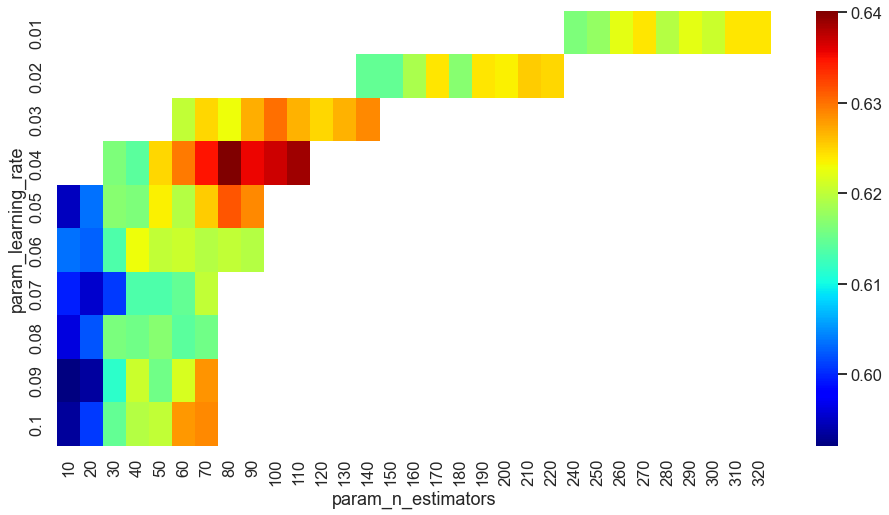

In [83]:
import seaborn as sns

# sns.heatmap(df, row='param_n_estimators', col='param_learning_rate', hue='mean_test_score')
with sns.axes_style('whitegrid'), sns.plotting_context('talk'):
    fig, ax = plt.subplots(figsize=(16, 8))
    sns.heatmap(df_pivot, cmap='jet', ax=ax)
    plt.show()

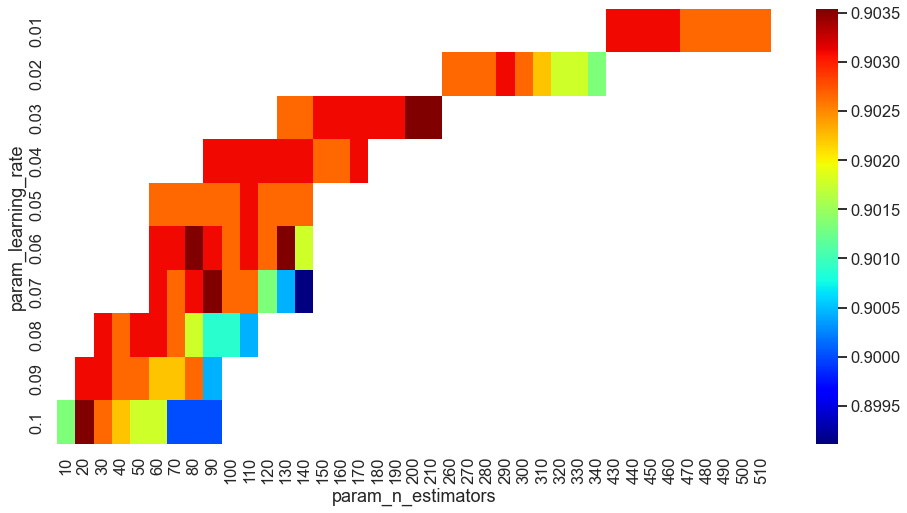

In [78]:
with sns.axes_style('whitegrid'), sns.plotting_context('talk'):
    fig, ax = plt.subplots(figsize=(16, 8))
    sns.heatmap(df_pivot_h41, cmap='jet', ax=ax)
    plt.show()

In [77]:
df_pivot_h41.loc[0.09, 10] = np.nan